In [1]:
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
import scipy.optimize as op
import itertools
import math
import re
import subprocess

In [2]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
plt.close("all")
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams["font.family"] = 'sans-serif'
mpl.rcParams['font.size'] = 8
sns.set(style="ticks")

# 
#mpl.use('Agg')
#mpl.rcParams['pdf.fonttype'] = 42

In [3]:
cd /Users/davidy/jamboree20crispr/negative_control_analysis

/Users/davidy/jamboree20crispr/negative_control_analysis


In [4]:
### Import CD164 gRNA dataframe
cd164_grna_df = pd.read_csv('CD164_negative_control_df.csv')

targeting_df = cd164_grna_df.loc[cd164_grna_df['Design_x']=='Screen_guide']
targeting_df['chr'] = targeting_df['Coordinates_x'].str.split(':').str[0]
targeting_df['coords'] = targeting_df['Coordinates_x'].str.split(':').str[1]
targeting_df[['start','end']] = targeting_df['coords'].str.split('-',expand=True)
targeting_df['avg_log2'] = (targeting_df['log2_rep1'] + targeting_df['log2_rep2'])/2

st_df = cd164_grna_df.loc[cd164_grna_df['Design_x']=='ST-CTRL']
nt_df = cd164_grna_df.loc[cd164_grna_df['Design_x']=='NT-CTRL']
st_df['avg_log2'] = (st_df['log2_rep1'] + st_df['log2_rep2'])/2
nt_df['avg_log2'] = (nt_df['log2_rep1'] + nt_df['log2_rep2'])/2
display(nt_df)
display(st_df)
print('Mean of NT:',np.mean(nt_df['avg_log2']))
print('Mean of ST:',np.mean(st_df['avg_log2']))
print(stats.ttest_ind(nt_df['avg_log2'], st_df['avg_log2'], equal_var=False))

# Report variance
print('Var of NT:',np.var(nt_df['avg_log2']))
print('Var of ST:',np.var(st_df['avg_log2']))



<ipython-input-4-639e4d01340b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targeting_df['chr'] = targeting_df['Coordinates_x'].str.split(':').str[0]
<ipython-input-4-639e4d01340b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targeting_df['coords'] = targeting_df['Coordinates_x'].str.split(':').str[1]
/Users/davidy/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

,Coordinates_x,log2_rep1,log2_rep2,Design_x,avg_log2
54501,CTRL,-0.238994,-0.929393,NT-CTRL,-0.584193
54502,CTRL,0.586402,1.007210,NT-CTRL,0.796806
54503,CTRL,-0.108209,0.238594,NT-CTRL,0.065192
54504,CTRL,0.692143,0.096097,NT-CTRL,0.394120
54505,CTRL,1.078397,0.818489,NT-CTRL,0.948443
...,...,...,...,...,...
55496,CTRL,0.739739,-0.085656,NT-CTRL,0.327042
55497,CTRL,1.398478,1.091861,NT-CTRL,1.245170
55498,CTRL,0.846734,-0.321423,NT-CTRL,0.262656
55499,CTRL,0.531333,1.087309,NT-CTRL,0.809321


,Coordinates_x,log2_rep1,log2_rep2,Design_x,avg_log2
53501,chr10:107843620-107843639:+,0.557577,-0.118953,ST-CTRL,0.219312
53502,chr10:107843650-107843669:+,-0.646121,-0.687304,ST-CTRL,-0.666713
53503,chr10:123598185-123598204:+,0.814645,-0.700440,ST-CTRL,0.057103
53504,chr10:123598305-123598324:-,-0.101339,-0.357732,ST-CTRL,-0.229535
53505,chr10:128283965-128283984:-,-0.359645,-0.194835,ST-CTRL,-0.277240
...,...,...,...,...,...
54496,chrX:55558450-55558469:+,1.672864,1.051056,ST-CTRL,1.361960
54497,chrX:66708015-66708034:-,0.317693,0.344110,ST-CTRL,0.330902
54498,chrX:78826872-78826891:+,0.388515,1.632822,ST-CTRL,1.010669
54499,chrX:84646201-84646220:+,2.557995,0.250714,ST-CTRL,1.404355


Mean of NT: 0.3163109460794392
Mean of ST: 0.26224579262528824
Ttest_indResult(statistic=1.2007648220430145, pvalue=0.22998809738176879)
Var of NT: 0.8579290773856558
Var of ST: 1.1673480397765899


In [5]:
"""
Workflow to determine the number of NT/ST controls:
For each ST/NT dataframe
Sample range(1,1000,1) rows X number of times. For bootstrapping, needs to be WITH replacement
For each n-row subsample, calculate mean and variance
Record the results of mean and variance in a dictionary, where n-row is the key, and the value is a list of tuples (mean,variance)
Plot, as a boxplot, each n-row results


"""
### Initialize dictionary
nt_mean_dict = {}
nt_var_dict = {}
nt_lod = []
nt_cor_dict = {}

st_mean_dict = {}
st_var_dict = {}
st_lod = []
st_cor_dict = {}


In [91]:
### Number of permutations per n-row
num_subsample = 1000
levenes_alpha = 0.05

# Define function
def iterate_neg_df(neg_df, neg_mean_dict, neg_var_dict, neg_lod):
    
    # Variance of the entire set
    full_variance = neg_df['avg_log2']
    
    for i in range(10,len(neg_df)+1,10):
        i_counter = 0
        levenes_failures = 0
        while i_counter < num_subsample:
            subsample = neg_df.sample(n=i, replace=True)
            neg_mean_dict.setdefault(i, []).append(np.mean(a=subsample['avg_log2']))
            neg_var_dict.setdefault(i, []).append(np.var(a=subsample['avg_log2'], ddof=1))
            
            # Rigorous Levene's test
            if stats.levene(subsample['avg_log2'], full_variance, center='trimmed')[1] < 0.05:
                levenes_below_alpha = 1 # This means the subsampled population looks different than the whole
                levenes_failures += 1
            else:
                levenes_below_alpha = 0

            adict = {'num_guides':i,
                    'subsample_mean':np.mean(a=subsample['avg_log2']),
                    'subsample_variance':np.var(a=subsample['avg_log2'], ddof=1),
                    'levenes_below_alpha':levenes_below_alpha}
            neg_lod.append(adict)
            

            i_counter += 1
        if i%50 == 0:
            print(i, levenes_failures/1000)
        
        

## Run ST and NT... This takes around 5-10 minutes.
print('Iterate ST')
iterate_neg_df(st_df, st_mean_dict, st_var_dict, st_lod)

print('Iterate NT')
iterate_neg_df(nt_df, nt_mean_dict, nt_var_dict, nt_lod)
           

Iterate ST
50 0.154
100 0.111
150 0.126
200 0.082
250 0.091
300 0.066
350 0.085
400 0.081
450 0.067
500 0.059
550 0.061
600 0.059
650 0.044
700 0.034
750 0.038
800 0.046
850 0.036
900 0.027
950 0.03
1000 0.029
Iterate NT
50 0.141
100 0.103
150 0.095
200 0.081
250 0.106
300 0.079
350 0.066
400 0.079
450 0.07
500 0.076
550 0.054
600 0.06
650 0.036
700 0.044
750 0.051
800 0.03
850 0.047
900 0.024
950 0.031
1000 0.035


In [92]:
### Convert lods into dataframes
nt_plot_df = pd.DataFrame(nt_lod)
st_plot_df = pd.DataFrame(st_lod)

nt_plot_df['type']='nt'
st_plot_df['type']='st'

neg_plot_df = pd.concat([nt_plot_df,st_plot_df])

display(st_plot_df)
display(neg_plot_df)

,num_guides,subsample_mean,subsample_variance,levenes_below_alpha,type
0,10,0.399031,0.864756,0,st
1,10,0.191270,1.444555,0,st
2,10,0.516708,0.610976,0,st
3,10,0.610851,2.158882,1,st
4,10,0.168015,0.401506,0,st
...,...,...,...,...,...
137457,1000,0.258624,1.183763,0,st
137458,1000,0.271361,1.183476,0,st
137459,1000,0.233165,1.042928,0,st
137460,1000,0.255747,1.054419,0,st


,num_guides,subsample_mean,subsample_variance,levenes_below_alpha,type
0,10,0.492505,0.415166,0,nt
1,10,0.679561,1.462590,1,nt
2,10,0.543658,0.556187,0,nt
3,10,-0.118781,0.667517,0,nt
4,10,0.298682,0.206441,0,nt
...,...,...,...,...,...
137457,1000,0.258624,1.183763,0,st
137458,1000,0.271361,1.183476,0,st
137459,1000,0.233165,1.042928,0,st
137460,1000,0.255747,1.054419,0,st


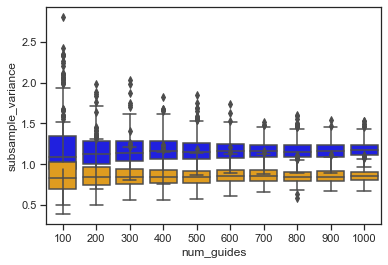

In [54]:
##### Plot
g1= sns.boxplot(data=st_plot_df.loc[st_plot_df['num_guides']%100==0], x='num_guides', y='subsample_variance', color='blue')

g2= sns.boxplot(data=nt_plot_df.loc[nt_plot_df['num_guides']%100==0], x='num_guides', y='subsample_variance', color='orange')

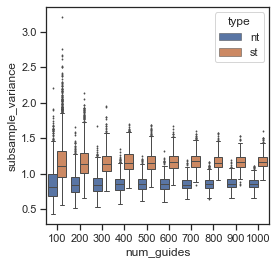

In [123]:
sns.set(rc = {'figure.figsize':(4,4)},style="ticks")

g3= sns.boxplot(data=neg_plot_df.loc[neg_plot_df['num_guides']%100==0], x='num_guides', y='subsample_variance', hue='type', linewidth=1, flierprops={'markersize': 1})

plt.savefig('subsample_variance_nt_vs_st_boxplot.pdf')


In [80]:
### Plot average variance for each num_guides

variance_lod = []
for i in range(10,1001,10):
    subsample_df = neg_plot_df.loc[neg_plot_df['num_guides']==i]
    adf = {'num_guides':i,
          'type':'st',
          'avg_variance':np.mean(subsample_df.loc[subsample_df['type']=='st']['subsample_variance']),
          'kl_distance':stats.entropy(pk=subsample_df.loc[subsample_df['type']=='st']['subsample_variance'], 
                  qk=neg_plot_df.loc[(neg_plot_df['type']=='st') & (neg_plot_df['num_guides']==1000)]['subsample_variance']),
          'levenes_pval':stats.levene(subsample_df.loc[subsample_df['type']=='st']['subsample_variance'], neg_plot_df.loc[(neg_plot_df['type']=='st') & (neg_plot_df['num_guides']==1000)]['subsample_variance'], center='trimmed')[1]}
    variance_lod.append(adf)
    bdf = {'num_guides':i,
          'type':'nt',
          'avg_variance':np.mean(subsample_df.loc[subsample_df['type']=='nt']['subsample_variance']),
          'kl_distance':stats.entropy(pk=subsample_df.loc[subsample_df['type']=='nt']['subsample_variance'], 
                  qk=neg_plot_df.loc[(neg_plot_df['type']=='nt') & (neg_plot_df['num_guides']==1000)]['subsample_variance']),
          'levenes_pval':stats.levene(subsample_df.loc[subsample_df['type']=='nt']['subsample_variance'], neg_plot_df.loc[(neg_plot_df['type']=='nt') & (neg_plot_df['num_guides']==1000)]['subsample_variance'], center='trimmed')[1]}
    variance_lod.append(bdf)
    
variance_df = pd.DataFrame(variance_lod)



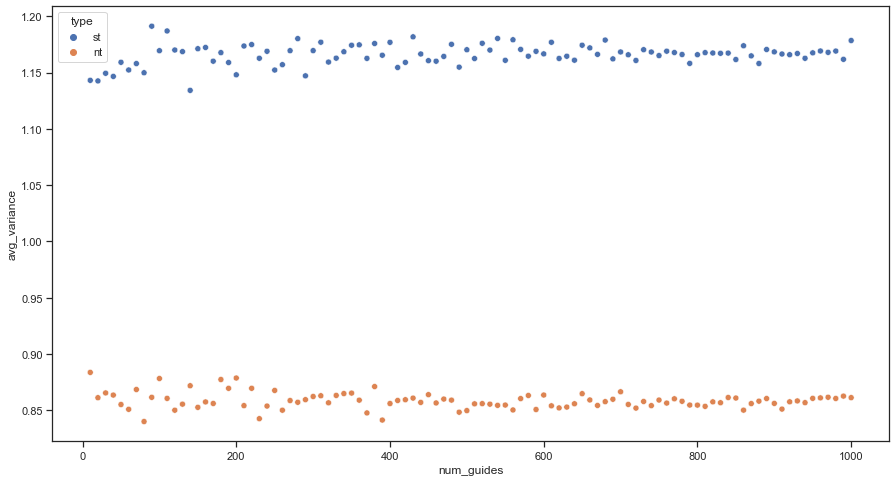

In [76]:
variance_df = pd.DataFrame(variance_lod)

g4 = sns.scatterplot(data=variance_df, x='num_guides',y='avg_variance', hue='type')

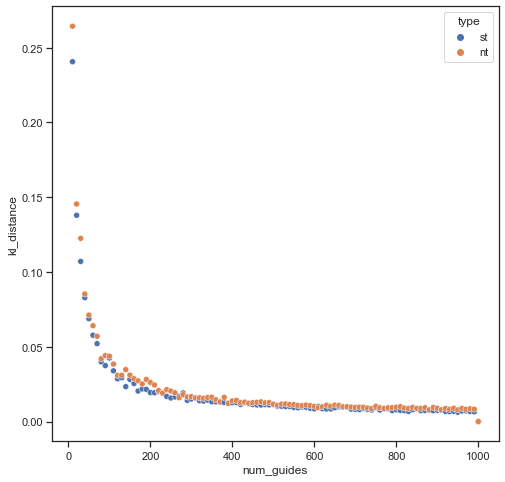

In [108]:
sns.set(rc = {'figure.figsize':(8,8)},style="ticks")
g5 = sns.scatterplot(data=variance_df, x='num_guides',y='kl_distance',hue='type')
plt.savefig('subsample_KL_distance_nt_vs_st_scatterplot.pdf')

,num_guides,type,avg_variance,kl_distance,levenes_pval
0,10,st,1.143114,0.240634,2.563411e-92
1,10,nt,0.883680,0.264411,3.611325e-85
2,20,st,1.142591,0.137952,1.647851e-107
3,20,nt,0.861220,0.145503,1.869359e-83
4,30,st,1.149386,0.107079,4.712998e-94
...,...,...,...,...,...
195,980,nt,0.860528,0.008478,7.813416e-02
196,990,st,1.161776,0.006486,4.839575e-01
197,990,nt,0.862632,0.008278,6.221475e-01
198,1000,st,1.178483,0.000000,1.000000e+00


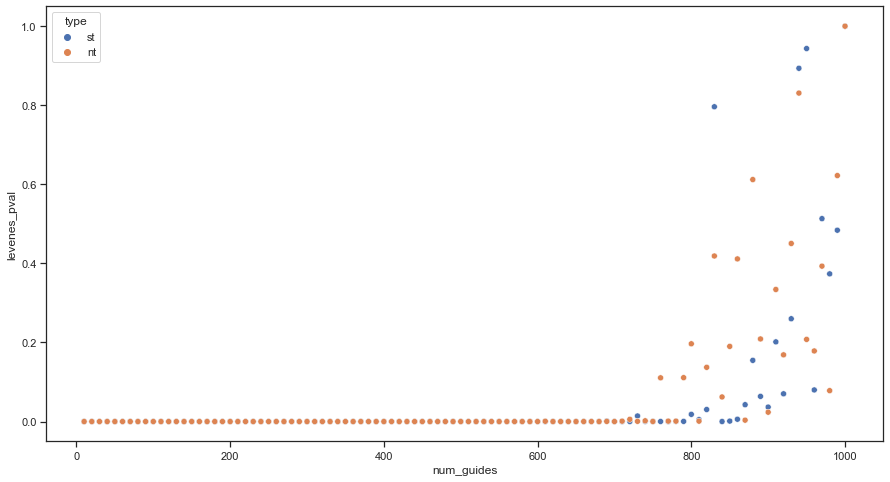

In [81]:
display(variance_df)
g6 = sns.scatterplot(data=variance_df, x='num_guides',y='levenes_pval',hue='type')

,type,empirical_pval,num_guides
0,st,0.072,520
1,nt,0.056,520
2,st,0.866,10
3,nt,0.277,10
4,st,0.066,530
...,...,...,...
195,nt,0.070,490
196,st,0.059,500
197,nt,0.076,500
198,st,0.058,510


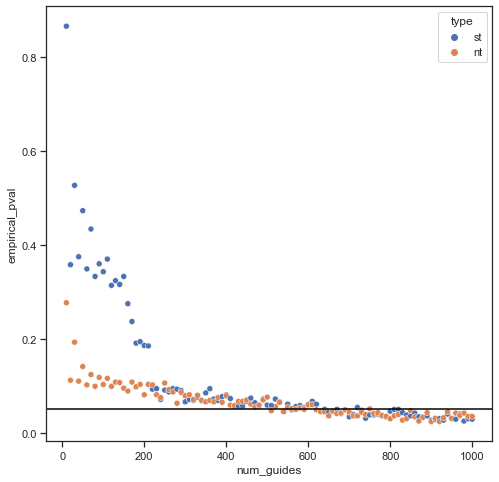

In [110]:
### Bootstrappy Levene's
lod = []
for n in set(neg_plot_df['num_guides'].tolist()):
    subset_df = neg_plot_df.loc[neg_plot_df['num_guides']==n]
    sdf = subset_df.loc[subset_df['type']=='st']['levenes_below_alpha'].sum()
    ndf = subset_df.loc[subset_df['type']=='nt']['levenes_below_alpha'].sum()

    adf = {'type':'st',
          'empirical_pval':sdf/1000,
          'num_guides':n}
    bdf = {'type':'nt',
          'empirical_pval':ndf/1000,
          'num_guides':n}
    lod.append(adf)
    lod.append(bdf)
levenes_bootstrap_df = pd.DataFrame(lod)
display(levenes_bootstrap_df)

sns.set(rc = {'figure.figsize':(8,8)},style="ticks")
g8 = sns.scatterplot(data=levenes_bootstrap_df, x='num_guides',y='empirical_pval',hue='type')
g8.axhline(0.05, color='black')
plt.savefig('subsample_bootstrap_levenes_uncorrected_nt_vs_st.pdf')


(-0.5, 2.5)

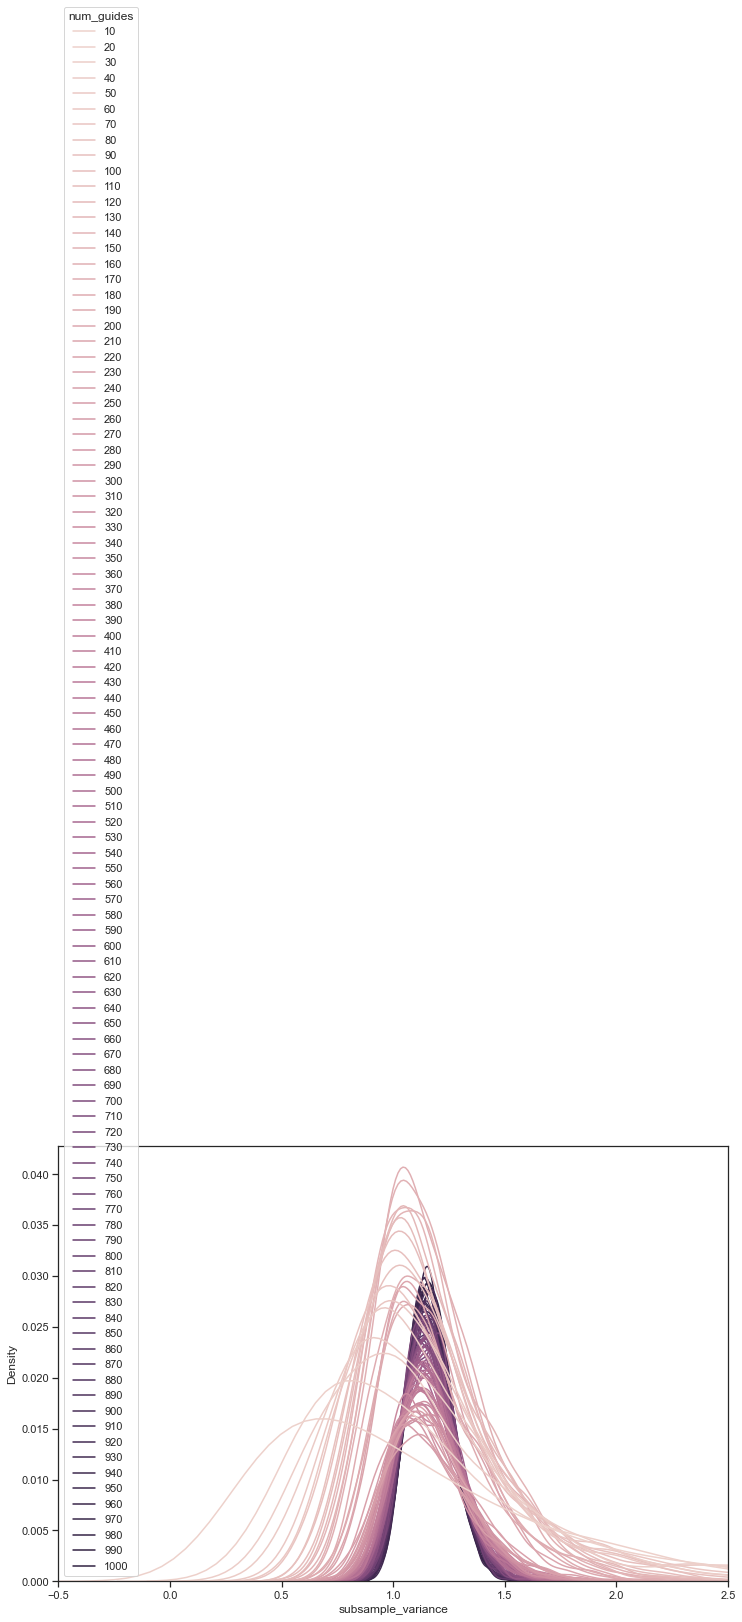

In [118]:
sns.set(rc = {'figure.figsize':(12,8)},style="ticks")

fig, ax = plt.subplots()
sns.kdeplot(ax=ax,data=neg_plot_df.loc[(neg_plot_df['num_guides']%10==0) & (neg_plot_df['type']=='st')], x="subsample_variance", hue="num_guides")
ax.set_xlim(-0.5,2.5)


(-0.5, 2.5)

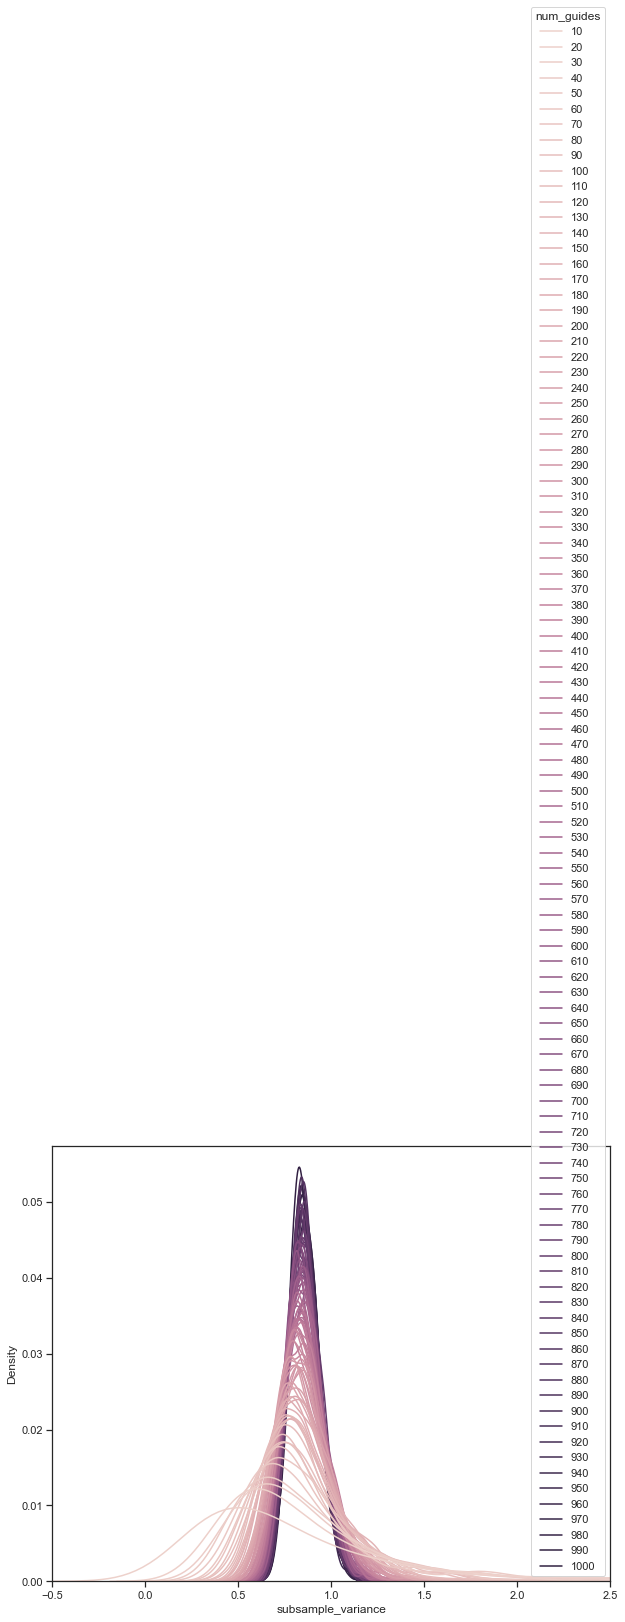

In [114]:
fig, ax = plt.subplots()
sns.kdeplot(ax=ax,data=neg_plot_df.loc[(neg_plot_df['num_guides']%10==0) & (neg_plot_df['type']=='nt')], x="subsample_variance", hue="num_guides")
ax.set_xlim(-0.5,2.5)

In [14]:
"""
Workflow to determine how ST and NT compare to in-TAD negative controls:

Need to see how the variance compares between ST, NT, and in-TAD negative/non-enhancer controls

"""

### First get coordinates for targeting guides
for i, row in targeting_df.iterrows():
    chrom, coords, strand = row['Coordinates_x'].split(':')
    start, end = coords.split('-')
    targeting_df.at[i, ['chr', 'start','end']] = chrom, start, end


chr6 108840570 108840591
chr6 108840575 108840596
chr6 108840576 108840597
chr6 108840580 108840601
chr6 108840615 108840636
chr6 108840616 108840637
chr6 108840730 108840751
chr6 108840741 108840762
chr6 108840755 108840776
chr6 108840778 108840799
chr6 108840790 108840811
chr6 108840797 108840818
chr6 108840812 108840833
chr6 108840864 108840885
chr6 108840877 108840898
chr6 108840878 108840899
chr6 108840880 108840901
chr6 108840915 108840936
chr6 108840952 108840973
chr6 108840957 108840978
chr6 108840996 108841017
chr6 108841000 108841021
chr6 108841001 108841022
chr6 108841005 108841026
chr6 108841008 108841029
chr6 108841016 108841037
chr6 108841017 108841038
chr6 108841018 108841039
chr6 108841019 108841040
chr6 108841021 108841042
chr6 108841025 108841046
chr6 108841026 108841047
chr6 108841027 108841048
chr6 108841034 108841055
chr6 108841035 108841056
chr6 108841068 108841089
chr6 108841071 108841092
chr6 108841076 108841097
chr6 108841077 108841098
chr6 108841086 108841107


chr6 108844476 108844497
chr6 108844489 108844510
chr6 108844498 108844519
chr6 108844514 108844535
chr6 108844515 108844536
chr6 108844522 108844543
chr6 108844523 108844544
chr6 108844537 108844558
chr6 108844542 108844563
chr6 108844552 108844573
chr6 108844553 108844574
chr6 108844559 108844580
chr6 108844572 108844593
chr6 108844589 108844610
chr6 108844590 108844611
chr6 108844593 108844614
chr6 108844613 108844634
chr6 108844636 108844657
chr6 108844645 108844666
chr6 108844663 108844684
chr6 108844671 108844692
chr6 108844685 108844706
chr6 108844706 108844727
chr6 108844730 108844751
chr6 108844731 108844752
chr6 108844742 108844763
chr6 108844781 108844802
chr6 108844801 108844822
chr6 108844802 108844823
chr6 108844819 108844840
chr6 108844819 108844840
chr6 108844820 108844841
chr6 108844822 108844843
chr6 108844823 108844844
chr6 108844827 108844848
chr6 108844844 108844865
chr6 108844846 108844867
chr6 108844857 108844878
chr6 108844881 108844902
chr6 108844882 108844903


chr6 108848208 108848229
chr6 108848214 108848235
chr6 108848215 108848236
chr6 108848221 108848242
chr6 108848225 108848246
chr6 108848226 108848247
chr6 108848227 108848248
chr6 108848240 108848261
chr6 108848241 108848262
chr6 108848246 108848267
chr6 108848268 108848289
chr6 108848294 108848315
chr6 108848295 108848316
chr6 108848298 108848319
chr6 108848299 108848320
chr6 108848307 108848328
chr6 108848307 108848328
chr6 108848325 108848346
chr6 108848325 108848346
chr6 108848330 108848351
chr6 108848344 108848365
chr6 108848350 108848371
chr6 108848353 108848374
chr6 108848354 108848375
chr6 108848357 108848378
chr6 108848358 108848379
chr6 108848361 108848382
chr6 108848363 108848384
chr6 108848367 108848388
chr6 108848373 108848394
chr6 108848378 108848399
chr6 108848381 108848402
chr6 108848384 108848405
chr6 108848385 108848406
chr6 108848396 108848417
chr6 108848409 108848430
chr6 108848410 108848431
chr6 108848412 108848433
chr6 108848419 108848440
chr6 108848420 108848441


chr6 108851561 108851582
chr6 108851564 108851585
chr6 108851568 108851589
chr6 108851572 108851593
chr6 108851585 108851606
chr6 108851639 108851660
chr6 108851645 108851666
chr6 108851646 108851667
chr6 108851648 108851669
chr6 108851651 108851672
chr6 108851651 108851672
chr6 108851656 108851677
chr6 108851803 108851824
chr6 108851804 108851825
chr6 108851804 108851825
chr6 108851807 108851828
chr6 108851907 108851928
chr6 108851952 108851973
chr6 108851963 108851984
chr6 108851964 108851985
chr6 108851966 108851987
chr6 108851967 108851988
chr6 108851977 108851998
chr6 108852008 108852029
chr6 108852023 108852044
chr6 108852027 108852048
chr6 108852057 108852078
chr6 108852072 108852093
chr6 108852078 108852099
chr6 108852105 108852126
chr6 108852129 108852150
chr6 108852132 108852153
chr6 108852209 108852230
chr6 108852210 108852231
chr6 108852211 108852232
chr6 108852212 108852233
chr6 108852219 108852240
chr6 108852220 108852241
chr6 108852267 108852288
chr6 108852346 108852367


chr6 108860333 108860354
chr6 108860338 108860359
chr6 108860342 108860363
chr6 108860357 108860378
chr6 108860365 108860386
chr6 108860675 108860696
chr6 108860682 108860703
chr6 108860686 108860707
chr6 108860698 108860719
chr6 108860701 108860722
chr6 108860713 108860734
chr6 108860725 108860746
chr6 108860726 108860747
chr6 108860727 108860748
chr6 108860728 108860749
chr6 108860730 108860751
chr6 108860736 108860757
chr6 108860738 108860759
chr6 108860739 108860760
chr6 108860765 108860786
chr6 108860779 108860800
chr6 108860781 108860802
chr6 108860791 108860812
chr6 108860792 108860813
chr6 108860838 108860859
chr6 108860845 108860866
chr6 108860852 108860873
chr6 108860856 108860877
chr6 108860867 108860888
chr6 108860873 108860894
chr6 108860880 108860901
chr6 108860911 108860932
chr6 108860912 108860933
chr6 108860945 108860966
chr6 108860960 108860981
chr6 108860969 108860990
chr6 108861002 108861023
chr6 108861004 108861025
chr6 108861015 108861036
chr6 108861032 108861053


chr6 108866604 108866625
chr6 108866620 108866641
chr6 108866642 108866663
chr6 108866665 108866686
chr6 108866673 108866694
chr6 108866685 108866706
chr6 108866697 108866718
chr6 108866711 108866732
chr6 108866798 108866819
chr6 108866803 108866824
chr6 108866839 108866860
chr6 108866890 108866911
chr6 108866894 108866915
chr6 108866921 108866942
chr6 108866922 108866943
chr6 108866936 108866957
chr6 108866937 108866958
chr6 108866952 108866973
chr6 108866953 108866974
chr6 108867007 108867028
chr6 108867015 108867036
chr6 108867022 108867043
chr6 108867054 108867075
chr6 108867096 108867117
chr6 108867119 108867140
chr6 108867149 108867170
chr6 108867164 108867185
chr6 108867164 108867185
chr6 108867186 108867207
chr6 108867189 108867210
chr6 108867211 108867232
chr6 108867226 108867247
chr6 108867227 108867248
chr6 108867229 108867250
chr6 108867247 108867268
chr6 108867248 108867269
chr6 108867253 108867274
chr6 108867260 108867281
chr6 108867260 108867281
chr6 108867261 108867282


chr6 108871903 108871924
chr6 108871905 108871926
chr6 108871914 108871935
chr6 108871916 108871937
chr6 108871996 108872017
chr6 108872009 108872030
chr6 108872013 108872034
chr6 108872027 108872048
chr6 108872028 108872049
chr6 108872044 108872065
chr6 108872063 108872084
chr6 108872067 108872088
chr6 108872075 108872096
chr6 108872086 108872107
chr6 108872101 108872122
chr6 108872128 108872149
chr6 108872129 108872150
chr6 108872134 108872155
chr6 108872152 108872173
chr6 108872156 108872177
chr6 108872157 108872178
chr6 108872161 108872182
chr6 108872162 108872183
chr6 108872163 108872184
chr6 108872167 108872188
chr6 108872168 108872189
chr6 108872180 108872201
chr6 108872180 108872201
chr6 108872207 108872228
chr6 108872208 108872229
chr6 108872237 108872258
chr6 108872252 108872273
chr6 108872260 108872281
chr6 108872269 108872290
chr6 108872270 108872291
chr6 108872277 108872298
chr6 108872281 108872302
chr6 108872284 108872305
chr6 108872327 108872348
chr6 108872328 108872349


chr6 108875128 108875149
chr6 108875135 108875156
chr6 108875164 108875185
chr6 108875165 108875186
chr6 108875166 108875187
chr6 108875171 108875192
chr6 108875216 108875237
chr6 108875265 108875286
chr6 108875295 108875316
chr6 108875296 108875317
chr6 108875300 108875321
chr6 108875305 108875326
chr6 108875309 108875330
chr6 108875310 108875331
chr6 108875333 108875354
chr6 108875336 108875357
chr6 108875343 108875364
chr6 108875346 108875367
chr6 108875347 108875368
chr6 108875348 108875369
chr6 108875353 108875374
chr6 108875354 108875375
chr6 108875355 108875376
chr6 108875370 108875391
chr6 108875373 108875394
chr6 108875381 108875402
chr6 108875384 108875405
chr6 108875400 108875421
chr6 108875402 108875423
chr6 108875409 108875430
chr6 108875410 108875431
chr6 108875411 108875432
chr6 108875418 108875439
chr6 108875419 108875440
chr6 108875420 108875441
chr6 108875445 108875466
chr6 108875446 108875467
chr6 108875448 108875469
chr6 108875457 108875478
chr6 108875461 108875482


chr6 108880245 108880266
chr6 108880246 108880267
chr6 108880252 108880273
chr6 108880274 108880295
chr6 108880277 108880298
chr6 108880279 108880300
chr6 108880282 108880303
chr6 108880282 108880303
chr6 108880283 108880304
chr6 108880290 108880311
chr6 108880290 108880311
chr6 108880291 108880312
chr6 108880294 108880315
chr6 108880295 108880316
chr6 108880296 108880317
chr6 108880297 108880318
chr6 108880301 108880322
chr6 108880313 108880334
chr6 108880314 108880335
chr6 108880338 108880359
chr6 108880342 108880363
chr6 108880343 108880364
chr6 108880344 108880365
chr6 108880349 108880370
chr6 108880350 108880371
chr6 108880381 108880402
chr6 108880386 108880407
chr6 108880388 108880409
chr6 108880389 108880410
chr6 108880391 108880412
chr6 108880402 108880423
chr6 108880402 108880423
chr6 108880409 108880430
chr6 108880410 108880431
chr6 108880419 108880440
chr6 108880425 108880446
chr6 108880430 108880451
chr6 108880448 108880469
chr6 108880455 108880476
chr6 108880461 108880482


chr6 108886146 108886167
chr6 108886148 108886169
chr6 108886162 108886183
chr6 108886199 108886220
chr6 108886205 108886226
chr6 108886235 108886256
chr6 108886248 108886269
chr6 108886260 108886281
chr6 108886268 108886289
chr6 108886451 108886472
chr6 108886454 108886475
chr6 108886584 108886605
chr6 108886601 108886622
chr6 108886602 108886623
chr6 108886608 108886629
chr6 108886609 108886630
chr6 108886720 108886741
chr6 108886728 108886749
chr6 108886734 108886755
chr6 108886738 108886759
chr6 108886748 108886769
chr6 108886749 108886770
chr6 108886757 108886778
chr6 108886758 108886779
chr6 108886773 108886794
chr6 108886774 108886795
chr6 108886811 108886832
chr6 108886826 108886847
chr6 108887232 108887253
chr6 108887243 108887264
chr6 108887267 108887288
chr6 108887280 108887301
chr6 108887284 108887305
chr6 108887285 108887306
chr6 108887291 108887312
chr6 108887328 108887349
chr6 108887337 108887358
chr6 108887343 108887364
chr6 108887343 108887364
chr6 108887349 108887370


chr6 108893720 108893741
chr6 108893721 108893742
chr6 108893724 108893745
chr6 108894018 108894039
chr6 108894019 108894040
chr6 108894033 108894054
chr6 108894038 108894059
chr6 108894039 108894060
chr6 108894040 108894061
chr6 108894042 108894063
chr6 108894065 108894086
chr6 108894069 108894090
chr6 108894152 108894173
chr6 108894156 108894177
chr6 108894445 108894466
chr6 108894446 108894467
chr6 108894452 108894473
chr6 108894453 108894474
chr6 108894454 108894475
chr6 108894459 108894480
chr6 108894462 108894483
chr6 108894469 108894490
chr6 108894470 108894491
chr6 108894470 108894491
chr6 108894493 108894514
chr6 108894503 108894524
chr6 108894504 108894525
chr6 108894505 108894526
chr6 108894505 108894526
chr6 108894518 108894539
chr6 108894522 108894543
chr6 108894527 108894548
chr6 108894528 108894549
chr6 108894529 108894550
chr6 108894535 108894556
chr6 108894553 108894574
chr6 108894554 108894575
chr6 108894555 108894576
chr6 108894562 108894583
chr6 108894568 108894589


chr6 108899239 108899260
chr6 108899240 108899261
chr6 108899241 108899262
chr6 108899266 108899287
chr6 108899279 108899300
chr6 108899352 108899373
chr6 108899353 108899374
chr6 108899355 108899376
chr6 108899411 108899432
chr6 108899461 108899482
chr6 108899495 108899516
chr6 108899497 108899518
chr6 108899498 108899519
chr6 108899536 108899557
chr6 108899541 108899562
chr6 108899546 108899567
chr6 108899556 108899577
chr6 108899557 108899578
chr6 108899603 108899624
chr6 108899633 108899654
chr6 108899658 108899679
chr6 108899671 108899692
chr6 108899695 108899716
chr6 108899696 108899717
chr6 108899698 108899719
chr6 108899707 108899728
chr6 108899730 108899751
chr6 108899739 108899760
chr6 108899768 108899789
chr6 108899771 108899792
chr6 108899847 108899868
chr6 108899867 108899888
chr6 108899868 108899889
chr6 108899869 108899890
chr6 108899875 108899896
chr6 108899876 108899897
chr6 108899952 108899973
chr6 108899953 108899974
chr6 108900014 108900035
chr6 108900023 108900044


chr6 108905305 108905326
chr6 108905306 108905327
chr6 108905307 108905328
chr6 108905310 108905331
chr6 108905412 108905433
chr6 108905413 108905434
chr6 108905419 108905440
chr6 108905422 108905443
chr6 108905430 108905451
chr6 108905467 108905488
chr6 108905489 108905510
chr6 108905504 108905525
chr6 108905612 108905633
chr6 108905622 108905643
chr6 108905670 108905691
chr6 108905678 108905699
chr6 108905695 108905716
chr6 108905713 108905734
chr6 108905744 108905765
chr6 108905756 108905777
chr6 108905758 108905779
chr6 108905759 108905780
chr6 108905771 108905792
chr6 108905779 108905800
chr6 108905785 108905806
chr6 108905810 108905831
chr6 108905814 108905835
chr6 108905815 108905836
chr6 108905841 108905862
chr6 108905854 108905875
chr6 108905855 108905876
chr6 108905861 108905882
chr6 108905874 108905895
chr6 108905879 108905900
chr6 108905888 108905909
chr6 108905897 108905918
chr6 108905897 108905918
chr6 108905904 108905925
chr6 108905915 108905936
chr6 108905924 108905945


chr6 108913935 108913956
chr6 108913936 108913957
chr6 108913966 108913987
chr6 108914008 108914029
chr6 108914013 108914034
chr6 108914041 108914062
chr6 108914042 108914063
chr6 108914088 108914109
chr6 108914093 108914114
chr6 108914096 108914117
chr6 108914191 108914212
chr6 108914191 108914212
chr6 108914192 108914213
chr6 108914199 108914220
chr6 108914200 108914221
chr6 108914245 108914266
chr6 108914247 108914268
chr6 108914255 108914276
chr6 108914271 108914292
chr6 108914301 108914322
chr6 108914321 108914342
chr6 108914322 108914343
chr6 108914327 108914348
chr6 108914327 108914348
chr6 108914329 108914350
chr6 108914343 108914364
chr6 108914350 108914371
chr6 108914364 108914385
chr6 108914375 108914396
chr6 108914376 108914397
chr6 108914377 108914398
chr6 108914378 108914399
chr6 108914382 108914403
chr6 108914387 108914408
chr6 108914393 108914414
chr6 108914394 108914415
chr6 108914395 108914416
chr6 108914396 108914417
chr6 108914401 108914422
chr6 108914402 108914423


chr6 108918348 108918369
chr6 108918349 108918370
chr6 108918349 108918370
chr6 108918350 108918371
chr6 108918357 108918378
chr6 108918358 108918379
chr6 108918360 108918381
chr6 108918372 108918393
chr6 108918373 108918394
chr6 108918383 108918404
chr6 108918508 108918529
chr6 108918509 108918530
chr6 108918510 108918531
chr6 108918519 108918540
chr6 108918522 108918543
chr6 108918524 108918545
chr6 108918549 108918570
chr6 108918550 108918571
chr6 108918551 108918572
chr6 108918562 108918583
chr6 108918566 108918587
chr6 108918577 108918598
chr6 108918577 108918598
chr6 108918587 108918608
chr6 108918588 108918609
chr6 108918589 108918610
chr6 108918593 108918614
chr6 108918594 108918615
chr6 108918595 108918616
chr6 108918616 108918637
chr6 108918617 108918638
chr6 108918623 108918644
chr6 108918626 108918647
chr6 108918626 108918647
chr6 108918629 108918650
chr6 108918630 108918651
chr6 108918640 108918661
chr6 108918641 108918662
chr6 108918655 108918676
chr6 108918660 108918681


chr6 108922761 108922782
chr6 108922761 108922782
chr6 108922762 108922783
chr6 108922763 108922784
chr6 108922770 108922791
chr6 108922820 108922841
chr6 108922845 108922866
chr6 108922863 108922884
chr6 108922878 108922899
chr6 108922879 108922900
chr6 108922896 108922917
chr6 108922898 108922919
chr6 108922908 108922929
chr6 108922914 108922935
chr6 108922922 108922943
chr6 108922923 108922944
chr6 108922924 108922945
chr6 108922932 108922953
chr6 108922943 108922964
chr6 108922944 108922965
chr6 108922987 108923008
chr6 108923029 108923050
chr6 108923033 108923054
chr6 108923044 108923065
chr6 108923046 108923067
chr6 108923061 108923082
chr6 108923062 108923083
chr6 108923065 108923086
chr6 108923066 108923087
chr6 108923067 108923088
chr6 108923068 108923089
chr6 108923078 108923099
chr6 108923115 108923136
chr6 108923134 108923155
chr6 108923178 108923199
chr6 108923191 108923212
chr6 108923200 108923221
chr6 108923203 108923224
chr6 108923328 108923349
chr6 108923330 108923351


chr6 108927148 108927169
chr6 108927149 108927170
chr6 108927150 108927171
chr6 108927151 108927172
chr6 108927152 108927173
chr6 108927209 108927230
chr6 108927210 108927231
chr6 108927222 108927243
chr6 108927225 108927246
chr6 108927226 108927247
chr6 108927227 108927248
chr6 108927234 108927255
chr6 108927285 108927306
chr6 108927286 108927307
chr6 108927292 108927313
chr6 108927320 108927341
chr6 108927333 108927354
chr6 108927336 108927357
chr6 108927362 108927383
chr6 108927370 108927391
chr6 108927371 108927392
chr6 108927372 108927393
chr6 108927379 108927400
chr6 108927409 108927430
chr6 108927416 108927437
chr6 108927420 108927441
chr6 108927420 108927441
chr6 108927430 108927451
chr6 108927431 108927452
chr6 108927505 108927526
chr6 108927582 108927603
chr6 108927583 108927604
chr6 108927618 108927639
chr6 108927748 108927769
chr6 108927758 108927779
chr6 108927759 108927780
chr6 108927782 108927803
chr6 108927801 108927822
chr6 108927812 108927833
chr6 108927816 108927837


chr6 108939258 108939279
chr6 108939263 108939284
chr6 108939362 108939383
chr6 108939366 108939387
chr6 108939367 108939388
chr6 108939722 108939743
chr6 108939742 108939763
chr6 108939867 108939888
chr6 108939891 108939912
chr6 108939907 108939928
chr6 108939956 108939977
chr6 108939957 108939978
chr6 108939965 108939986
chr6 108939969 108939990
chr6 108940040 108940061
chr6 108940050 108940071
chr6 108940053 108940074
chr6 108940056 108940077
chr6 108940072 108940093
chr6 108940088 108940109
chr6 108940113 108940134
chr6 108940121 108940142
chr6 108940254 108940275
chr6 108940260 108940281
chr6 108940287 108940308
chr6 108940290 108940311
chr6 108940344 108940365
chr6 108940350 108940371
chr6 108940355 108940376
chr6 108940364 108940385
chr6 108940369 108940390
chr6 108940370 108940391
chr6 108940376 108940397
chr6 108940387 108940408
chr6 108940388 108940409
chr6 108940390 108940411
chr6 108940397 108940418
chr6 108940421 108940442
chr6 108940475 108940496
chr6 108940502 108940523


chr6 108945461 108945482
chr6 108945468 108945489
chr6 108945475 108945496
chr6 108945482 108945503
chr6 108945518 108945539
chr6 108945529 108945550
chr6 108945549 108945570
chr6 108945550 108945571
chr6 108945556 108945577
chr6 108945566 108945587
chr6 108945567 108945588
chr6 108945571 108945592
chr6 108945578 108945599
chr6 108945612 108945633
chr6 108945616 108945637
chr6 108945623 108945644
chr6 108945665 108945686
chr6 108945671 108945692
chr6 108945689 108945710
chr6 108945703 108945724
chr6 108945708 108945729
chr6 108945726 108945747
chr6 108945727 108945748
chr6 108945762 108945783
chr6 108945765 108945786
chr6 108945768 108945789
chr6 108945799 108945820
chr6 108945803 108945824
chr6 108945805 108945826
chr6 108945817 108945838
chr6 108945828 108945849
chr6 108945832 108945853
chr6 108945833 108945854
chr6 108945837 108945858
chr6 108945838 108945859
chr6 108945839 108945860
chr6 108945842 108945863
chr6 108945846 108945867
chr6 108945847 108945868
chr6 108945852 108945873


chr6 108949089 108949110
chr6 108949160 108949181
chr6 108949165 108949186
chr6 108949169 108949190
chr6 108949175 108949196
chr6 108949176 108949197
chr6 108949197 108949218
chr6 108949208 108949229
chr6 108949209 108949230
chr6 108949215 108949236
chr6 108949233 108949254
chr6 108949250 108949271
chr6 108949256 108949277
chr6 108949259 108949280
chr6 108949298 108949319
chr6 108949310 108949331
chr6 108949389 108949410
chr6 108949483 108949504
chr6 108949546 108949567
chr6 108949577 108949598
chr6 108949595 108949616
chr6 108949599 108949620
chr6 108949605 108949626
chr6 108949606 108949627
chr6 108949613 108949634
chr6 108949627 108949648
chr6 108949637 108949658
chr6 108949638 108949659
chr6 108949641 108949662
chr6 108949644 108949665
chr6 108949669 108949690
chr6 108949670 108949691
chr6 108949675 108949696
chr6 108949675 108949696
chr6 108949686 108949707
chr6 108949687 108949708
chr6 108949689 108949710
chr6 108949698 108949719
chr6 108949704 108949725
chr6 108949707 108949728


chr6 108953723 108953744
chr6 108953724 108953745
chr6 108953725 108953746
chr6 108953732 108953753
chr6 108953733 108953754
chr6 108953781 108953802
chr6 108953818 108953839
chr6 108953832 108953853
chr6 108953843 108953864
chr6 108953844 108953865
chr6 108953877 108953898
chr6 108953947 108953968
chr6 108953950 108953971
chr6 108953952 108953973
chr6 108953953 108953974
chr6 108953965 108953986
chr6 108953966 108953987
chr6 108954030 108954051
chr6 108954031 108954052
chr6 108954032 108954053
chr6 108954032 108954053
chr6 108954037 108954058
chr6 108954038 108954059
chr6 108954109 108954130
chr6 108954110 108954131
chr6 108954119 108954140
chr6 108954123 108954144
chr6 108954124 108954145
chr6 108954141 108954162
chr6 108954236 108954257
chr6 108954242 108954263
chr6 108954243 108954264
chr6 108954244 108954265
chr6 108954269 108954290
chr6 108954270 108954291
chr6 108954278 108954299
chr6 108954315 108954336
chr6 108954316 108954337
chr6 108954323 108954344
chr6 108954326 108954347


chr6 108958128 108958149
chr6 108958129 108958150
chr6 108958141 108958162
chr6 108958148 108958169
chr6 108958149 108958170
chr6 108958153 108958174
chr6 108958190 108958211
chr6 108958281 108958302
chr6 108958287 108958308
chr6 108958304 108958325
chr6 108958327 108958348
chr6 108958328 108958349
chr6 108958329 108958350
chr6 108958377 108958398
chr6 108958378 108958399
chr6 108958390 108958411
chr6 108958420 108958441
chr6 108958426 108958447
chr6 108958460 108958481
chr6 108958464 108958485
chr6 108958465 108958486
chr6 108958474 108958495
chr6 108958481 108958502
chr6 108958488 108958509
chr6 108958490 108958511
chr6 108958493 108958514
chr6 108958497 108958518
chr6 108958498 108958519
chr6 108958499 108958520
chr6 108958500 108958521
chr6 108958501 108958522
chr6 108958502 108958523
chr6 108958514 108958535
chr6 108958534 108958555
chr6 108958543 108958564
chr6 108958561 108958582
chr6 108958574 108958595
chr6 108958578 108958599
chr6 108958603 108958624
chr6 108958604 108958625


chr6 108961490 108961511
chr6 108961491 108961512
chr6 108961499 108961520
chr6 108961516 108961537
chr6 108961517 108961538
chr6 108961529 108961550
chr6 108961549 108961570
chr6 108961550 108961571
chr6 108961556 108961577
chr6 108961576 108961597
chr6 108961582 108961603
chr6 108961645 108961666
chr6 108961659 108961680
chr6 108961678 108961699
chr6 108961689 108961710
chr6 108961695 108961716
chr6 108961748 108961769
chr6 108961774 108961795
chr6 108961789 108961810
chr6 108961815 108961836
chr6 108961821 108961842
chr6 108961822 108961843
chr6 108961823 108961844
chr6 108961836 108961857
chr6 108961837 108961858
chr6 108961891 108961912
chr6 108961952 108961973
chr6 108961959 108961980
chr6 108961978 108961999
chr6 108962004 108962025
chr6 108962010 108962031
chr6 108962024 108962045
chr6 108962036 108962057
chr6 108962039 108962060
chr6 108962054 108962075
chr6 108962055 108962076
chr6 108962069 108962090
chr6 108962086 108962107
chr6 108962087 108962108
chr6 108962093 108962114


chr6 108966969 108966990
chr6 108966977 108966998
chr6 108966979 108967000
chr6 108967009 108967030
chr6 108967009 108967030
chr6 108967010 108967031
chr6 108967010 108967031
chr6 108967018 108967039
chr6 108967019 108967040
chr6 108967020 108967041
chr6 108967026 108967047
chr6 108967032 108967053
chr6 108967033 108967054
chr6 108967047 108967068
chr6 108967047 108967068
chr6 108967048 108967069
chr6 108967049 108967070
chr6 108967050 108967071
chr6 108967061 108967082
chr6 108967073 108967094
chr6 108967074 108967095
chr6 108967077 108967098
chr6 108967078 108967099
chr6 108967110 108967131
chr6 108967113 108967134
chr6 108967114 108967135
chr6 108967127 108967148
chr6 108967135 108967156
chr6 108967144 108967165
chr6 108967159 108967180
chr6 108967170 108967191
chr6 108967184 108967205
chr6 108967184 108967205
chr6 108967185 108967206
chr6 108967185 108967206
chr6 108967202 108967223
chr6 108967211 108967232
chr6 108967214 108967235
chr6 108967224 108967245
chr6 108967226 108967247


chr6 108971327 108971348
chr6 108971328 108971349
chr6 108971330 108971351
chr6 108971337 108971358
chr6 108971349 108971370
chr6 108971350 108971371
chr6 108971355 108971376
chr6 108971376 108971397
chr6 108971386 108971407
chr6 108971391 108971412
chr6 108971391 108971412
chr6 108971409 108971430
chr6 108971425 108971446
chr6 108971438 108971459
chr6 108971440 108971461
chr6 108971442 108971463
chr6 108971452 108971473
chr6 108971453 108971474
chr6 108971479 108971500
chr6 108971480 108971501
chr6 108971481 108971502
chr6 108971484 108971505
chr6 108971486 108971507
chr6 108971487 108971508
chr6 108971518 108971539
chr6 108971519 108971540
chr6 108971527 108971548
chr6 108971585 108971606
chr6 108971596 108971617
chr6 108971620 108971641
chr6 108971624 108971645
chr6 108971625 108971646
chr6 108971947 108971968
chr6 108971957 108971978
chr6 108971966 108971987
chr6 108971985 108972006
chr6 108971992 108972013
chr6 108972005 108972026
chr6 108972008 108972029
chr6 108972029 108972050


chr6 108985745 108985766
chr6 108985746 108985767
chr6 108985765 108985786
chr6 108985785 108985806
chr6 108985794 108985815
chr6 108985801 108985822
chr6 108985894 108985915
chr6 108985906 108985927
chr6 108985934 108985955
chr6 108985939 108985960
chr6 108985949 108985970
chr6 108985964 108985985
chr6 108985989 108986010
chr6 108985994 108986015
chr6 108985995 108986016
chr6 108985996 108986017
chr6 108986003 108986024
chr6 108986005 108986026
chr6 108986009 108986030
chr6 108986011 108986032
chr6 108986013 108986034
chr6 108986157 108986178
chr6 108986158 108986179
chr6 108986178 108986199
chr6 108986207 108986228
chr6 108986213 108986234
chr6 108986214 108986235
chr6 108986237 108986258
chr6 108986252 108986273
chr6 108986292 108986313
chr6 108986297 108986318
chr6 108986297 108986318
chr6 108986337 108986358
chr6 108986338 108986359
chr6 108986423 108986444
chr6 108986473 108986494
chr6 108986511 108986532
chr6 108986545 108986566
chr6 108986596 108986617
chr6 108986597 108986618


chr6 108992960 108992981
chr6 108992961 108992982
chr6 108993006 108993027
chr6 108993016 108993037
chr6 108993056 108993077
chr6 108993134 108993155
chr6 108993163 108993184
chr6 108993164 108993185
chr6 108993168 108993189
chr6 108993197 108993218
chr6 108993315 108993336
chr6 108993316 108993337
chr6 108993331 108993352
chr6 108993332 108993353
chr6 108993359 108993380
chr6 108993362 108993383
chr6 108993380 108993401
chr6 108993441 108993462
chr6 108993446 108993467
chr6 108993465 108993486
chr6 108993511 108993532
chr6 108993536 108993557
chr6 108993569 108993590
chr6 108993570 108993591
chr6 108993616 108993637
chr6 108993634 108993655
chr6 108993653 108993674
chr6 108993655 108993676
chr6 108993660 108993681
chr6 108993668 108993689
chr6 108993675 108993696
chr6 108993682 108993703
chr6 108993786 108993807
chr6 108993787 108993808
chr6 108993804 108993825
chr6 108993846 108993867
chr6 108993892 108993913
chr6 108993893 108993914
chr6 108993913 108993934
chr6 108993923 108993944


chr6 109001519 109001540
chr6 109001575 109001596
chr6 109001588 109001609
chr6 109001589 109001610
chr6 109001612 109001633
chr6 109001657 109001678
chr6 109001658 109001679
chr6 109001672 109001693
chr6 109001686 109001707
chr6 109001699 109001720
chr6 109001709 109001730
chr6 109001715 109001736
chr6 109001738 109001759
chr6 109001745 109001766
chr6 109001805 109001826
chr6 109001822 109001843
chr6 109001823 109001844
chr6 109001925 109001946
chr6 109001930 109001951
chr6 109001946 109001967
chr6 109001956 109001977
chr6 109001962 109001983
chr6 109001990 109002011
chr6 109002008 109002029
chr6 109002025 109002046
chr6 109002045 109002066
chr6 109002046 109002067
chr6 109002126 109002147
chr6 109002127 109002148
chr6 109002162 109002183
chr6 109002189 109002210
chr6 109002195 109002216
chr6 109002196 109002217
chr6 109002207 109002228
chr6 109002233 109002254
chr6 109002267 109002288
chr6 109002268 109002289
chr6 109002277 109002298
chr6 109002280 109002301
chr6 109002297 109002318


chr6 109009121 109009142
chr6 109009139 109009160
chr6 109009147 109009168
chr6 109009148 109009169
chr6 109009151 109009172
chr6 109009152 109009173
chr6 109009155 109009176
chr6 109009157 109009178
chr6 109009158 109009179
chr6 109009159 109009180
chr6 109009165 109009186
chr6 109009165 109009186
chr6 109009166 109009187
chr6 109009167 109009188
chr6 109009168 109009189
chr6 109009169 109009190
chr6 109009171 109009192
chr6 109009172 109009193
chr6 109009173 109009194
chr6 109009173 109009194
chr6 109009174 109009195
chr6 109009189 109009210
chr6 109009192 109009213
chr6 109009205 109009226
chr6 109009205 109009226
chr6 109009206 109009227
chr6 109009206 109009227
chr6 109009207 109009228
chr6 109009207 109009228
chr6 109009214 109009235
chr6 109009215 109009236
chr6 109009218 109009239
chr6 109009218 109009239
chr6 109009219 109009240
chr6 109009229 109009250
chr6 109009230 109009251
chr6 109009243 109009264
chr6 109009246 109009267
chr6 109009248 109009269
chr6 109009271 109009292


chr6 109013713 109013734
chr6 109013713 109013734
chr6 109013714 109013735
chr6 109013719 109013740
chr6 109013720 109013741
chr6 109013723 109013744
chr6 109013739 109013760
chr6 109013782 109013803
chr6 109013783 109013804
chr6 109013784 109013805
chr6 109013869 109013890
chr6 109013872 109013893
chr6 109013886 109013907
chr6 109013926 109013947
chr6 109013927 109013948
chr6 109013961 109013982
chr6 109013988 109014009
chr6 109014034 109014055
chr6 109014059 109014080
chr6 109014088 109014109
chr6 109014105 109014126
chr6 109014138 109014159
chr6 109014166 109014187
chr6 109014185 109014206
chr6 109014234 109014255
chr6 109014241 109014262
chr6 109014250 109014271
chr6 109014288 109014309
chr6 109014305 109014326
chr6 109014372 109014393
chr6 109014404 109014425
chr6 109014428 109014449
chr6 109014462 109014483
chr6 109014464 109014485
chr6 109014533 109014554
chr6 109014536 109014557
chr6 109014537 109014558
chr6 109014548 109014569
chr6 109014549 109014570
chr6 109014591 109014612


chr6 109022234 109022255
chr6 109022255 109022276
chr6 109022267 109022288
chr6 109022312 109022333
chr6 109022313 109022334
chr6 109022324 109022345
chr6 109022375 109022396
chr6 109022702 109022723
chr6 109022707 109022728
chr6 109022760 109022781
chr6 109022771 109022792
chr6 109022772 109022793
chr6 109022785 109022806
chr6 109022817 109022838
chr6 109022818 109022839
chr6 109022819 109022840
chr6 109022820 109022841
chr6 109022821 109022842
chr6 109022827 109022848
chr6 109022831 109022852
chr6 109022842 109022863
chr6 109022884 109022905
chr6 109022930 109022951
chr6 109022942 109022963
chr6 109022943 109022964
chr6 109022967 109022988
chr6 109022975 109022996
chr6 109022988 109023009
chr6 109022996 109023017
chr6 109022997 109023018
chr6 109022998 109023019
chr6 109023011 109023032
chr6 109023012 109023033
chr6 109023042 109023063
chr6 109023045 109023066
chr6 109023046 109023067
chr6 109023055 109023076
chr6 109023058 109023079
chr6 109023059 109023080
chr6 109023079 109023100


chr6 109030229 109030250
chr6 109030230 109030251
chr6 109030315 109030336
chr6 109030326 109030347
chr6 109030328 109030349
chr6 109030329 109030350
chr6 109030354 109030375
chr6 109030357 109030378
chr6 109030403 109030424
chr6 109030406 109030427
chr6 109030422 109030443
chr6 109030449 109030470
chr6 109030451 109030472
chr6 109030474 109030495
chr6 109030514 109030535
chr6 109030521 109030542
chr6 109030525 109030546
chr6 109030530 109030551
chr6 109030530 109030551
chr6 109030531 109030552
chr6 109030548 109030569
chr6 109030567 109030588
chr6 109030573 109030594
chr6 109030598 109030619
chr6 109030633 109030654
chr6 109030638 109030659
chr6 109030668 109030689
chr6 109030678 109030699
chr6 109030690 109030711
chr6 109030706 109030727
chr6 109030768 109030789
chr6 109030769 109030790
chr6 109030802 109030823
chr6 109030835 109030856
chr6 109030836 109030857
chr6 109030845 109030866
chr6 109030885 109030906
chr6 109030909 109030930
chr6 109030915 109030936
chr6 109030916 109030937


chr6 109036269 109036290
chr6 109036274 109036295
chr6 109036279 109036300
chr6 109036368 109036389
chr6 109036373 109036394
chr6 109036405 109036426
chr6 109036410 109036431
chr6 109036415 109036436
chr6 109036418 109036439
chr6 109036438 109036459
chr6 109036445 109036466
chr6 109036481 109036502
chr6 109036482 109036503
chr6 109036487 109036508
chr6 109036521 109036542
chr6 109036522 109036543
chr6 109036572 109036593
chr6 109036676 109036697
chr6 109036701 109036722
chr6 109036704 109036725
chr6 109036706 109036727
chr6 109036719 109036740
chr6 109036735 109036756
chr6 109036742 109036763
chr6 109036758 109036779
chr6 109036779 109036800
chr6 109036785 109036806
chr6 109036786 109036807
chr6 109036787 109036808
chr6 109036881 109036902
chr6 109036911 109036932
chr6 109036911 109036932
chr6 109036912 109036933
chr6 109036913 109036934
chr6 109036939 109036960
chr6 109036963 109036984
chr6 109036975 109036996
chr6 109036980 109037001
chr6 109036993 109037014
chr6 109037001 109037022


chr6 109045278 109045299
chr6 109045283 109045304
chr6 109045293 109045314
chr6 109045294 109045315
chr6 109045311 109045332
chr6 109045330 109045351
chr6 109045339 109045360
chr6 109045341 109045362
chr6 109045347 109045368
chr6 109045374 109045395
chr6 109045390 109045411
chr6 109045403 109045424
chr6 109045416 109045437
chr6 109045417 109045438
chr6 109045418 109045439
chr6 109045438 109045459
chr6 109045464 109045485
chr6 109045494 109045515
chr6 109045582 109045603
chr6 109045590 109045611
chr6 109045592 109045613
chr6 109045608 109045629
chr6 109045627 109045648
chr6 109045640 109045661
chr6 109045655 109045676
chr6 109045672 109045693
chr6 109045673 109045694
chr6 109045683 109045704
chr6 109045684 109045705
chr6 109045695 109045716
chr6 109045696 109045717
chr6 109045697 109045718
chr6 109045703 109045724
chr6 109045704 109045725
chr6 109045709 109045730
chr6 109045713 109045734
chr6 109045719 109045740
chr6 109045720 109045741
chr6 109045759 109045780
chr6 109045799 109045820


chr6 109054112 109054133
chr6 109054152 109054173
chr6 109054165 109054186
chr6 109054209 109054230
chr6 109054276 109054297
chr6 109054283 109054304
chr6 109054287 109054308
chr6 109054426 109054447
chr6 109054449 109054470
chr6 109054463 109054484
chr6 109054547 109054568
chr6 109054554 109054575
chr6 109054559 109054580
chr6 109054562 109054583
chr6 109054577 109054598
chr6 109054583 109054604
chr6 109054787 109054808
chr6 109054799 109054820
chr6 109054875 109054896
chr6 109054891 109054912
chr6 109054892 109054913
chr6 109054909 109054930
chr6 109054920 109054941
chr6 109054945 109054966
chr6 109054949 109054970
chr6 109054973 109054994
chr6 109054978 109054999
chr6 109054992 109055013
chr6 109055005 109055026
chr6 109055013 109055034
chr6 109055030 109055051
chr6 109055032 109055053
chr6 109055034 109055055
chr6 109055042 109055063
chr6 109055068 109055089
chr6 109055098 109055119
chr6 109055103 109055124
chr6 109055109 109055130
chr6 109055132 109055153
chr6 109055142 109055163


chr6 109061994 109062015
chr6 109061995 109062016
chr6 109062008 109062029
chr6 109062021 109062042
chr6 109062022 109062043
chr6 109062183 109062204
chr6 109062185 109062206
chr6 109062188 109062209
chr6 109062222 109062243
chr6 109062223 109062244
chr6 109062224 109062245
chr6 109062228 109062249
chr6 109062253 109062274
chr6 109062269 109062290
chr6 109062275 109062296
chr6 109062287 109062308
chr6 109062292 109062313
chr6 109062325 109062346
chr6 109062326 109062347
chr6 109062349 109062370
chr6 109062355 109062376
chr6 109062377 109062398
chr6 109062386 109062407
chr6 109062403 109062424
chr6 109062404 109062425
chr6 109062407 109062428
chr6 109062417 109062438
chr6 109062418 109062439
chr6 109062421 109062442
chr6 109062431 109062452
chr6 109062438 109062459
chr6 109062457 109062478
chr6 109062467 109062488
chr6 109062487 109062508
chr6 109062490 109062511
chr6 109062647 109062668
chr6 109062663 109062684
chr6 109062665 109062686
chr6 109062689 109062710
chr6 109062695 109062716


chr6 109067659 109067680
chr6 109067697 109067718
chr6 109067703 109067724
chr6 109067707 109067728
chr6 109067716 109067737
chr6 109067717 109067738
chr6 109067718 109067739
chr6 109067747 109067768
chr6 109067766 109067787
chr6 109067774 109067795
chr6 109067782 109067803
chr6 109067819 109067840
chr6 109067820 109067841
chr6 109067821 109067842
chr6 109067840 109067861
chr6 109067850 109067871
chr6 109067851 109067872
chr6 109067862 109067883
chr6 109067876 109067897
chr6 109067877 109067898
chr6 109067893 109067914
chr6 109067908 109067929
chr6 109067922 109067943
chr6 109067925 109067946
chr6 109067930 109067951
chr6 109067931 109067952
chr6 109067945 109067966
chr6 109067970 109067991
chr6 109067971 109067992
chr6 109067990 109068011
chr6 109068011 109068032
chr6 109068013 109068034
chr6 109068015 109068036
chr6 109068021 109068042
chr6 109068057 109068078
chr6 109068069 109068090
chr6 109068083 109068104
chr6 109068084 109068105
chr6 109068085 109068106
chr6 109068086 109068107


chr6 109073490 109073511
chr6 109073499 109073520
chr6 109073503 109073524
chr6 109073504 109073525
chr6 109073506 109073527
chr6 109073507 109073528
chr6 109073515 109073536
chr6 109073522 109073543
chr6 109073558 109073579
chr6 109073574 109073595
chr6 109073605 109073626
chr6 109073607 109073628
chr6 109073636 109073657
chr6 109073637 109073658
chr6 109073637 109073658
chr6 109073665 109073686
chr6 109073682 109073703
chr6 109073715 109073736
chr6 109073744 109073765
chr6 109073795 109073816
chr6 109073806 109073827
chr6 109073882 109073903
chr6 109073926 109073947
chr6 109073932 109073953
chr6 109073938 109073959
chr6 109073945 109073966
chr6 109074007 109074028
chr6 109074026 109074047
chr6 109074027 109074048
chr6 109074104 109074125
chr6 109074111 109074132
chr6 109074141 109074162
chr6 109074307 109074328
chr6 109074455 109074476
chr6 109074456 109074477
chr6 109074502 109074523
chr6 109074503 109074524
chr6 109074539 109074560
chr6 109074540 109074561
chr6 109074627 109074648


chr6 109080492 109080513
chr6 109080493 109080514
chr6 109080514 109080535
chr6 109080515 109080536
chr6 109080521 109080542
chr6 109080568 109080589
chr6 109080594 109080615
chr6 109080595 109080616
chr6 109080596 109080617
chr6 109080604 109080625
chr6 109080617 109080638
chr6 109080646 109080667
chr6 109080692 109080713
chr6 109080723 109080744
chr6 109080741 109080762
chr6 109080754 109080775
chr6 109080761 109080782
chr6 109080764 109080785
chr6 109080851 109080872
chr6 109080913 109080934
chr6 109081188 109081209
chr6 109081191 109081212
chr6 109081193 109081214
chr6 109081194 109081215
chr6 109081313 109081334
chr6 109081314 109081335
chr6 109081321 109081342
chr6 109081322 109081343
chr6 109081359 109081380
chr6 109081360 109081381
chr6 109081361 109081382
chr6 109081400 109081421
chr6 109081421 109081442
chr6 109081480 109081501
chr6 109081481 109081502
chr6 109081485 109081506
chr6 109081510 109081531
chr6 109081518 109081539
chr6 109081523 109081544
chr6 109081528 109081549


chr6 109088468 109088489
chr6 109088475 109088496
chr6 109088516 109088537
chr6 109088519 109088540
chr6 109088522 109088543
chr6 109088525 109088546
chr6 109088526 109088547
chr6 109088527 109088548
chr6 109088534 109088555
chr6 109088580 109088601
chr6 109088589 109088610
chr6 109088624 109088645
chr6 109088636 109088657
chr6 109088637 109088658
chr6 109088645 109088666
chr6 109088650 109088671
chr6 109088673 109088694
chr6 109088711 109088732
chr6 109088714 109088735
chr6 109088743 109088764
chr6 109088750 109088771
chr6 109088751 109088772
chr6 109088774 109088795
chr6 109088788 109088809
chr6 109088789 109088810
chr6 109088794 109088815
chr6 109088803 109088824
chr6 109088853 109088874
chr6 109088859 109088880
chr6 109088890 109088911
chr6 109088931 109088952
chr6 109088932 109088953
chr6 109088954 109088975
chr6 109088955 109088976
chr6 109088980 109089001
chr6 109089001 109089022
chr6 109089002 109089023
chr6 109089003 109089024
chr6 109089070 109089091
chr6 109089109 109089130


chr6 109094522 109094543
chr6 109094523 109094544
chr6 109094526 109094547
chr6 109094528 109094549
chr6 109094534 109094555
chr6 109094540 109094561
chr6 109094546 109094567
chr6 109094547 109094568
chr6 109094550 109094571
chr6 109094551 109094572
chr6 109094562 109094583
chr6 109094562 109094583
chr6 109094565 109094586
chr6 109094566 109094587
chr6 109094566 109094587
chr6 109094572 109094593
chr6 109094572 109094593
chr6 109094576 109094597
chr6 109094577 109094598
chr6 109094581 109094602
chr6 109094581 109094602
chr6 109094585 109094606
chr6 109094591 109094612
chr6 109094596 109094617
chr6 109094604 109094625
chr6 109094608 109094629
chr6 109094613 109094634
chr6 109094614 109094635
chr6 109094617 109094638
chr6 109094619 109094640
chr6 109094620 109094641
chr6 109094620 109094641
chr6 109094625 109094646
chr6 109094626 109094647
chr6 109094627 109094648
chr6 109094635 109094656
chr6 109094636 109094657
chr6 109094638 109094659
chr6 109094639 109094660
chr6 109094642 109094663


chr6 109097236 109097257
chr6 109097239 109097260
chr6 109097270 109097291
chr6 109097298 109097319
chr6 109097299 109097320
chr6 109097302 109097323
chr6 109097305 109097326
chr6 109097316 109097337
chr6 109097328 109097349
chr6 109097352 109097373
chr6 109097369 109097390
chr6 109097395 109097416
chr6 109097419 109097440
chr6 109097422 109097443
chr6 109097430 109097451
chr6 109097473 109097494
chr6 109097474 109097495
chr6 109097477 109097498
chr6 109097486 109097507
chr6 109097490 109097511
chr6 109097495 109097516
chr6 109097523 109097544
chr6 109097531 109097552
chr6 109097532 109097553
chr6 109097688 109097709
chr6 109097704 109097725
chr6 109097705 109097726
chr6 109097709 109097730
chr6 109097710 109097731
chr6 109097711 109097732
chr6 109097717 109097738
chr6 109097718 109097739
chr6 109097745 109097766
chr6 109097759 109097780
chr6 109097786 109097807
chr6 109097787 109097808
chr6 109097788 109097809
chr6 109097801 109097822
chr6 109097809 109097830
chr6 109097810 109097831


chr6 109109030 109109051
chr6 109109039 109109060
chr6 109109145 109109166
chr6 109109191 109109212
chr6 109109225 109109246
chr6 109109239 109109260
chr6 109109247 109109268
chr6 109109274 109109295
chr6 109109323 109109344
chr6 109109332 109109353
chr6 109109369 109109390
chr6 109109373 109109394
chr6 109109376 109109397
chr6 109109391 109109412
chr6 109109392 109109413
chr6 109109433 109109454
chr6 109109442 109109463
chr6 109109445 109109466
chr6 109109450 109109471
chr6 109109478 109109499
chr6 109109479 109109500
chr6 109109670 109109691
chr6 109109680 109109701
chr6 109109681 109109702
chr6 109109685 109109706
chr6 109109686 109109707
chr6 109109687 109109708
chr6 109109692 109109713
chr6 109113080 109113101
chr6 109113081 109113102
chr6 109113084 109113105
chr6 109113085 109113106
chr6 109113086 109113107
chr6 109113248 109113269
chr6 109113277 109113298
chr6 109113285 109113306
chr6 109113285 109113306
chr6 109113286 109113307
chr6 109113296 109113317
chr6 109113297 109113318


chr6 109120580 109120601
chr6 109120586 109120607
chr6 109120588 109120609
chr6 109120589 109120610
chr6 109120602 109120623
chr6 109120603 109120624
chr6 109120610 109120631
chr6 109120611 109120632
chr6 109120691 109120712
chr6 109120694 109120715
chr6 109120695 109120716
chr6 109120711 109120732
chr6 109120747 109120768
chr6 109120802 109120823
chr6 109120803 109120824
chr6 109120810 109120831
chr6 109120811 109120832
chr6 109120829 109120850
chr6 109120895 109120916
chr6 109120952 109120973
chr6 109120968 109120989
chr6 109120969 109120990
chr6 109120971 109120992
chr6 109120975 109120996
chr6 109120998 109121019
chr6 109121006 109121027
chr6 109121009 109121030
chr6 109121010 109121031
chr6 109121011 109121032
chr6 109121016 109121037
chr6 109121065 109121086
chr6 109121082 109121103
chr6 109121092 109121113
chr6 109121113 109121134
chr6 109121114 109121135
chr6 109121115 109121136
chr6 109121116 109121137
chr6 109121128 109121149
chr6 109121144 109121165
chr6 109121198 109121219


chr6 109128297 109128318
chr6 109128301 109128322
chr6 109128304 109128325
chr6 109128305 109128326
chr6 109128309 109128330
chr6 109128341 109128362
chr6 109128348 109128369
chr6 109128427 109128448
chr6 109128432 109128453
chr6 109128443 109128464
chr6 109128450 109128471
chr6 109128476 109128497
chr6 109128512 109128533
chr6 109128527 109128548
chr6 109128535 109128556
chr6 109128546 109128567
chr6 109128564 109128585
chr6 109128579 109128600
chr6 109128580 109128601
chr6 109128587 109128608
chr6 109128590 109128611
chr6 109128599 109128620
chr6 109128602 109128623
chr6 109128603 109128624
chr6 109128633 109128654
chr6 109128640 109128661
chr6 109128654 109128675
chr6 109128668 109128689
chr6 109128669 109128690
chr6 109128685 109128706
chr6 109128699 109128720
chr6 109128720 109128741
chr6 109128761 109128782
chr6 109128805 109128826
chr6 109128838 109128859
chr6 109128848 109128869
chr6 109128849 109128870
chr6 109128865 109128886
chr6 109128873 109128894
chr6 109128896 109128917


chr6 109141971 109141992
chr6 109141972 109141993
chr6 109141973 109141994
chr6 109141981 109142002
chr6 109141987 109142008
chr6 109141988 109142009
chr6 109141997 109142018
chr6 109142016 109142037
chr6 109142056 109142077
chr6 109142057 109142078
chr6 109142058 109142079
chr6 109142078 109142099
chr6 109142079 109142100
chr6 109142100 109142121
chr6 109142101 109142122
chr6 109142102 109142123
chr6 109142115 109142136
chr6 109142142 109142163
chr6 109142147 109142168
chr6 109142164 109142185
chr6 109142165 109142186
chr6 109142171 109142192
chr6 109142178 109142199
chr6 109142448 109142469
chr6 109142449 109142470
chr6 109142453 109142474
chr6 109142454 109142475
chr6 109142633 109142654
chr6 109142649 109142670
chr6 109142686 109142707
chr6 109142693 109142714
chr6 109142694 109142715
chr6 109142709 109142730
chr6 109142717 109142738
chr6 109142750 109142771
chr6 109142752 109142773
chr6 109142765 109142786
chr6 109142784 109142805
chr6 109142788 109142809
chr6 109142791 109142812


chr6 109152816 109152837
chr6 109152953 109152974
chr6 109152956 109152977
chr6 109152960 109152981
chr6 109153539 109153560
chr6 109153544 109153565
chr6 109153568 109153589
chr6 109153762 109153783
chr6 109153778 109153799
chr6 109153782 109153803
chr6 109153783 109153804
chr6 109153794 109153815
chr6 109153824 109153845
chr6 109153825 109153846
chr6 109153826 109153847
chr6 109153957 109153978
chr6 109153986 109154007
chr6 109154072 109154093
chr6 109154089 109154110
chr6 109154153 109154174
chr6 109154157 109154178
chr6 109154190 109154211
chr6 109154191 109154212
chr6 109154205 109154226
chr6 109154234 109154255
chr6 109154254 109154275
chr6 109154260 109154281
chr6 109154288 109154309
chr6 109154288 109154309
chr6 109154289 109154310
chr6 109154299 109154320
chr6 109154316 109154337
chr6 109154332 109154353
chr6 109154333 109154354
chr6 109154343 109154364
chr6 109154346 109154367
chr6 109154346 109154367
chr6 109154357 109154378
chr6 109154376 109154397
chr6 109154377 109154398


chr6 109162046 109162067
chr6 109162076 109162097
chr6 109162077 109162098
chr6 109162166 109162187
chr6 109162281 109162302
chr6 109162288 109162309
chr6 109162302 109162323
chr6 109162316 109162337
chr6 109162336 109162357
chr6 109162358 109162379
chr6 109162381 109162402
chr6 109162386 109162407
chr6 109162402 109162423
chr6 109162403 109162424
chr6 109162405 109162426
chr6 109162412 109162433
chr6 109162418 109162439
chr6 109162428 109162449
chr6 109162449 109162470
chr6 109162467 109162488
chr6 109162498 109162519
chr6 109162532 109162553
chr6 109162567 109162588
chr6 109162569 109162590
chr6 109162669 109162690
chr6 109162672 109162693
chr6 109162681 109162702
chr6 109162745 109162766
chr6 109162779 109162800
chr6 109162809 109162830
chr6 109162823 109162844
chr6 109162855 109162876
chr6 109162880 109162901
chr6 109162908 109162929
chr6 109162940 109162961
chr6 109162990 109163011
chr6 109163011 109163032
chr6 109163014 109163035
chr6 109163109 109163130
chr6 109163112 109163133


chr6 109169478 109169499
chr6 109169479 109169500
chr6 109169526 109169547
chr6 109169544 109169565
chr6 109169577 109169598
chr6 109169579 109169600
chr6 109169592 109169613
chr6 109169593 109169614
chr6 109169640 109169661
chr6 109169641 109169662
chr6 109169653 109169674
chr6 109169655 109169676
chr6 109169668 109169689
chr6 109169686 109169707
chr6 109169750 109169771
chr6 109169752 109169773
chr6 109169796 109169817
chr6 109169833 109169854
chr6 109169834 109169855
chr6 109169841 109169862
chr6 109169866 109169887
chr6 109169892 109169913
chr6 109169895 109169916
chr6 109169984 109170005
chr6 109170002 109170023
chr6 109170012 109170033
chr6 109170016 109170037
chr6 109170035 109170056
chr6 109170045 109170066
chr6 109170068 109170089
chr6 109170073 109170094
chr6 109170082 109170103
chr6 109170092 109170113
chr6 109170107 109170128
chr6 109170108 109170129
chr6 109170126 109170147
chr6 109170149 109170170
chr6 109170152 109170173
chr6 109170153 109170174
chr6 109170154 109170175


chr6 109176521 109176542
chr6 109176529 109176550
chr6 109176552 109176573
chr6 109176632 109176653
chr6 109176640 109176661
chr6 109176642 109176663
chr6 109176655 109176676
chr6 109176659 109176680
chr6 109176660 109176681
chr6 109176677 109176698
chr6 109176678 109176699
chr6 109176693 109176714
chr6 109176699 109176720
chr6 109176707 109176728
chr6 109176712 109176733
chr6 109176743 109176764
chr6 109176744 109176765
chr6 109176746 109176767
chr6 109176747 109176768
chr6 109176760 109176781
chr6 109176764 109176785
chr6 109176766 109176787
chr6 109176778 109176799
chr6 109176814 109176835
chr6 109176830 109176851
chr6 109176834 109176855
chr6 109176842 109176863
chr6 109176849 109176870
chr6 109176850 109176871
chr6 109176851 109176872
chr6 109176851 109176872
chr6 109176852 109176873
chr6 109176853 109176874
chr6 109176857 109176878
chr6 109176867 109176888
chr6 109176912 109176933
chr6 109176920 109176941
chr6 109176923 109176944
chr6 109176930 109176951
chr6 109176974 109176995


chr6 109184658 109184679
chr6 109184674 109184695
chr6 109184701 109184722
chr6 109184707 109184728
chr6 109184711 109184732
chr6 109184712 109184733
chr6 109184724 109184745
chr6 109184725 109184746
chr6 109184726 109184747
chr6 109184731 109184752
chr6 109184732 109184753
chr6 109184733 109184754
chr6 109184735 109184756
chr6 109184761 109184782
chr6 109184833 109184854
chr6 109184836 109184857
chr6 109184837 109184858
chr6 109184845 109184866
chr6 109184850 109184871
chr6 109184851 109184872
chr6 109184890 109184911
chr6 109184891 109184912
chr6 109184900 109184921
chr6 109184906 109184927
chr6 109184924 109184945
chr6 109184933 109184954
chr6 109184934 109184955
chr6 109184935 109184956
chr6 109184936 109184957
chr6 109184937 109184958
chr6 109184948 109184969
chr6 109184949 109184970
chr6 109184965 109184986
chr6 109184988 109185009
chr6 109184999 109185020
chr6 109185001 109185022
chr6 109185060 109185081
chr6 109185064 109185085
chr6 109185068 109185089
chr6 109185073 109185094


chr6 109189148 109189169
chr6 109189156 109189177
chr6 109189159 109189180
chr6 109189194 109189215
chr6 109189197 109189218
chr6 109189198 109189219
chr6 109189285 109189306
chr6 109189349 109189370
chr6 109189412 109189433
chr6 109189416 109189437
chr6 109189420 109189441
chr6 109189424 109189445
chr6 109189526 109189547
chr6 109189540 109189561
chr6 109189563 109189584
chr6 109189578 109189599
chr6 109189664 109189685
chr6 109189688 109189709
chr6 109189696 109189717
chr6 109189697 109189718
chr6 109189727 109189748
chr6 109189728 109189749
chr6 109189740 109189761
chr6 109189741 109189762
chr6 109189742 109189763
chr6 109189772 109189793
chr6 109189773 109189794
chr6 109189818 109189839
chr6 109189823 109189844
chr6 109189824 109189845
chr6 109189825 109189846
chr6 109189834 109189855
chr6 109189861 109189882
chr6 109189923 109189944
chr6 109189949 109189970
chr6 109189950 109189971
chr6 109189950 109189971
chr6 109189951 109189972
chr6 109189985 109190006
chr6 109190001 109190022


chr6 109199261 109199282
chr6 109199269 109199290
chr6 109199284 109199305
chr6 109199285 109199306
chr6 109199311 109199332
chr6 109199322 109199343
chr6 109199332 109199353
chr6 109199333 109199354
chr6 109199339 109199360
chr6 109199341 109199362
chr6 109199350 109199371
chr6 109199351 109199372
chr6 109199356 109199377
chr6 109199359 109199380
chr6 109199364 109199385
chr6 109199370 109199391
chr6 109199383 109199404
chr6 109199384 109199405
chr6 109199389 109199410
chr6 109199399 109199420
chr6 109199400 109199421
chr6 109199417 109199438
chr6 109199426 109199447
chr6 109199427 109199448
chr6 109199444 109199465
chr6 109199444 109199465
chr6 109199454 109199475
chr6 109199472 109199493
chr6 109199479 109199500
chr6 109199483 109199504
chr6 109199484 109199505
chr6 109199500 109199521
chr6 109199511 109199532
chr6 109199512 109199533
chr6 109199561 109199582
chr6 109199564 109199585
chr6 109199565 109199586
chr6 109199566 109199587
chr6 109199567 109199588
chr6 109199598 109199619


chr6 109205864 109205885
chr6 109205870 109205891
chr6 109205880 109205901
chr6 109205884 109205905
chr6 109205892 109205913
chr6 109205893 109205914
chr6 109205920 109205941
chr6 109205986 109206007
chr6 109205996 109206017
chr6 109206005 109206026
chr6 109206006 109206027
chr6 109206043 109206064
chr6 109206044 109206065
chr6 109206062 109206083
chr6 109206063 109206084
chr6 109206065 109206086
chr6 109206079 109206100
chr6 109206083 109206104
chr6 109206087 109206108
chr6 109206088 109206109
chr6 109206088 109206109
chr6 109206117 109206138
chr6 109206118 109206139
chr6 109206127 109206148
chr6 109206137 109206158
chr6 109206143 109206164
chr6 109206152 109206173
chr6 109206164 109206185
chr6 109206177 109206198
chr6 109206196 109206217
chr6 109206197 109206218
chr6 109206206 109206227
chr6 109206207 109206228
chr6 109206212 109206233
chr6 109206228 109206249
chr6 109206233 109206254
chr6 109206237 109206258
chr6 109206244 109206265
chr6 109206247 109206268
chr6 109206250 109206271


chr6 109218362 109218383
chr6 109218371 109218392
chr6 109218371 109218392
chr6 109218372 109218393
chr6 109218372 109218393
chr6 109218389 109218410
chr6 109218392 109218413
chr6 109218404 109218425
chr6 109218434 109218455
chr6 109218441 109218462
chr6 109218442 109218463
chr6 109218443 109218464
chr6 109218444 109218465
chr6 109218448 109218469
chr6 109218449 109218470
chr6 109218460 109218481
chr6 109218470 109218491
chr6 109218480 109218501
chr6 109218481 109218502
chr6 109218494 109218515
chr6 109218500 109218521
chr6 109218508 109218529
chr6 109218516 109218537
chr6 109218517 109218538
chr6 109218517 109218538
chr6 109218518 109218539
chr6 109218520 109218541
chr6 109218550 109218571
chr6 109218554 109218575
chr6 109218572 109218593
chr6 109218575 109218596
chr6 109218582 109218603
chr6 109218601 109218622
chr6 109218616 109218637
chr6 109218617 109218638
chr6 109218625 109218646
chr6 109218647 109218668
chr6 109218654 109218675
chr6 109218670 109218691
chr6 109218671 109218692


chr6 109223799 109223820
chr6 109223804 109223825
chr6 109223805 109223826
chr6 109223806 109223827
chr6 109223815 109223836
chr6 109223823 109223844
chr6 109223842 109223863
chr6 109223845 109223866
chr6 109223882 109223903
chr6 109223905 109223926
chr6 109223916 109223937
chr6 109223917 109223938
chr6 109223923 109223944
chr6 109223937 109223958
chr6 109223964 109223985
chr6 109223989 109224010
chr6 109224049 109224070
chr6 109224050 109224071
chr6 109224051 109224072
chr6 109224061 109224082
chr6 109224065 109224086
chr6 109224073 109224094
chr6 109224088 109224109
chr6 109224131 109224152
chr6 109224132 109224153
chr6 109224135 109224156
chr6 109224136 109224157
chr6 109224142 109224163
chr6 109224188 109224209
chr6 109224196 109224217
chr6 109224199 109224220
chr6 109224200 109224221
chr6 109224211 109224232
chr6 109224213 109224234
chr6 109224217 109224238
chr6 109224224 109224245
chr6 109224225 109224246
chr6 109224288 109224309
chr6 109224288 109224309
chr6 109224297 109224318


chr6 109227734 109227755
chr6 109227743 109227764
chr6 109227744 109227765
chr6 109227750 109227771
chr6 109227773 109227794
chr6 109227776 109227797
chr6 109227799 109227820
chr6 109227825 109227846
chr6 109227828 109227849
chr6 109227831 109227852
chr6 109227842 109227863
chr6 109227842 109227863
chr6 109227879 109227900
chr6 109227885 109227906
chr6 109227886 109227907
chr6 109227897 109227918
chr6 109227902 109227923
chr6 109227918 109227939
chr6 109227944 109227965
chr6 109227945 109227966
chr6 109227946 109227967
chr6 109228017 109228038
chr6 109228070 109228091
chr6 109228071 109228092
chr6 109228081 109228102
chr6 109228083 109228104
chr6 109228089 109228110
chr6 109228090 109228111
chr6 109228091 109228112
chr6 109228143 109228164
chr6 109228150 109228171
chr6 109228154 109228175
chr6 109228166 109228187
chr6 109228213 109228234
chr6 109228273 109228294
chr6 109228274 109228295
chr6 109228289 109228310
chr6 109228324 109228345
chr6 109228401 109228422
chr6 109228717 109228738


chr6 109233728 109233749
chr6 109233733 109233754
chr6 109233735 109233756
chr6 109233756 109233777
chr6 109233758 109233779
chr6 109233774 109233795
chr6 109233805 109233826
chr6 109233871 109233892
chr6 109233872 109233893
chr6 109233881 109233902
chr6 109233897 109233918
chr6 109233906 109233927
chr6 109234594 109234615
chr6 109234595 109234616
chr6 109234602 109234623
chr6 109234617 109234638
chr6 109234621 109234642
chr6 109234629 109234650
chr6 109234662 109234683
chr6 109234705 109234726
chr6 109234780 109234801
chr6 109234785 109234806
chr6 109234798 109234819
chr6 109234799 109234820
chr6 109234802 109234823
chr6 109234803 109234824
chr6 109234916 109234937
chr6 109235030 109235051
chr6 109235053 109235074
chr6 109235061 109235082
chr6 109235067 109235088
chr6 109235070 109235091
chr6 109235075 109235096
chr6 109235087 109235108
chr6 109235088 109235109
chr6 109235089 109235110
chr6 109235121 109235142
chr6 109235122 109235143
chr6 109235123 109235144
chr6 109235131 109235152


chr6 109239216 109239237
chr6 109239217 109239238
chr6 109239227 109239248
chr6 109239228 109239249
chr6 109239245 109239266
chr6 109239246 109239267
chr6 109239248 109239269
chr6 109239260 109239281
chr6 109239285 109239306
chr6 109239286 109239307
chr6 109239287 109239308
chr6 109239291 109239312
chr6 109239294 109239315
chr6 109239306 109239327
chr6 109239324 109239345
chr6 109239327 109239348
chr6 109239330 109239351
chr6 109239336 109239357
chr6 109239339 109239360
chr6 109239342 109239363
chr6 109239369 109239390
chr6 109239376 109239397
chr6 109239393 109239414
chr6 109239403 109239424
chr6 109239410 109239431
chr6 109239411 109239432
chr6 109239417 109239438
chr6 109239423 109239444
chr6 109239444 109239465
chr6 109239449 109239470
chr6 109239453 109239474
chr6 109239471 109239492
chr6 109239497 109239518
chr6 109239498 109239519
chr6 109239498 109239519
chr6 109239499 109239520
chr6 109239587 109239608
chr6 109239605 109239626
chr6 109239607 109239628
chr6 109239626 109239647


chr6 109243887 109243908
chr6 109243889 109243910
chr6 109243890 109243911
chr6 109243922 109243943
chr6 109243923 109243944
chr6 109243933 109243954
chr6 109243946 109243967
chr6 109243952 109243973
chr6 109243964 109243985
chr6 109244006 109244027
chr6 109244009 109244030
chr6 109244010 109244031
chr6 109244022 109244043
chr6 109244059 109244080
chr6 109244060 109244081
chr6 109244362 109244383
chr6 109244365 109244386
chr6 109244370 109244391
chr6 109244371 109244392
chr6 109244376 109244397
chr6 109244377 109244398
chr6 109244380 109244401
chr6 109244381 109244402
chr6 109244386 109244407
chr6 109244390 109244411
chr6 109244432 109244453
chr6 109244449 109244470
chr6 109244450 109244471
chr6 109244479 109244500
chr6 109244484 109244505
chr6 109244485 109244506
chr6 109244488 109244509
chr6 109244498 109244519
chr6 109244547 109244568
chr6 109244549 109244570
chr6 109244555 109244576
chr6 109244557 109244578
chr6 109244562 109244583
chr6 109244574 109244595
chr6 109244585 109244606


chr6 109254249 109254270
chr6 109254279 109254300
chr6 109254303 109254324
chr6 109254303 109254324
chr6 109254304 109254325
chr6 109254330 109254351
chr6 109254356 109254377
chr6 109254357 109254378
chr6 109254358 109254379
chr6 109254364 109254385
chr6 109254365 109254386
chr6 109254377 109254398
chr6 109254378 109254399
chr6 109254381 109254402
chr6 109254384 109254405
chr6 109254385 109254406
chr6 109254386 109254407
chr6 109254401 109254422
chr6 109254402 109254423
chr6 109254403 109254424
chr6 109254412 109254433
chr6 109254423 109254444
chr6 109254424 109254445
chr6 109254432 109254453
chr6 109254436 109254457
chr6 109254465 109254486
chr6 109254470 109254491
chr6 109254474 109254495
chr6 109254474 109254495
chr6 109254479 109254500
chr6 109254489 109254510
chr6 109254490 109254511
chr6 109254504 109254525
chr6 109254506 109254527
chr6 109254527 109254548
chr6 109254537 109254558
chr6 109254543 109254564
chr6 109254544 109254565
chr6 109254558 109254579
chr6 109254561 109254582


chr6 109258437 109258458
chr6 109258446 109258467
chr6 109258470 109258491
chr6 109258471 109258492
chr6 109258494 109258515
chr6 109258495 109258516
chr6 109258496 109258517
chr6 109258497 109258518
chr6 109258498 109258519
chr6 109258503 109258524
chr6 109258504 109258525
chr6 109258513 109258534
chr6 109258539 109258560
chr6 109258544 109258565
chr6 109258545 109258566
chr6 109258546 109258567
chr6 109258549 109258570
chr6 109258654 109258675
chr6 109258728 109258749
chr6 109258753 109258774
chr6 109258756 109258777
chr6 109258790 109258811
chr6 109258818 109258839
chr6 109258827 109258848
chr6 109258837 109258858
chr6 109258838 109258859
chr6 109258957 109258978
chr6 109258964 109258985
chr6 109258971 109258992
chr6 109258975 109258996
chr6 109259017 109259038
chr6 109259051 109259072
chr6 109259055 109259076
chr6 109259064 109259085
chr6 109259097 109259118
chr6 109259103 109259124
chr6 109259274 109259295
chr6 109259275 109259296
chr6 109259300 109259321
chr6 109259312 109259333


chr6 109264795 109264816
chr6 109264800 109264821
chr6 109264801 109264822
chr6 109264807 109264828
chr6 109264808 109264829
chr6 109264859 109264880
chr6 109264865 109264886
chr6 109264866 109264887
chr6 109264872 109264893
chr6 109264873 109264894
chr6 109264900 109264921
chr6 109264904 109264925
chr6 109264907 109264928
chr6 109264910 109264931
chr6 109264912 109264933
chr6 109264915 109264936
chr6 109264922 109264943
chr6 109264923 109264944
chr6 109264926 109264947
chr6 109264927 109264948
chr6 109264935 109264956
chr6 109264949 109264970
chr6 109264962 109264983
chr6 109264973 109264994
chr6 109265031 109265052
chr6 109265131 109265152
chr6 109265133 109265154
chr6 109265175 109265196
chr6 109265181 109265202
chr6 109265198 109265219
chr6 109265208 109265229
chr6 109265215 109265236
chr6 109265232 109265253
chr6 109265243 109265264
chr6 109265249 109265270
chr6 109265250 109265271
chr6 109265252 109265273
chr6 109265261 109265282
chr6 109265262 109265283
chr6 109265273 109265294


chr6 109272789 109272810
chr6 109272808 109272829
chr6 109272855 109272876
chr6 109272955 109272976
chr6 109272975 109272996
chr6 109272976 109272997
chr6 109273004 109273025
chr6 109273005 109273026
chr6 109273006 109273027
chr6 109273013 109273034
chr6 109273270 109273291
chr6 109273539 109273560
chr6 109273574 109273595
chr6 109273576 109273597
chr6 109273578 109273599
chr6 109273579 109273600
chr6 109273585 109273606
chr6 109273591 109273612
chr6 109273790 109273811
chr6 109274231 109274252
chr6 109274314 109274335
chr6 109274315 109274336
chr6 109274319 109274340
chr6 109274335 109274356
chr6 109274343 109274364
chr6 109274467 109274488
chr6 109274517 109274538
chr6 109274546 109274567
chr6 109274594 109274615
chr6 109274918 109274939
chr6 109274929 109274950
chr6 109274955 109274976
chr6 109274956 109274977
chr6 109275031 109275052
chr6 109275038 109275059
chr6 109275085 109275106
chr6 109275208 109275229
chr6 109275209 109275230
chr6 109275209 109275230
chr6 109275275 109275296


chr6 109279483 109279504
chr6 109279503 109279524
chr6 109279512 109279533
chr6 109279517 109279538
chr6 109279519 109279540
chr6 109279523 109279544
chr6 109279524 109279545
chr6 109279543 109279564
chr6 109279547 109279568
chr6 109279548 109279569
chr6 109279554 109279575
chr6 109279564 109279585
chr6 109279627 109279648
chr6 109279668 109279689
chr6 109279671 109279692
chr6 109279681 109279702
chr6 109279737 109279758
chr6 109279792 109279813
chr6 109279810 109279831
chr6 109279811 109279832
chr6 109279812 109279833
chr6 109279825 109279846
chr6 109279845 109279866
chr6 109279846 109279867
chr6 109279847 109279868
chr6 109279923 109279944
chr6 109280043 109280064
chr6 109280044 109280065
chr6 109280056 109280077
chr6 109280090 109280111
chr6 109280098 109280119
chr6 109280101 109280122
chr6 109280104 109280125
chr6 109280110 109280131
chr6 109280111 109280132
chr6 109280128 109280149
chr6 109280129 109280150
chr6 109280132 109280153
chr6 109280134 109280155
chr6 109280399 109280420


chr6 109284928 109284949
chr6 109284939 109284960
chr6 109284941 109284962
chr6 109284978 109284999
chr6 109285117 109285138
chr6 109285146 109285167
chr6 109285176 109285197
chr6 109285211 109285232
chr6 109285212 109285233
chr6 109285212 109285233
chr6 109285223 109285244
chr6 109285224 109285245
chr6 109285247 109285268
chr6 109285260 109285281
chr6 109285261 109285282
chr6 109285265 109285286
chr6 109285285 109285306
chr6 109285286 109285307
chr6 109285303 109285324
chr6 109285318 109285339
chr6 109285337 109285358
chr6 109285351 109285372
chr6 109285352 109285373
chr6 109285371 109285392
chr6 109285373 109285394
chr6 109285404 109285425
chr6 109285405 109285426
chr6 109285407 109285428
chr6 109285410 109285431
chr6 109285411 109285432
chr6 109285412 109285433
chr6 109285424 109285445
chr6 109285454 109285475
chr6 109285459 109285480
chr6 109285461 109285482
chr6 109285523 109285544
chr6 109285558 109285579
chr6 109285559 109285580
chr6 109285568 109285589
chr6 109285571 109285592


chr6 109288696 109288717
chr6 109288704 109288725
chr6 109288725 109288746
chr6 109288726 109288747
chr6 109288732 109288753
chr6 109288788 109288809
chr6 109288792 109288813
chr6 109288793 109288814
chr6 109288794 109288815
chr6 109288795 109288816
chr6 109288796 109288817
chr6 109288824 109288845
chr6 109288834 109288855
chr6 109288862 109288883
chr6 109289592 109289613
chr6 109289597 109289618
chr6 109289683 109289704
chr6 109289690 109289711
chr6 109289693 109289714
chr6 109289698 109289719
chr6 109289701 109289722
chr6 109289701 109289722
chr6 109289702 109289723
chr6 109289710 109289731
chr6 109289726 109289747
chr6 109289744 109289765
chr6 109289756 109289777
chr6 109289757 109289778
chr6 109289762 109289783
chr6 109289763 109289784
chr6 109289790 109289811
chr6 109289796 109289817
chr6 109289807 109289828
chr6 109289832 109289853
chr6 109289840 109289861
chr6 109289841 109289862
chr6 109289843 109289864
chr6 109289862 109289883
chr6 109289872 109289893
chr6 109289873 109289894


chr6 109292073 109292094
chr6 109292083 109292104
chr6 109292083 109292104
chr6 109292084 109292105
chr6 109292087 109292108
chr6 109292090 109292111
chr6 109292091 109292112
chr6 109292122 109292143
chr6 109292128 109292149
chr6 109292129 109292150
chr6 109292130 109292151
chr6 109292170 109292191
chr6 109292171 109292192
chr6 109292175 109292196
chr6 109292176 109292197
chr6 109292180 109292201
chr6 109292181 109292202
chr6 109292184 109292205
chr6 109292214 109292235
chr6 109292215 109292236
chr6 109292216 109292237
chr6 109292231 109292252
chr6 109292242 109292263
chr6 109292243 109292264
chr6 109292244 109292265
chr6 109292255 109292276
chr6 109292256 109292277
chr6 109292257 109292278
chr6 109292266 109292287
chr6 109292268 109292289
chr6 109292271 109292292
chr6 109292288 109292309
chr6 109292305 109292326
chr6 109292308 109292329
chr6 109292326 109292347
chr6 109292346 109292367
chr6 109292354 109292375
chr6 109292363 109292384
chr6 109292378 109292399
chr6 109292379 109292400


chr6 109295945 109295966
chr6 109295946 109295967
chr6 109295946 109295967
chr6 109295961 109295982
chr6 109295962 109295983
chr6 109296023 109296044
chr6 109296081 109296102
chr6 109296103 109296124
chr6 109296110 109296131
chr6 109296111 109296132
chr6 109296117 109296138
chr6 109296121 109296142
chr6 109296122 109296143
chr6 109296126 109296147
chr6 109296127 109296148
chr6 109296156 109296177
chr6 109296165 109296186
chr6 109296166 109296187
chr6 109296173 109296194
chr6 109296189 109296210
chr6 109296190 109296211
chr6 109296204 109296225
chr6 109296210 109296231
chr6 109296219 109296240
chr6 109296255 109296276
chr6 109296257 109296278
chr6 109296258 109296279
chr6 109296281 109296302
chr6 109296331 109296352
chr6 109296332 109296353
chr6 109296367 109296388
chr6 109296382 109296403
chr6 109296384 109296405
chr6 109296425 109296446
chr6 109296443 109296464
chr6 109296466 109296487
chr6 109296487 109296508
chr6 109296497 109296518
chr6 109296512 109296533
chr6 109296526 109296547


chr6 109299475 109299496
chr6 109299479 109299500
chr6 109299480 109299501
chr6 109299487 109299508
chr6 109299505 109299526
chr6 109299511 109299532
chr6 109299511 109299532
chr6 109299512 109299533
chr6 109299526 109299547
chr6 109299527 109299548
chr6 109299534 109299555
chr6 109299535 109299556
chr6 109299536 109299557
chr6 109299554 109299575
chr6 109299580 109299601
chr6 109299581 109299602
chr6 109299595 109299616
chr6 109299604 109299625
chr6 109299630 109299651
chr6 109299643 109299664
chr6 109299647 109299668
chr6 109299648 109299669
chr6 109299662 109299683
chr6 109299742 109299763
chr6 109299746 109299767
chr6 109299782 109299803
chr6 109299783 109299804
chr6 109299787 109299808
chr6 109299794 109299815
chr6 109299796 109299817
chr6 109299807 109299828
chr6 109299844 109299865
chr6 109299876 109299897
chr6 109299911 109299932
chr6 109299923 109299944
chr6 109299927 109299948
chr6 109299944 109299965
chr6 109299975 109299996
chr6 109299981 109300002
chr6 109300004 109300025


chr6 109303946 109303967
chr6 109303947 109303968
chr6 109303948 109303969
chr6 109303956 109303977
chr6 109303957 109303978
chr6 109303968 109303989
chr6 109303974 109303995
chr6 109303975 109303996
chr6 109303976 109303997
chr6 109303993 109304014
chr6 109303999 109304020
chr6 109304000 109304021
chr6 109304005 109304026
chr6 109304011 109304032
chr6 109304024 109304045
chr6 109304028 109304049
chr6 109304034 109304055
chr6 109304035 109304056
chr6 109304063 109304084
chr6 109304064 109304085
chr6 109304071 109304092
chr6 109304076 109304097
chr6 109304076 109304097
chr6 109304079 109304100
chr6 109304082 109304103
chr6 109304087 109304108
chr6 109304094 109304115
chr6 109304097 109304118
chr6 109304100 109304121
chr6 109304115 109304136
chr6 109304135 109304156
chr6 109304139 109304160
chr6 109304140 109304161
chr6 109304150 109304171
chr6 109304151 109304172
chr6 109304158 109304179
chr6 109304198 109304219
chr6 109304204 109304225
chr6 109304204 109304225
chr6 109304241 109304262


chr6 109307614 109307635
chr6 109307639 109307660
chr6 109307676 109307697
chr6 109307691 109307712
chr6 109307692 109307713
chr6 109307692 109307713
chr6 109307813 109307834
chr6 109307868 109307889
chr6 109307874 109307895
chr6 109307906 109307927
chr6 109307980 109308001
chr6 109307993 109308014
chr6 109307997 109308018
chr6 109308000 109308021
chr6 109308003 109308024
chr6 109308027 109308048
chr6 109308032 109308053
chr6 109308033 109308054
chr6 109308050 109308071
chr6 109308051 109308072
chr6 109308056 109308077
chr6 109308058 109308079
chr6 109308059 109308080
chr6 109308060 109308081
chr6 109308065 109308086
chr6 109308094 109308115
chr6 109308112 109308133
chr6 109308122 109308143
chr6 109308123 109308144
chr6 109308131 109308152
chr6 109308138 109308159
chr6 109308160 109308181
chr6 109308163 109308184
chr6 109308173 109308194
chr6 109308174 109308195
chr6 109308181 109308202
chr6 109308197 109308218
chr6 109308210 109308231
chr6 109308211 109308232
chr6 109308219 109308240


chr6 109311715 109311736
chr6 109311716 109311737
chr6 109311754 109311775
chr6 109311766 109311787
chr6 109311767 109311788
chr6 109311768 109311789
chr6 109311806 109311827
chr6 109311824 109311845
chr6 109311844 109311865
chr6 109311855 109311876
chr6 109311857 109311878
chr6 109311861 109311882
chr6 109311866 109311887
chr6 109311897 109311918
chr6 109311906 109311927
chr6 109311907 109311928
chr6 109311920 109311941
chr6 109311924 109311945
chr6 109311933 109311954
chr6 109311961 109311982
chr6 109311962 109311983
chr6 109311963 109311984
chr6 109311974 109311995
chr6 109311998 109312019
chr6 109312000 109312021
chr6 109312001 109312022
chr6 109312003 109312024
chr6 109312012 109312033
chr6 109312016 109312037
chr6 109312043 109312064
chr6 109312044 109312065
chr6 109312045 109312066
chr6 109312046 109312067
chr6 109312050 109312071
chr6 109312064 109312085
chr6 109312072 109312093
chr6 109312073 109312094
chr6 109312078 109312099
chr6 109312105 109312126
chr6 109312108 109312129


chr6 109315586 109315607
chr6 109315617 109315638
chr6 109315623 109315644
chr6 109315627 109315648
chr6 109315628 109315649
chr6 109315666 109315687
chr6 109315683 109315704
chr6 109315713 109315734
chr6 109315734 109315755
chr6 109315779 109315800
chr6 109315780 109315801
chr6 109315812 109315833
chr6 109315813 109315834
chr6 109315821 109315842
chr6 109315856 109315877
chr6 109315857 109315878
chr6 109315861 109315882
chr6 109315862 109315883
chr6 109315879 109315900
chr6 109315879 109315900
chr6 109315883 109315904
chr6 109315884 109315905
chr6 109315898 109315919
chr6 109315916 109315937
chr6 109315921 109315942
chr6 109315930 109315951
chr6 109315959 109315980
chr6 109315966 109315987
chr6 109315979 109316000
chr6 109315991 109316012
chr6 109315992 109316013
chr6 109315993 109316014
chr6 109316003 109316024
chr6 109316004 109316025
chr6 109316010 109316031
chr6 109316026 109316047
chr6 109316036 109316057
chr6 109316036 109316057
chr6 109316037 109316058
chr6 109316038 109316059


chr6 109319127 109319148
chr6 109319132 109319153
chr6 109319133 109319154
chr6 109319140 109319161
chr6 109319147 109319168
chr6 109319157 109319178
chr6 109319187 109319208
chr6 109319189 109319210
chr6 109319190 109319211
chr6 109319192 109319213
chr6 109319196 109319217
chr6 109319212 109319233
chr6 109319217 109319238
chr6 109319218 109319239
chr6 109319226 109319247
chr6 109319231 109319252
chr6 109319232 109319253
chr6 109319235 109319256
chr6 109319277 109319298
chr6 109319278 109319299
chr6 109319279 109319300
chr6 109319280 109319301
chr6 109319285 109319306
chr6 109319288 109319309
chr6 109319300 109319321
chr6 109319308 109319329
chr6 109319313 109319334
chr6 109319331 109319352
chr6 109319332 109319353
chr6 109319333 109319354
chr6 109319334 109319355
chr6 109319349 109319370
chr6 109319364 109319385
chr6 109319365 109319386
chr6 109319367 109319388
chr6 109319368 109319389
chr6 109319374 109319395
chr6 109319380 109319401
chr6 109319383 109319404
chr6 109319384 109319405


chr6 109323892 109323913
chr6 109323905 109323926
chr6 109323906 109323927
chr6 109323938 109323959
chr6 109323941 109323962
chr6 109323943 109323964
chr6 109323947 109323968
chr6 109323976 109323997
chr6 109323977 109323998
chr6 109323978 109323999
chr6 109323982 109324003
chr6 109324034 109324055
chr6 109324038 109324059
chr6 109324040 109324061
chr6 109324041 109324062
chr6 109324042 109324063
chr6 109324044 109324065
chr6 109324045 109324066
chr6 109324048 109324069
chr6 109324055 109324076
chr6 109324080 109324101
chr6 109324087 109324108
chr6 109324102 109324123
chr6 109324103 109324124
chr6 109324106 109324127
chr6 109324107 109324128
chr6 109324118 109324139
chr6 109324118 109324139
chr6 109324119 109324140
chr6 109324120 109324141
chr6 109324122 109324143
chr6 109324127 109324148
chr6 109324130 109324151
chr6 109324151 109324172
chr6 109324155 109324176
chr6 109324186 109324207
chr6 109324190 109324211
chr6 109324245 109324266
chr6 109324248 109324269
chr6 109324281 109324302


chr6 109330995 109331016
chr6 109331012 109331033
chr6 109331013 109331034
chr6 109331019 109331040
chr6 109331055 109331076
chr6 109331132 109331153
chr6 109331201 109331222
chr6 109331220 109331241
chr6 109331228 109331249
chr6 109331229 109331250
chr6 109331229 109331250
chr6 109331230 109331251
chr6 109331231 109331252
chr6 109331252 109331273
chr6 109331272 109331293
chr6 109331284 109331305
chr6 109331285 109331306
chr6 109331289 109331310
chr6 109331290 109331311
chr6 109331299 109331320
chr6 109331300 109331321
chr6 109331301 109331322
chr6 109331304 109331325
chr6 109331308 109331329
chr6 109331337 109331358
chr6 109331338 109331359
chr6 109331341 109331362
chr6 109331346 109331367
chr6 109331373 109331394
chr6 109331374 109331395
chr6 109331377 109331398
chr6 109331378 109331399
chr6 109331381 109331402
chr6 109331395 109331416
chr6 109331398 109331419
chr6 109331411 109331432
chr6 109331416 109331437
chr6 109331417 109331438
chr6 109331451 109331472
chr6 109331454 109331475


chr6 109334916 109334937
chr6 109334917 109334938
chr6 109334953 109334974
chr6 109334954 109334975
chr6 109334970 109334991
chr6 109334971 109334992
chr6 109334972 109334993
chr6 109334973 109334994
chr6 109334978 109334999
chr6 109335014 109335035
chr6 109335041 109335062
chr6 109335056 109335077
chr6 109335065 109335086
chr6 109335080 109335101
chr6 109335084 109335105
chr6 109335088 109335109
chr6 109335092 109335113
chr6 109335105 109335126
chr6 109335106 109335127
chr6 109335116 109335137
chr6 109335121 109335142
chr6 109335122 109335143
chr6 109335125 109335146
chr6 109335129 109335150
chr6 109335130 109335151
chr6 109335134 109335155
chr6 109335138 109335159
chr6 109335158 109335179
chr6 109335167 109335188
chr6 109335170 109335191
chr6 109335177 109335198
chr6 109335184 109335205
chr6 109335185 109335206
chr6 109335194 109335215
chr6 109335195 109335216
chr6 109335220 109335241
chr6 109335243 109335264
chr6 109335244 109335265
chr6 109335251 109335272
chr6 109335266 109335287


chr6 109338558 109338579
chr6 109338582 109338603
chr6 109338599 109338620
chr6 109338619 109338640
chr6 109338620 109338641
chr6 109338625 109338646
chr6 109338631 109338652
chr6 109338632 109338653
chr6 109338643 109338664
chr6 109338646 109338667
chr6 109338647 109338668
chr6 109338648 109338669
chr6 109338658 109338679
chr6 109338658 109338679
chr6 109338661 109338682
chr6 109338674 109338695
chr6 109338675 109338696
chr6 109338675 109338696
chr6 109338691 109338712
chr6 109338692 109338713
chr6 109338694 109338715
chr6 109338695 109338716
chr6 109338721 109338742
chr6 109338744 109338765
chr6 109338745 109338766
chr6 109338807 109338828
chr6 109338808 109338829
chr6 109338808 109338829
chr6 109338809 109338830
chr6 109338855 109338876
chr6 109338856 109338877
chr6 109338876 109338897
chr6 109338877 109338898
chr6 109338880 109338901
chr6 109338918 109338939
chr6 109338919 109338940
chr6 109338920 109338941
chr6 109338928 109338949
chr6 109338936 109338957
chr6 109338937 109338958


chr6 109341875 109341896
chr6 109341908 109341929
chr6 109341916 109341937
chr6 109341920 109341941
chr6 109341926 109341947
chr6 109342252 109342273
chr6 109342268 109342289
chr6 109342280 109342301
chr6 109342287 109342308
chr6 109342287 109342308
chr6 109342292 109342313
chr6 109342331 109342352
chr6 109342365 109342386
chr6 109342369 109342390
chr6 109342377 109342398
chr6 109342422 109342443
chr6 109342437 109342458
chr6 109342438 109342459
chr6 109342455 109342476
chr6 109342461 109342482
chr6 109342469 109342490
chr6 109342473 109342494
chr6 109342479 109342500
chr6 109342479 109342500
chr6 109342484 109342505
chr6 109342485 109342506
chr6 109342496 109342517
chr6 109342497 109342518
chr6 109342502 109342523
chr6 109342505 109342526
chr6 109342511 109342532
chr6 109342521 109342542
chr6 109342530 109342551
chr6 109342561 109342582
chr6 109342569 109342590
chr6 109342575 109342596
chr6 109342582 109342603
chr6 109342583 109342604
chr6 109342593 109342614
chr6 109342606 109342627


chr6 109346199 109346220
chr6 109346199 109346220
chr6 109346205 109346226
chr6 109346206 109346227
chr6 109346206 109346227
chr6 109346207 109346228
chr6 109346218 109346239
chr6 109346254 109346275
chr6 109346283 109346304
chr6 109346284 109346305
chr6 109346285 109346306
chr6 109346286 109346307
chr6 109346301 109346322
chr6 109346308 109346329
chr6 109346336 109346357
chr6 109346345 109346366
chr6 109346346 109346367
chr6 109346347 109346368
chr6 109346354 109346375
chr6 109346359 109346380
chr6 109346720 109346741
chr6 109346824 109346845
chr6 109346867 109346888
chr6 109346878 109346899
chr6 109346884 109346905
chr6 109346887 109346908
chr6 109346908 109346929
chr6 109346946 109346967
chr6 109346947 109346968
chr6 109346948 109346969
chr6 109346950 109346971
chr6 109346954 109346975
chr6 109346967 109346988
chr6 109346970 109346991
chr6 109346978 109346999
chr6 109346978 109346999
chr6 109346994 109347015
chr6 109346997 109347018
chr6 109347011 109347032
chr6 109347027 109347048


chr6 109350121 109350142
chr6 109350122 109350143
chr6 109350139 109350160
chr6 109350144 109350165
chr6 109350145 109350166
chr6 109350146 109350167
chr6 109350149 109350170
chr6 109350149 109350170
chr6 109350150 109350171
chr6 109350156 109350177
chr6 109350157 109350178
chr6 109350162 109350183
chr6 109350182 109350203
chr6 109350191 109350212
chr6 109350199 109350220
chr6 109350200 109350221
chr6 109350207 109350228
chr6 109350208 109350229
chr6 109350225 109350246
chr6 109350226 109350247
chr6 109350231 109350252
chr6 109350238 109350259
chr6 109350238 109350259
chr6 109350239 109350260
chr6 109350244 109350265
chr6 109350247 109350268
chr6 109350250 109350271
chr6 109350251 109350272
chr6 109350257 109350278
chr6 109350295 109350316
chr6 109350340 109350361
chr6 109350343 109350364
chr6 109350345 109350366
chr6 109350347 109350368
chr6 109350350 109350371
chr6 109350359 109350380
chr6 109350360 109350381
chr6 109350364 109350385
chr6 109350365 109350386
chr6 109350366 109350387


chr6 109354438 109354459
chr6 109354457 109354478
chr6 109354480 109354501
chr6 109354494 109354515
chr6 109354507 109354528
chr6 109354568 109354589
chr6 109354569 109354590
chr6 109354626 109354647
chr6 109354639 109354660
chr6 109354646 109354667
chr6 109354659 109354680
chr6 109354673 109354694
chr6 109354681 109354702
chr6 109354687 109354708
chr6 109354688 109354709
chr6 109354699 109354720
chr6 109354711 109354732
chr6 109354739 109354760
chr6 109354740 109354761
chr6 109354740 109354761
chr6 109354812 109354833
chr6 109354826 109354847
chr6 109354826 109354847
chr6 109354886 109354907
chr6 109354890 109354911
chr6 109354891 109354912
chr6 109354907 109354928
chr6 109354941 109354962
chr6 109354945 109354966
chr6 109354948 109354969
chr6 109354952 109354973
chr6 109354953 109354974
chr6 109355032 109355053
chr6 109355039 109355060
chr6 109355069 109355090
chr6 109355077 109355098
chr6 109355078 109355099
chr6 109355085 109355106
chr6 109355118 109355139
chr6 109355127 109355148


chr6 109359301 109359322
chr6 109359323 109359344
chr6 109359329 109359350
chr6 109359360 109359381
chr6 109359390 109359411
chr6 109359426 109359447
chr6 109359429 109359450
chr6 109359469 109359490
chr6 109359492 109359513
chr6 109359495 109359516
chr6 109359496 109359517
chr6 109359500 109359521
chr6 109359501 109359522
chr6 109359502 109359523
chr6 109359502 109359523
chr6 109359503 109359524
chr6 109359503 109359524
chr6 109359508 109359529
chr6 109359518 109359539
chr6 109359562 109359583
chr6 109359576 109359597
chr6 109359592 109359613
chr6 109359622 109359643
chr6 109359623 109359644
chr6 109359633 109359654
chr6 109359634 109359655
chr6 109359635 109359656
chr6 109359635 109359656
chr6 109359639 109359660
chr6 109359646 109359667
chr6 109359650 109359671
chr6 109359686 109359707
chr6 109359687 109359708
chr6 109359688 109359709
chr6 109359697 109359718
chr6 109359713 109359734
chr6 109359720 109359741
chr6 109359721 109359742
chr6 109359744 109359765
chr6 109359751 109359772


chr6 109366395 109366416
chr6 109366400 109366421
chr6 109366435 109366456
chr6 109366444 109366465
chr6 109366445 109366466
chr6 109366448 109366469
chr6 109366449 109366470
chr6 109366450 109366471
chr6 109366470 109366491
chr6 109366532 109366553
chr6 109366549 109366570
chr6 109366626 109366647
chr6 109366636 109366657
chr6 109366689 109366710
chr6 109366707 109366728
chr6 109366722 109366743
chr6 109366742 109366763
chr6 109366743 109366764
chr6 109366762 109366783
chr6 109366763 109366784
chr6 109366764 109366785
chr6 109366936 109366957
chr6 109366937 109366958
chr6 109366951 109366972
chr6 109366968 109366989
chr6 109366969 109366990
chr6 109366994 109367015
chr6 109366995 109367016
chr6 109366998 109367019
chr6 109367003 109367024
chr6 109367008 109367029
chr6 109367011 109367032
chr6 109367033 109367054
chr6 109367050 109367071
chr6 109367060 109367081
chr6 109367077 109367098
chr6 109367082 109367103
chr6 109367085 109367106
chr6 109367103 109367124
chr6 109367107 109367128


chr6 109373411 109373432
chr6 109373423 109373444
chr6 109373426 109373447
chr6 109373483 109373504
chr6 109373484 109373505
chr6 109373496 109373517
chr6 109373497 109373518
chr6 109373498 109373519
chr6 109373499 109373520
chr6 109373510 109373531
chr6 109373519 109373540
chr6 109373530 109373551
chr6 109373533 109373554
chr6 109373540 109373561
chr6 109373541 109373562
chr6 109373544 109373565
chr6 109373557 109373578
chr6 109373599 109373620
chr6 109373600 109373621
chr6 109373641 109373662
chr6 109373642 109373663
chr6 109373643 109373664
chr6 109373650 109373671
chr6 109373656 109373677
chr6 109373657 109373678
chr6 109373658 109373679
chr6 109373691 109373712
chr6 109373700 109373721
chr6 109373707 109373728
chr6 109373723 109373744
chr6 109373733 109373754
chr6 109373776 109373797
chr6 109373784 109373805
chr6 109373814 109373835
chr6 109373831 109373852
chr6 109373831 109373852
chr6 109373848 109373869
chr6 109373873 109373894
chr6 109373877 109373898
chr6 109373878 109373899


chr6 109378691 109378712
chr6 109378692 109378713
chr6 109378715 109378736
chr6 109378756 109378777
chr6 109378780 109378801
chr6 109378795 109378816
chr6 109378853 109378874
chr6 109378899 109378920
chr6 109378902 109378923
chr6 109378961 109378982
chr6 109379019 109379040
chr6 109379020 109379041
chr6 109379034 109379055
chr6 109379070 109379091
chr6 109379071 109379092
chr6 109379075 109379096
chr6 109379092 109379113
chr6 109379095 109379116
chr6 109379101 109379122
chr6 109379119 109379140
chr6 109379160 109379181
chr6 109379179 109379200
chr6 109379192 109379213
chr6 109379203 109379224
chr6 109379359 109379380
chr6 109379370 109379391
chr6 109379373 109379394
chr6 109379377 109379398
chr6 109379378 109379399
chr6 109379399 109379420
chr6 109379400 109379421
chr6 109379402 109379423
chr6 109379411 109379432
chr6 109379418 109379439
chr6 109379429 109379450
chr6 109379437 109379458
chr6 109379487 109379508
chr6 109379563 109379584
chr6 109379564 109379585
chr6 109379578 109379599


chr6 109382470 109382491
chr6 109382471 109382492
chr6 109382472 109382493
chr6 109382473 109382494
chr6 109382474 109382495
chr6 109382476 109382497
chr6 109382484 109382505
chr6 109382497 109382518
chr6 109382504 109382525
chr6 109382505 109382526
chr6 109382506 109382527
chr6 109382507 109382528
chr6 109382507 109382528
chr6 109382508 109382529
chr6 109382509 109382530
chr6 109382515 109382536
chr6 109382522 109382543
chr6 109382545 109382566
chr6 109382546 109382567
chr6 109382556 109382577
chr6 109382557 109382578
chr6 109382558 109382579
chr6 109382559 109382580
chr6 109382560 109382581
chr6 109382561 109382582
chr6 109382567 109382588
chr6 109382568 109382589
chr6 109382569 109382590
chr6 109382572 109382593
chr6 109382575 109382596
chr6 109382576 109382597
chr6 109382579 109382600
chr6 109382589 109382610
chr6 109382596 109382617
chr6 109382605 109382626
chr6 109382619 109382640
chr6 109382620 109382641
chr6 109382632 109382653
chr6 109382633 109382654
chr6 109382636 109382657


chr6 109387545 109387566
chr6 109387574 109387595
chr6 109387583 109387604
chr6 109387589 109387610
chr6 109387590 109387611
chr6 109387591 109387612
chr6 109387592 109387613
chr6 109387615 109387636
chr6 109387617 109387638
chr6 109387619 109387640
chr6 109387621 109387642
chr6 109387622 109387643
chr6 109387629 109387650
chr6 109387644 109387665
chr6 109387665 109387686
chr6 109387666 109387687
chr6 109387682 109387703
chr6 109387683 109387704
chr6 109387698 109387719
chr6 109387707 109387728
chr6 109387722 109387743
chr6 109387738 109387759
chr6 109387739 109387760
chr6 109387744 109387765
chr6 109387755 109387776
chr6 109387767 109387788
chr6 109387770 109387791
chr6 109387775 109387796
chr6 109387778 109387799
chr6 109387791 109387812
chr6 109387794 109387815
chr6 109387805 109387826
chr6 109387823 109387844
chr6 109387832 109387853
chr6 109387833 109387854
chr6 109387839 109387860
chr6 109387855 109387876
chr6 109387862 109387883
chr6 109387863 109387884
chr6 109387868 109387889


chr6 109391753 109391774
chr6 109391754 109391775
chr6 109391758 109391779
chr6 109391759 109391780
chr6 109391760 109391781
chr6 109391763 109391784
chr6 109391778 109391799
chr6 109391829 109391850
chr6 109391837 109391858
chr6 109391894 109391915
chr6 109391908 109391929
chr6 109391924 109391945
chr6 109391934 109391955
chr6 109391967 109391988
chr6 109391975 109391996
chr6 109392025 109392046
chr6 109392047 109392068
chr6 109392055 109392076
chr6 109392090 109392111
chr6 109392095 109392116
chr6 109392105 109392126
chr6 109392108 109392129
chr6 109392130 109392151
chr6 109392133 109392154
chr6 109392153 109392174
chr6 109392462 109392483
chr6 109392465 109392486
chr6 109392471 109392492
chr6 109392485 109392506
chr6 109392507 109392528
chr6 109392511 109392532
chr6 109392517 109392538
chr6 109392518 109392539
chr6 109392522 109392543
chr6 109392523 109392544
chr6 109392523 109392544
chr6 109392536 109392557
chr6 109392552 109392573
chr6 109392558 109392579
chr6 109392568 109392589


chr6 109396839 109396860
chr6 109396846 109396867
chr6 109396847 109396868
chr6 109396852 109396873
chr6 109396857 109396878
chr6 109396870 109396891
chr6 109396880 109396901
chr6 109396883 109396904
chr6 109396900 109396921
chr6 109396920 109396941
chr6 109396921 109396942
chr6 109396924 109396945
chr6 109396933 109396954
chr6 109396946 109396967
chr6 109396947 109396968
chr6 109396947 109396968
chr6 109396948 109396969
chr6 109396964 109396985
chr6 109396966 109396987
chr6 109396967 109396988
chr6 109396973 109396994
chr6 109396993 109397014
chr6 109396997 109397018
chr6 109396999 109397020
chr6 109397009 109397030
chr6 109397023 109397044
chr6 109397024 109397045
chr6 109397092 109397113
chr6 109397096 109397117
chr6 109397097 109397118
chr6 109397130 109397151
chr6 109397135 109397156
chr6 109397139 109397160
chr6 109397140 109397161
chr6 109397141 109397162
chr6 109397153 109397174
chr6 109397163 109397184
chr6 109397187 109397208
chr6 109397207 109397228
chr6 109397210 109397231


chr6 109404081 109404102
chr6 109404090 109404111
chr6 109404091 109404112
chr6 109404101 109404122
chr6 109404107 109404128
chr6 109404121 109404142
chr6 109404147 109404168
chr6 109404151 109404172
chr6 109404153 109404174
chr6 109404158 109404179
chr6 109404159 109404180
chr6 109404179 109404200
chr6 109404180 109404201
chr6 109404181 109404202
chr6 109404192 109404213
chr6 109404197 109404218
chr6 109404237 109404258
chr6 109404240 109404261
chr6 109404258 109404279
chr6 109404263 109404284
chr6 109404264 109404285
chr6 109404271 109404292
chr6 109404285 109404306
chr6 109404286 109404307
chr6 109404286 109404307
chr6 109404289 109404310
chr6 109404300 109404321
chr6 109404306 109404327
chr6 109404307 109404328
chr6 109404308 109404329
chr6 109404311 109404332
chr6 109404316 109404337
chr6 109404324 109404345
chr6 109404336 109404357
chr6 109404337 109404358
chr6 109404342 109404363
chr6 109404343 109404364
chr6 109404344 109404365
chr6 109404349 109404370
chr6 109404367 109404388


chr6 109410785 109410806
chr6 109410788 109410809
chr6 109410800 109410821
chr6 109410860 109410881
chr6 109410861 109410882
chr6 109410862 109410883
chr6 109410863 109410884
chr6 109410864 109410885
chr6 109410865 109410886
chr6 109410869 109410890
chr6 109410881 109410902
chr6 109410887 109410908
chr6 109410888 109410909
chr6 109410888 109410909
chr6 109410889 109410910
chr6 109410894 109410915
chr6 109410896 109410917
chr6 109410897 109410918
chr6 109410947 109410968
chr6 109410948 109410969
chr6 109410955 109410976
chr6 109410961 109410982
chr6 109410984 109411005
chr6 109410985 109411006
chr6 109410989 109411010
chr6 109410996 109411017
chr6 109411034 109411055
chr6 109411043 109411064
chr6 109411044 109411065
chr6 109411050 109411071
chr6 109411051 109411072
chr6 109411054 109411075
chr6 109411063 109411084
chr6 109411144 109411165
chr6 109411194 109411215
chr6 109411198 109411219
chr6 109411214 109411235
chr6 109411231 109411252
chr6 109411247 109411268
chr6 109411263 109411284


chr6 109421116 109421137
chr6 109421142 109421163
chr6 109421143 109421164
chr6 109421146 109421167
chr6 109421147 109421168
chr6 109421152 109421173
chr6 109421153 109421174
chr6 109421171 109421192
chr6 109421172 109421193
chr6 109421188 109421209
chr6 109421213 109421234
chr6 109421248 109421269
chr6 109421254 109421275
chr6 109421258 109421279
chr6 109421272 109421293
chr6 109421323 109421344
chr6 109421400 109421421
chr6 109421411 109421432
chr6 109421437 109421458
chr6 109421440 109421461
chr6 109421470 109421491
chr6 109421515 109421536
chr6 109421516 109421537
chr6 109421544 109421565
chr6 109421628 109421649
chr6 109421646 109421667
chr6 109421654 109421675
chr6 109421659 109421680
chr6 109421660 109421681
chr6 109421667 109421688
chr6 109421683 109421704
chr6 109421729 109421750
chr6 109421736 109421757
chr6 109422638 109422659
chr6 109422703 109422724
chr6 109422753 109422774
chr6 109422768 109422789
chr6 109422783 109422804
chr6 109422784 109422805
chr6 109422810 109422831


chr6 109428607 109428628
chr6 109428690 109428711
chr6 109428732 109428753
chr6 109428736 109428757
chr6 109428761 109428782
chr6 109428801 109428822
chr6 109428804 109428825
chr6 109428827 109428848
chr6 109428833 109428854
chr6 109428836 109428857
chr6 109428854 109428875
chr6 109428863 109428884
chr6 109428873 109428894
chr6 109428879 109428900
chr6 109428911 109428932
chr6 109428922 109428943
chr6 109428933 109428954
chr6 109428934 109428955
chr6 109428992 109429013
chr6 109429030 109429051
chr6 109429031 109429052
chr6 109429032 109429053
chr6 109429046 109429067
chr6 109429056 109429077
chr6 109429066 109429087
chr6 109429071 109429092
chr6 109429084 109429105
chr6 109429085 109429106
chr6 109429085 109429106
chr6 109429101 109429122
chr6 109429102 109429123
chr6 109429128 109429149
chr6 109429131 109429152
chr6 109429140 109429161
chr6 109429179 109429200
chr6 109429186 109429207
chr6 109429187 109429208
chr6 109429188 109429209
chr6 109429194 109429215
chr6 109429223 109429244


chr6 109433355 109433376
chr6 109433357 109433378
chr6 109433358 109433379
chr6 109433361 109433382
chr6 109433362 109433383
chr6 109433378 109433399
chr6 109433396 109433417
chr6 109433400 109433421
chr6 109433431 109433452
chr6 109433434 109433455
chr6 109433472 109433493
chr6 109433476 109433497
chr6 109433476 109433497
chr6 109433477 109433498
chr6 109433480 109433501
chr6 109433485 109433506
chr6 109433511 109433532
chr6 109433511 109433532
chr6 109433515 109433536
chr6 109433520 109433541
chr6 109433529 109433550
chr6 109433552 109433573
chr6 109433552 109433573
chr6 109433565 109433586
chr6 109433577 109433598
chr6 109433578 109433599
chr6 109433578 109433599
chr6 109433591 109433612
chr6 109433602 109433623
chr6 109433606 109433627
chr6 109433607 109433628
chr6 109433612 109433633
chr6 109433613 109433634
chr6 109433614 109433635
chr6 109433615 109433636
chr6 109433616 109433637
chr6 109433622 109433643
chr6 109433626 109433647
chr6 109433641 109433662
chr6 109433657 109433678


chr6 109438950 109438971
chr6 109438959 109438980
chr6 109439006 109439027
chr6 109439021 109439042
chr6 109439049 109439070
chr6 109439055 109439076
chr6 109439056 109439077
chr6 109439119 109439140
chr6 109439157 109439178
chr6 109439215 109439236
chr6 109439228 109439249
chr6 109439238 109439259
chr6 109439269 109439290
chr6 109439270 109439291
chr6 109439277 109439298
chr6 109439278 109439299
chr6 109439292 109439313
chr6 109439625 109439646
chr6 109439627 109439648
chr6 109439628 109439649
chr6 109439630 109439651
chr6 109439656 109439677
chr6 109439657 109439678
chr6 109439665 109439686
chr6 109439666 109439687
chr6 109439671 109439692
chr6 109439692 109439713
chr6 109439698 109439719
chr6 109439715 109439736
chr6 109439716 109439737
chr6 109439745 109439766
chr6 109439764 109439785
chr6 109439765 109439786
chr6 109439774 109439795
chr6 109439775 109439796
chr6 109439802 109439823
chr6 109439812 109439833
chr6 109439822 109439843
chr6 109439843 109439864
chr6 109439883 109439904


chr6 109441363 109441384
chr6 109441364 109441385
chr6 109441377 109441398
chr6 109441381 109441402
chr6 109441384 109441405
chr6 109441385 109441406
chr6 109441386 109441407
chr6 109441390 109441411
chr6 109441402 109441423
chr6 109441402 109441423
chr6 109441417 109441438
chr6 109441420 109441441
chr6 109441426 109441447
chr6 109441429 109441450
chr6 109441432 109441453
chr6 109441450 109441471
chr6 109441455 109441476
chr6 109441463 109441484
chr6 109441467 109441488
chr6 109441468 109441489
chr6 109441471 109441492
chr6 109441474 109441495
chr6 109441475 109441496
chr6 109441481 109441502
chr6 109441492 109441513
chr6 109441493 109441514
chr6 109441494 109441515
chr6 109441503 109441524
chr6 109441507 109441528
chr6 109441508 109441529
chr6 109441508 109441529
chr6 109441522 109441543
chr6 109441530 109441551
chr6 109441534 109441555
chr6 109441535 109441556
chr6 109441545 109441566
chr6 109441545 109441566
chr6 109441546 109441567
chr6 109441572 109441593
chr6 109441578 109441599


chr6 109443659 109443680
chr6 109443662 109443683
chr6 109443682 109443703
chr6 109443685 109443706
chr6 109443694 109443715
chr6 109443699 109443720
chr6 109443700 109443721
chr6 109443704 109443725
chr6 109443709 109443730
chr6 109443710 109443731
chr6 109443711 109443732
chr6 109443712 109443733
chr6 109443712 109443733
chr6 109443713 109443734
chr6 109443717 109443738
chr6 109443743 109443764
chr6 109443746 109443767
chr6 109443753 109443774
chr6 109443755 109443776
chr6 109443763 109443784
chr6 109443764 109443785
chr6 109443770 109443791
chr6 109443787 109443808
chr6 109443788 109443809
chr6 109443792 109443813
chr6 109443796 109443817
chr6 109443797 109443818
chr6 109443800 109443821
chr6 109443802 109443823
chr6 109443803 109443824
chr6 109443806 109443827
chr6 109443818 109443839
chr6 109443819 109443840
chr6 109443829 109443850
chr6 109443830 109443851
chr6 109443843 109443864
chr6 109443848 109443869
chr6 109443850 109443871
chr6 109443855 109443876
chr6 109443857 109443878


chr6 109445964 109445985
chr6 109445983 109446004
chr6 109445991 109446012
chr6 109446010 109446031
chr6 109446011 109446032
chr6 109446022 109446043
chr6 109446028 109446049
chr6 109446036 109446057
chr6 109446037 109446058
chr6 109446038 109446059
chr6 109446047 109446068
chr6 109446048 109446069
chr6 109446055 109446076
chr6 109446059 109446080
chr6 109446060 109446081
chr6 109446068 109446089
chr6 109446081 109446102
chr6 109446093 109446114
chr6 109446094 109446115
chr6 109446099 109446120
chr6 109446100 109446121
chr6 109446103 109446124
chr6 109446104 109446125
chr6 109446104 109446125
chr6 109446108 109446129
chr6 109446109 109446130
chr6 109446120 109446141
chr6 109446121 109446142
chr6 109446127 109446148
chr6 109446132 109446153
chr6 109446135 109446156
chr6 109446136 109446157
chr6 109446159 109446180
chr6 109446160 109446181
chr6 109446161 109446182
chr6 109446163 109446184
chr6 109446164 109446185
chr6 109446165 109446186
chr6 109446166 109446187
chr6 109446169 109446190


chr6 109447949 109447970
chr6 109447959 109447980
chr6 109447963 109447984
chr6 109447970 109447991
chr6 109447974 109447995
chr6 109447975 109447996
chr6 109447976 109447997
chr6 109447977 109447998
chr6 109447978 109447999
chr6 109448003 109448024
chr6 109448027 109448048
chr6 109448037 109448058
chr6 109448041 109448062
chr6 109448042 109448063
chr6 109448045 109448066
chr6 109448053 109448074
chr6 109448056 109448077
chr6 109448059 109448080
chr6 109448068 109448089
chr6 109448069 109448090
chr6 109448081 109448102
chr6 109448160 109448181
chr6 109448163 109448184
chr6 109448164 109448185
chr6 109448165 109448186
chr6 109448169 109448190
chr6 109448170 109448191
chr6 109448178 109448199
chr6 109448182 109448203
chr6 109448183 109448204
chr6 109448184 109448205
chr6 109448185 109448206
chr6 109448186 109448207
chr6 109448191 109448212
chr6 109448191 109448212
chr6 109448192 109448213
chr6 109448202 109448223
chr6 109448207 109448228
chr6 109448215 109448236
chr6 109448215 109448236


chr6 109450145 109450166
chr6 109450152 109450173
chr6 109450153 109450174
chr6 109450153 109450174
chr6 109450154 109450175
chr6 109450157 109450178
chr6 109450170 109450191
chr6 109450181 109450202
chr6 109450182 109450203
chr6 109450183 109450204
chr6 109450188 109450209
chr6 109450196 109450217
chr6 109450197 109450218
chr6 109450197 109450218
chr6 109450205 109450226
chr6 109450209 109450230
chr6 109450210 109450231
chr6 109450224 109450245
chr6 109450228 109450249
chr6 109450233 109450254
chr6 109450234 109450255
chr6 109450238 109450259
chr6 109450241 109450262
chr6 109450256 109450277
chr6 109450257 109450278
chr6 109450260 109450281
chr6 109450261 109450282
chr6 109450262 109450283
chr6 109450275 109450296
chr6 109450276 109450297
chr6 109450277 109450298
chr6 109450283 109450304
chr6 109450286 109450307
chr6 109450287 109450308
chr6 109450292 109450313
chr6 109450299 109450320
chr6 109450302 109450323
chr6 109450305 109450326
chr6 109450314 109450335
chr6 109450314 109450335


chr6 109453190 109453211
chr6 109453194 109453215
chr6 109453203 109453224
chr6 109453204 109453225
chr6 109453205 109453226
chr6 109453206 109453227
chr6 109453210 109453231
chr6 109453211 109453232
chr6 109453211 109453232
chr6 109453212 109453233
chr6 109453222 109453243
chr6 109453240 109453261
chr6 109453250 109453271
chr6 109453253 109453274
chr6 109453254 109453275
chr6 109453256 109453277
chr6 109453260 109453281
chr6 109453262 109453283
chr6 109453263 109453284
chr6 109453263 109453284
chr6 109453286 109453307
chr6 109453301 109453322
chr6 109453302 109453323
chr6 109453303 109453324
chr6 109453314 109453335
chr6 109453318 109453339
chr6 109453319 109453340
chr6 109453320 109453341
chr6 109453332 109453353
chr6 109453349 109453370
chr6 109453353 109453374
chr6 109453354 109453375
chr6 109453359 109453380
chr6 109453367 109453388
chr6 109453373 109453394
chr6 109453374 109453395
chr6 109453382 109453403
chr6 109453383 109453404
chr6 109453398 109453419
chr6 109453399 109453420


chr6 109455225 109455246
chr6 109455234 109455255
chr6 109455240 109455261
chr6 109455250 109455271
chr6 109455268 109455289
chr6 109455271 109455292
chr6 109455282 109455303
chr6 109455284 109455305
chr6 109455287 109455308
chr6 109455292 109455313
chr6 109455293 109455314
chr6 109455297 109455318
chr6 109455301 109455322
chr6 109455306 109455327
chr6 109455315 109455336
chr6 109455316 109455337
chr6 109455319 109455340
chr6 109455324 109455345
chr6 109455325 109455346
chr6 109455329 109455350
chr6 109455330 109455351
chr6 109455331 109455352
chr6 109455338 109455359
chr6 109455342 109455363
chr6 109455343 109455364
chr6 109455351 109455372
chr6 109455355 109455376
chr6 109455372 109455393
chr6 109455373 109455394
chr6 109455375 109455396
chr6 109455378 109455399
chr6 109455381 109455402
chr6 109455382 109455403
chr6 109455402 109455423
chr6 109455409 109455430
chr6 109455410 109455431
chr6 109455411 109455432
chr6 109455418 109455439
chr6 109455419 109455440
chr6 109455433 109455454


chr6 109456992 109457013
chr6 109456996 109457017
chr6 109457029 109457050
chr6 109457031 109457052
chr6 109457033 109457054
chr6 109457034 109457055
chr6 109457038 109457059
chr6 109457040 109457061
chr6 109457041 109457062
chr6 109457064 109457085
chr6 109457076 109457097
chr6 109457112 109457133
chr6 109457113 109457134
chr6 109457122 109457143
chr6 109457139 109457160
chr6 109457140 109457161
chr6 109457145 109457166
chr6 109457146 109457167
chr6 109457158 109457179
chr6 109457159 109457180
chr6 109457160 109457181
chr6 109457181 109457202
chr6 109457188 109457209
chr6 109457191 109457212
chr6 109457192 109457213
chr6 109457199 109457220
chr6 109457204 109457225
chr6 109457222 109457243
chr6 109457223 109457244
chr6 109457224 109457245
chr6 109457239 109457260
chr6 109457240 109457261
chr6 109457250 109457271
chr6 109457263 109457284
chr6 109457264 109457285
chr6 109457268 109457289
chr6 109457275 109457296
chr6 109457313 109457334
chr6 109457325 109457346
chr6 109457329 109457350


chr6 109462033 109462054
chr6 109462058 109462079
chr6 109462059 109462080
chr6 109462089 109462110
chr6 109462090 109462111
chr6 109462119 109462140
chr6 109462150 109462171
chr6 109462161 109462182
chr6 109462177 109462198
chr6 109462203 109462224
chr6 109462204 109462225
chr6 109462205 109462226
chr6 109462220 109462241
chr6 109462221 109462242
chr6 109462224 109462245
chr6 109462316 109462337
chr6 109462345 109462366
chr6 109462346 109462367
chr6 109462347 109462368
chr6 109462351 109462372
chr6 109462352 109462373
chr6 109462369 109462390
chr6 109462378 109462399
chr6 109462381 109462402
chr6 109462385 109462406
chr6 109462415 109462436
chr6 109462439 109462460
chr6 109462440 109462461
chr6 109462451 109462472
chr6 109462456 109462477
chr6 109462463 109462484
chr6 109462469 109462490
chr6 109462475 109462496
chr6 109462481 109462502
chr6 109462488 109462509
chr6 109462501 109462522
chr6 109462528 109462549
chr6 109462541 109462562
chr6 109462550 109462571
chr6 109462567 109462588


chr6 109468423 109468444
chr6 109468426 109468447
chr6 109468431 109468452
chr6 109468432 109468453
chr6 109468433 109468454
chr6 109468436 109468457
chr6 109468437 109468458
chr6 109468441 109468462
chr6 109468442 109468463
chr6 109468465 109468486
chr6 109468466 109468487
chr6 109468507 109468528
chr6 109468532 109468553
chr6 109468538 109468559
chr6 109468541 109468562
chr6 109468557 109468578
chr6 109468562 109468583
chr6 109468571 109468592
chr6 109468578 109468599
chr6 109468586 109468607
chr6 109468600 109468621
chr6 109468617 109468638
chr6 109468653 109468674
chr6 109468654 109468675
chr6 109468655 109468676
chr6 109468687 109468708
chr6 109468691 109468712
chr6 109468694 109468715
chr6 109468696 109468717
chr6 109468696 109468717
chr6 109468702 109468723
chr6 109468714 109468735
chr6 109468723 109468744
chr6 109468735 109468756
chr6 109468736 109468757
chr6 109468736 109468757
chr6 109468737 109468758
chr6 109468741 109468762
chr6 109468768 109468789
chr6 109468780 109468801


chr6 109471808 109471829
chr6 109471832 109471853
chr6 109471833 109471854
chr6 109471834 109471855
chr6 109471839 109471860
chr6 109471840 109471861
chr6 109471841 109471862
chr6 109471841 109471862
chr6 109471846 109471867
chr6 109471852 109471873
chr6 109471860 109471881
chr6 109471861 109471882
chr6 109471873 109471894
chr6 109471881 109471902
chr6 109471884 109471905
chr6 109471885 109471906
chr6 109471899 109471920
chr6 109471921 109471942
chr6 109471933 109471954
chr6 109471936 109471957
chr6 109471945 109471966
chr6 109471946 109471967
chr6 109471947 109471968
chr6 109471955 109471976
chr6 109471959 109471980
chr6 109471960 109471981
chr6 109471965 109471986
chr6 109471966 109471987
chr6 109471977 109471998
chr6 109472004 109472025
chr6 109472004 109472025
chr6 109472010 109472031
chr6 109472016 109472037
chr6 109472041 109472062
chr6 109472042 109472063
chr6 109472056 109472077
chr6 109472086 109472107
chr6 109472103 109472124
chr6 109472121 109472142
chr6 109472126 109472147


chr6 109476390 109476411
chr6 109476391 109476412
chr6 109476398 109476419
chr6 109476409 109476430
chr6 109476411 109476432
chr6 109476420 109476441
chr6 109476427 109476448
chr6 109476428 109476449
chr6 109476436 109476457
chr6 109476443 109476464
chr6 109476444 109476465
chr6 109476445 109476466
chr6 109476454 109476475
chr6 109476477 109476498
chr6 109476490 109476511
chr6 109476491 109476512
chr6 109476492 109476513
chr6 109476507 109476528
chr6 109476562 109476583
chr6 109476563 109476584
chr6 109476570 109476591
chr6 109476597 109476618
chr6 109476637 109476658
chr6 109476653 109476674
chr6 109476654 109476675
chr6 109476673 109476694
chr6 109476679 109476700
chr6 109476687 109476708
chr6 109476694 109476715
chr6 109476695 109476716
chr6 109476696 109476717
chr6 109476701 109476722
chr6 109476702 109476723
chr6 109476707 109476728
chr6 109476708 109476729
chr6 109476709 109476730
chr6 109476711 109476732
chr6 109476712 109476733
chr6 109476718 109476739
chr6 109476726 109476747


chr6 109481708 109481729
chr6 109481737 109481758
chr6 109481738 109481759
chr6 109481780 109481801
chr6 109481781 109481802
chr6 109481785 109481806
chr6 109481786 109481807
chr6 109481789 109481810
chr6 109481809 109481830
chr6 109481816 109481837
chr6 109481817 109481838
chr6 109481818 109481839
chr6 109481819 109481840
chr6 109481847 109481868
chr6 109481855 109481876
chr6 109481856 109481877
chr6 109481861 109481882
chr6 109481879 109481900
chr6 109481880 109481901
chr6 109481900 109481921
chr6 109481926 109481947
chr6 109481931 109481952
chr6 109481934 109481955
chr6 109481942 109481963
chr6 109481954 109481975
chr6 109481983 109482004
chr6 109481997 109482018
chr6 109481998 109482019
chr6 109482023 109482044
chr6 109482025 109482046
chr6 109482026 109482047
chr6 109482039 109482060
chr6 109482081 109482102
chr6 109482127 109482148
chr6 109482165 109482186
chr6 109482174 109482195
chr6 109482175 109482196
chr6 109482180 109482201
chr6 109482181 109482202
chr6 109482198 109482219


chr6 109484853 109484874
chr6 109484859 109484880
chr6 109484877 109484898
chr6 109484891 109484912
chr6 109484892 109484913
chr6 109484933 109484954
chr6 109484936 109484957
chr6 109484937 109484958
chr6 109484944 109484965
chr6 109484953 109484974
chr6 109484954 109484975
chr6 109484958 109484979
chr6 109484983 109485004
chr6 109484998 109485019
chr6 109485006 109485027
chr6 109485021 109485042
chr6 109485021 109485042
chr6 109485025 109485046
chr6 109485033 109485054
chr6 109485034 109485055
chr6 109485035 109485056
chr6 109485051 109485072
chr6 109485057 109485078
chr6 109485058 109485079
chr6 109485116 109485137
chr6 109485123 109485144
chr6 109485128 109485149
chr6 109485129 109485150
chr6 109485130 109485151
chr6 109485131 109485152
chr6 109485149 109485170
chr6 109485185 109485206
chr6 109485272 109485293
chr6 109485273 109485294
chr6 109485286 109485307
chr6 109485291 109485312
chr6 109485335 109485356
chr6 109485336 109485357
chr6 109485362 109485383
chr6 109485367 109485388


chr6 109492032 109492053
chr6 109492033 109492054
chr6 109492035 109492056
chr6 109492036 109492057
chr6 109492037 109492058
chr6 109492038 109492059
chr6 109492058 109492079
chr6 109492059 109492080
chr6 109492070 109492091
chr6 109492087 109492108
chr6 109492088 109492109
chr6 109492093 109492114
chr6 109492096 109492117
chr6 109492097 109492118
chr6 109492098 109492119
chr6 109492104 109492125
chr6 109492105 109492126
chr6 109492125 109492146
chr6 109492129 109492150
chr6 109492130 109492151
chr6 109492131 109492152
chr6 109492135 109492156
chr6 109492136 109492157
chr6 109492152 109492173
chr6 109492153 109492174
chr6 109492188 109492209
chr6 109492203 109492224
chr6 109492204 109492225
chr6 109492220 109492241
chr6 109492251 109492272
chr6 109492256 109492277
chr6 109492276 109492297
chr6 109492289 109492310
chr6 109492290 109492311
chr6 109492294 109492315
chr6 109492295 109492316
chr6 109492306 109492327
chr6 109492307 109492328
chr6 109492308 109492329
chr6 109492340 109492361


chr6 109496560 109496581
chr6 109496590 109496611
chr6 109496592 109496613
chr6 109496602 109496623
chr6 109496608 109496629
chr6 109496612 109496633
chr6 109496617 109496638
chr6 109496662 109496683
chr6 109496673 109496694
chr6 109496674 109496695
chr6 109496679 109496700
chr6 109496703 109496724
chr6 109496704 109496725
chr6 109496709 109496730
chr6 109496710 109496731
chr6 109496713 109496734
chr6 109496716 109496737
chr6 109496720 109496741
chr6 109496721 109496742
chr6 109496722 109496743
chr6 109496757 109496778
chr6 109496783 109496804
chr6 109496787 109496808
chr6 109496799 109496820
chr6 109496804 109496825
chr6 109496805 109496826
chr6 109496833 109496854
chr6 109496834 109496855
chr6 109496835 109496856
chr6 109496852 109496873
chr6 109496862 109496883
chr6 109496880 109496901
chr6 109496892 109496913
chr6 109496895 109496916
chr6 109496896 109496917
chr6 109496941 109496962
chr6 109496943 109496964
chr6 109496946 109496967
chr6 109496949 109496970
chr6 109496983 109497004


chr6 109501442 109501463
chr6 109501442 109501463
chr6 109501447 109501468
chr6 109501448 109501469
chr6 109501449 109501470
chr6 109501450 109501471
chr6 109501474 109501495
chr6 109501475 109501496
chr6 109501490 109501511
chr6 109501517 109501538
chr6 109501527 109501548
chr6 109501531 109501552
chr6 109501534 109501555
chr6 109501535 109501556
chr6 109501538 109501559
chr6 109501554 109501575
chr6 109501563 109501584
chr6 109501584 109501605
chr6 109501601 109501622
chr6 109501624 109501645
chr6 109501632 109501653
chr6 109501637 109501658
chr6 109501668 109501689
chr6 109501683 109501704
chr6 109501700 109501721
chr6 109501734 109501755
chr6 109501735 109501756
chr6 109501744 109501765
chr6 109501754 109501775
chr6 109501755 109501776
chr6 109501770 109501791
chr6 109501774 109501795
chr6 109501781 109501802
chr6 109501786 109501807
chr6 109501787 109501808
chr6 109501791 109501812
chr6 109501820 109501841
chr6 109501821 109501842
chr6 109501831 109501852
chr6 109501848 109501869


chr6 109507608 109507629
chr6 109507609 109507630
chr6 109507610 109507631
chr6 109507616 109507637
chr6 109507626 109507647
chr6 109507627 109507648
chr6 109507627 109507648
chr6 109507636 109507657
chr6 109507643 109507664
chr6 109507651 109507672
chr6 109507659 109507680
chr6 109507677 109507698
chr6 109507687 109507708
chr6 109507693 109507714
chr6 109507701 109507722
chr6 109507702 109507723
chr6 109507703 109507724
chr6 109507704 109507725
chr6 109507708 109507729
chr6 109508132 109508153
chr6 109508138 109508159
chr6 109508159 109508180
chr6 109508160 109508181
chr6 109508161 109508182
chr6 109508169 109508190
chr6 109508174 109508195
chr6 109508178 109508199
chr6 109508199 109508220
chr6 109508200 109508221
chr6 109508201 109508222
chr6 109508267 109508288
chr6 109508275 109508296
chr6 109508281 109508302
chr6 109508282 109508303
chr6 109508290 109508311
chr6 109508291 109508312
chr6 109508291 109508312
chr6 109508315 109508336
chr6 109508323 109508344
chr6 109508326 109508347


chr6 109513916 109513937
chr6 109513917 109513938
chr6 109513918 109513939
chr6 109513921 109513942
chr6 109513987 109514008
chr6 109514050 109514071
chr6 109514099 109514120
chr6 109514133 109514154
chr6 109514149 109514170
chr6 109514154 109514175
chr6 109514158 109514179
chr6 109514176 109514197
chr6 109514186 109514207
chr6 109514223 109514244
chr6 109514223 109514244
chr6 109514226 109514247
chr6 109514234 109514255
chr6 109514235 109514256
chr6 109514249 109514270
chr6 109514249 109514270
chr6 109514250 109514271
chr6 109514250 109514271
chr6 109514251 109514272
chr6 109514265 109514286
chr6 109514270 109514291
chr6 109514271 109514292
chr6 109514275 109514296
chr6 109514278 109514299
chr6 109514292 109514313
chr6 109514293 109514314
chr6 109514353 109514374
chr6 109514361 109514382
chr6 109514370 109514391
chr6 109514391 109514412
chr6 109514427 109514448
chr6 109514542 109514563
chr6 109514574 109514595
chr6 109514619 109514640
chr6 109514629 109514650
chr6 109514652 109514673


chr6 109521484 109521505
chr6 109521492 109521513
chr6 109521522 109521543
chr6 109521537 109521558
chr6 109521543 109521564
chr6 109521544 109521565
chr6 109521549 109521570
chr6 109521551 109521572
chr6 109521647 109521668
chr6 109521660 109521681
chr6 109521679 109521700
chr6 109521682 109521703
chr6 109521683 109521704
chr6 109521695 109521716
chr6 109521828 109521849
chr6 109521829 109521850
chr6 109521830 109521851
chr6 109521858 109521879
chr6 109521859 109521880
chr6 109521860 109521881
chr6 109521861 109521882
chr6 109521862 109521883
chr6 109521866 109521887
chr6 109521867 109521888
chr6 109521868 109521889
chr6 109521926 109521947
chr6 109521936 109521957
chr6 109522024 109522045
chr6 109522043 109522064
chr6 109522073 109522094
chr6 109522120 109522141
chr6 109522156 109522177
chr6 109522218 109522239
chr6 109522219 109522240
chr6 109522222 109522243
chr6 109522270 109522291
chr6 109522271 109522292
chr6 109522294 109522315
chr6 109522295 109522316
chr6 109522311 109522332


chr6 109528283 109528304
chr6 109528320 109528341
chr6 109528348 109528369
chr6 109528379 109528400
chr6 109528453 109528474
chr6 109528456 109528477
chr6 109528457 109528478
chr6 109528474 109528495
chr6 109528499 109528520
chr6 109528499 109528520
chr6 109528515 109528536
chr6 109528520 109528541
chr6 109528560 109528581
chr6 109528583 109528604
chr6 109528584 109528605
chr6 109528585 109528606
chr6 109528606 109528627
chr6 109528636 109528657
chr6 109528648 109528669
chr6 109528659 109528680
chr6 109528660 109528681
chr6 109528663 109528684
chr6 109528677 109528698
chr6 109528733 109528754
chr6 109528742 109528763
chr6 109528751 109528772
chr6 109528769 109528790
chr6 109528770 109528791
chr6 109528797 109528818
chr6 109528813 109528834
chr6 109528819 109528840
chr6 109528824 109528845
chr6 109528828 109528849
chr6 109529017 109529038
chr6 109529049 109529070
chr6 109529073 109529094
chr6 109529102 109529123
chr6 109529150 109529171
chr6 109529151 109529172
chr6 109529175 109529196


chr6 109540746 109540767
chr6 109540748 109540769
chr6 109540750 109540771
chr6 109540751 109540772
chr6 109540785 109540806
chr6 109540794 109540815
chr6 109540822 109540843
chr6 109540842 109540863
chr6 109540846 109540867
chr6 109540866 109540887
chr6 109540867 109540888
chr6 109540893 109540914
chr6 109540896 109540917
chr6 109540907 109540928
chr6 109540908 109540929
chr6 109540973 109540994
chr6 109540981 109541002
chr6 109540982 109541003
chr6 109540997 109541018
chr6 109541013 109541034
chr6 109541028 109541049
chr6 109541042 109541063
chr6 109541048 109541069
chr6 109541066 109541087
chr6 109541076 109541097
chr6 109541079 109541100
chr6 109541112 109541133
chr6 109541113 109541134
chr6 109541123 109541144
chr6 109541124 109541145
chr6 109541125 109541146
chr6 109541126 109541147
chr6 109541127 109541148
chr6 109541182 109541203
chr6 109541183 109541204
chr6 109541202 109541223
chr6 109541232 109541253
chr6 109541264 109541285
chr6 109541265 109541286
chr6 109541272 109541293


chr6 109549632 109549653
chr6 109549975 109549996
chr6 109549976 109549997
chr6 109549977 109549998
chr6 109550002 109550023
chr6 109550007 109550028
chr6 109550009 109550030
chr6 109550035 109550056
chr6 109550036 109550057
chr6 109550040 109550061
chr6 109550041 109550062
chr6 109550051 109550072
chr6 109550054 109550075
chr6 109550076 109550097
chr6 109550089 109550110
chr6 109550103 109550124
chr6 109550110 109550131
chr6 109550119 109550140
chr6 109550131 109550152
chr6 109550149 109550170
chr6 109550168 109550189
chr6 109550190 109550211
chr6 109550197 109550218
chr6 109550208 109550229
chr6 109550215 109550236
chr6 109550223 109550244
chr6 109550239 109550260
chr6 109550242 109550263
chr6 109550265 109550286
chr6 109550284 109550305
chr6 109550290 109550311
chr6 109550301 109550322
chr6 109550302 109550323
chr6 109550304 109550325
chr6 109550417 109550438
chr6 109550493 109550514
chr6 109550520 109550541
chr6 109550545 109550566
chr6 109550553 109550574
chr6 109550559 109550580


chr6 109565804 109565825
chr6 109565807 109565828
chr6 109565842 109565863
chr6 109565843 109565864
chr6 109565858 109565879
chr6 109565867 109565888
chr6 109565899 109565920
chr6 109565900 109565921
chr6 109565901 109565922
chr6 109565911 109565932
chr6 109565912 109565933
chr6 109565917 109565938
chr6 109565922 109565943
chr6 109565925 109565946
chr6 109565929 109565950
chr6 109565940 109565961
chr6 109565944 109565965
chr6 109566014 109566035
chr6 109566042 109566063
chr6 109566059 109566080
chr6 109566060 109566081
chr6 109566061 109566082
chr6 109566062 109566083
chr6 109566096 109566117
chr6 109566112 109566133
chr6 109566133 109566154
chr6 109566167 109566188
chr6 109566170 109566191
chr6 109566188 109566209
chr6 109566206 109566227
chr6 109566222 109566243
chr6 109566229 109566250
chr6 109566230 109566251
chr6 109566234 109566255
chr6 109566235 109566256
chr6 109566236 109566257
chr6 109566237 109566258
chr6 109566277 109566298
chr6 109566283 109566304
chr6 109566287 109566308


chr6 109580033 109580054
chr6 109580220 109580241
chr6 109580227 109580248
chr6 109580238 109580259
chr6 109580243 109580264
chr6 109580244 109580265
chr6 109580245 109580266
chr6 109580246 109580267
chr6 109580247 109580268
chr6 109580261 109580282
chr6 109580283 109580304
chr6 109580295 109580316
chr6 109580297 109580318
chr6 109580302 109580323
chr6 109580305 109580326
chr6 109580306 109580327
chr6 109580308 109580329
chr6 109580312 109580333
chr6 109580331 109580352
chr6 109580338 109580359
chr6 109580387 109580408
chr6 109580408 109580429
chr6 109580417 109580438
chr6 109580418 109580439
chr6 109580485 109580506
chr6 109580501 109580522
chr6 109580529 109580550
chr6 109580530 109580551
chr6 109580533 109580554
chr6 109580534 109580555
chr6 109580535 109580556
chr6 109580536 109580557
chr6 109580568 109580589
chr6 109580575 109580596
chr6 109580594 109580615
chr6 109580609 109580630
chr6 109580616 109580637
chr6 109580617 109580638
chr6 109580651 109580672
chr6 109580657 109580678


chr6 109596425 109596446
chr6 109596426 109596447
chr6 109596436 109596457
chr6 109596442 109596463
chr6 109596447 109596468
chr6 109596450 109596471
chr6 109596452 109596473
chr6 109596460 109596481
chr6 109596464 109596485
chr6 109596492 109596513
chr6 109596499 109596520
chr6 109596499 109596520
chr6 109596504 109596525
chr6 109596512 109596533
chr6 109596542 109596563
chr6 109596543 109596564
chr6 109596543 109596564
chr6 109596546 109596567
chr6 109596547 109596568
chr6 109596548 109596569
chr6 109596557 109596578
chr6 109596557 109596578
chr6 109596570 109596591
chr6 109596578 109596599
chr6 109596582 109596603
chr6 109596605 109596626
chr6 109596606 109596627
chr6 109596647 109596668
chr6 109596650 109596671
chr6 109596654 109596675
chr6 109596655 109596676
chr6 109596658 109596679
chr6 109596689 109596710
chr6 109596690 109596711
chr6 109596768 109596789
chr6 109596966 109596987
chr6 109596984 109597005
chr6 109596985 109597006
chr6 109596986 109597007
chr6 109597107 109597128


chr6 109609596 109609617
chr6 109609600 109609621
chr6 109609602 109609623
chr6 109609603 109609624
chr6 109609609 109609630
chr6 109609610 109609631
chr6 109609611 109609632
chr6 109609619 109609640
chr6 109609645 109609666
chr6 109609645 109609666
chr6 109609648 109609669
chr6 109609649 109609670
chr6 109609684 109609705
chr6 109609727 109609748
chr6 109609728 109609749
chr6 109609751 109609772
chr6 109609820 109609841
chr6 109609832 109609853
chr6 109609835 109609856
chr6 109609858 109609879
chr6 109609870 109609891
chr6 109609870 109609891
chr6 109609903 109609924
chr6 109609904 109609925
chr6 109609932 109609953
chr6 109609942 109609963
chr6 109609943 109609964
chr6 109609944 109609965
chr6 109609945 109609966
chr6 109609949 109609970
chr6 109609968 109609989
chr6 109609969 109609990
chr6 109609970 109609991
chr6 109609986 109610007
chr6 109610027 109610048
chr6 109610052 109610073
chr6 109610059 109610080
chr6 109610176 109610197
chr6 109610181 109610202
chr6 109610182 109610203


chr6 109615477 109615498
chr6 109615552 109615573
chr6 109615564 109615585
chr6 109615568 109615589
chr6 109615579 109615600
chr6 109615587 109615608
chr6 109615617 109615638
chr6 109615666 109615687
chr6 109615679 109615700
chr6 109615751 109615772
chr6 109615860 109615881
chr6 109615861 109615882
chr6 109615862 109615883
chr6 109615877 109615898
chr6 109615877 109615898
chr6 109615878 109615899
chr6 109615879 109615900
chr6 109615938 109615959
chr6 109616094 109616115
chr6 109616405 109616426
chr6 109616621 109616642
chr6 109616622 109616643
chr6 109616624 109616645
chr6 109616662 109616683
chr6 109616669 109616690
chr6 109616703 109616724
chr6 109616709 109616730
chr6 109616724 109616745
chr6 109616741 109616762
chr6 109616749 109616770
chr6 109616750 109616771
chr6 109616751 109616772
chr6 109616776 109616797
chr6 109616808 109616829
chr6 109616926 109616947
chr6 109616997 109617018
chr6 109617041 109617062
chr6 109617042 109617063
chr6 109617112 109617133
chr6 109617122 109617143


chr6 109625768 109625789
chr6 109625768 109625789
chr6 109625773 109625794
chr6 109625845 109625866
chr6 109625856 109625877
chr6 109625931 109625952
chr6 109625935 109625956
chr6 109625936 109625957
chr6 109625938 109625959
chr6 109625962 109625983
chr6 109625977 109625998
chr6 109625980 109626001
chr6 109626040 109626061
chr6 109626090 109626111
chr6 109626099 109626120
chr6 109626118 109626139
chr6 109626151 109626172
chr6 109626166 109626187
chr6 109626232 109626253
chr6 109626269 109626290
chr6 109626280 109626301
chr6 109626281 109626302
chr6 109626281 109626302
chr6 109626293 109626314
chr6 109626316 109626337
chr6 109626320 109626341
chr6 109626367 109626388
chr6 109626376 109626397
chr6 109626392 109626413
chr6 109626393 109626414
chr6 109626452 109626473
chr6 109626592 109626613
chr6 109627942 109627963
chr6 109627959 109627980
chr6 109627972 109627993
chr6 109627987 109628008
chr6 109627988 109628009
chr6 109627989 109628010
chr6 109627990 109628011
chr6 109627991 109628012


chr6 109634182 109634203
chr6 109634210 109634231
chr6 109634233 109634254
chr6 109634239 109634260
chr6 109634241 109634262
chr6 109634242 109634263
chr6 109634243 109634264
chr6 109634251 109634272
chr6 109634283 109634304
chr6 109634286 109634307
chr6 109634290 109634311
chr6 109634293 109634314
chr6 109634351 109634372
chr6 109634352 109634373
chr6 109634359 109634380
chr6 109634448 109634469
chr6 109634449 109634470
chr6 109634479 109634500
chr6 109634480 109634501
chr6 109634481 109634502
chr6 109634482 109634503
chr6 109634483 109634504
chr6 109634484 109634505
chr6 109634485 109634506
chr6 109634489 109634510
chr6 109634490 109634511
chr6 109634554 109634575
chr6 109634571 109634592
chr6 109634578 109634599
chr6 109634597 109634618
chr6 109634598 109634619
chr6 109634630 109634651
chr6 109634637 109634658
chr6 109634638 109634659
chr6 109634651 109634672
chr6 109634669 109634690
chr6 109634702 109634723
chr6 109634719 109634740
chr6 109634720 109634741
chr6 109634734 109634755


chr6 109641986 109642007
chr6 109641994 109642015
chr6 109641994 109642015
chr6 109642005 109642026
chr6 109642011 109642032
chr6 109642012 109642033
chr6 109642018 109642039
chr6 109642130 109642151
chr6 109642134 109642155
chr6 109642137 109642158
chr6 109642265 109642286
chr6 109642266 109642287
chr6 109642267 109642288
chr6 109642272 109642293
chr6 109642282 109642303
chr6 109642319 109642340
chr6 109642319 109642340
chr6 109642320 109642341
chr6 109642349 109642370
chr6 109642356 109642377
chr6 109642357 109642378
chr6 109642364 109642385
chr6 109642382 109642403
chr6 109642409 109642430
chr6 109642418 109642439
chr6 109642419 109642440
chr6 109642422 109642443
chr6 109642426 109642447
chr6 109642454 109642475
chr6 109642461 109642482
chr6 109642481 109642502
chr6 109642488 109642509
chr6 109642488 109642509
chr6 109642489 109642510
chr6 109642492 109642513
chr6 109642517 109642538
chr6 109642518 109642539
chr6 109642527 109642548
chr6 109642530 109642551
chr6 109642533 109642554


chr6 109655018 109655039
chr6 109655021 109655042
chr6 109655046 109655067
chr6 109655047 109655068
chr6 109655078 109655099
chr6 109655079 109655100
chr6 109655101 109655122
chr6 109655102 109655123
chr6 109655113 109655134
chr6 109655128 109655149
chr6 109655132 109655153
chr6 109655140 109655161
chr6 109655152 109655173
chr6 109655153 109655174
chr6 109655154 109655175
chr6 109655155 109655176
chr6 109655191 109655212
chr6 109655192 109655213
chr6 109655198 109655219
chr6 109655231 109655252
chr6 109655363 109655384
chr6 109655372 109655393
chr6 109655418 109655439
chr6 109655473 109655494
chr6 109655501 109655522
chr6 109655520 109655541
chr6 109655564 109655585
chr6 109655606 109655627
chr6 109655607 109655628
chr6 109655618 109655639
chr6 109655630 109655651
chr6 109655640 109655661
chr6 109655641 109655662
chr6 109655643 109655664
chr6 109655661 109655682
chr6 109655699 109655720
chr6 109655700 109655721
chr6 109655701 109655722
chr6 109655702 109655723
chr6 109655724 109655745


chr6 109661700 109661721
chr6 109661701 109661722
chr6 109661710 109661731
chr6 109661719 109661740
chr6 109661720 109661741
chr6 109661739 109661760
chr6 109661750 109661771
chr6 109661760 109661781
chr6 109661767 109661788
chr6 109661768 109661789
chr6 109661773 109661794
chr6 109661825 109661846
chr6 109661828 109661849
chr6 109661863 109661884
chr6 109661950 109661971
chr6 109661951 109661972
chr6 109662024 109662045
chr6 109662049 109662070
chr6 109662052 109662073
chr6 109662059 109662080
chr6 109662078 109662099
chr6 109662103 109662124
chr6 109662107 109662128
chr6 109662108 109662129
chr6 109662111 109662132
chr6 109662118 109662139
chr6 109662138 109662159
chr6 109662154 109662175
chr6 109662155 109662176
chr6 109662176 109662197
chr6 109662189 109662210
chr6 109662189 109662210
chr6 109662215 109662236
chr6 109662220 109662241
chr6 109662224 109662245
chr6 109662225 109662246
chr6 109662254 109662275
chr6 109662255 109662276
chr6 109662266 109662287
chr6 109662267 109662288


chr6 109669657 109669678
chr6 109669658 109669679
chr6 109669671 109669692
chr6 109669672 109669693
chr6 109669681 109669702
chr6 109669685 109669706
chr6 109669691 109669712
chr6 109669692 109669713
chr6 109669696 109669717
chr6 109669703 109669724
chr6 109669710 109669731
chr6 109669727 109669748
chr6 109669735 109669756
chr6 109669736 109669757
chr6 109669741 109669762
chr6 109669772 109669793
chr6 109669783 109669804
chr6 109669792 109669813
chr6 109669793 109669814
chr6 109669803 109669824
chr6 109669807 109669828
chr6 109669808 109669829
chr6 109669808 109669829
chr6 109669814 109669835
chr6 109669815 109669836
chr6 109669816 109669837
chr6 109669819 109669840
chr6 109669823 109669844
chr6 109669824 109669845
chr6 109669831 109669852
chr6 109669840 109669861
chr6 109669865 109669886
chr6 109669871 109669892
chr6 109669895 109669916
chr6 109669906 109669927
chr6 109669911 109669932
chr6 109669916 109669937
chr6 109669917 109669938
chr6 109669918 109669939
chr6 109669922 109669943


chr6 109676304 109676325
chr6 109676313 109676334
chr6 109676351 109676372
chr6 109676377 109676398
chr6 109676387 109676408
chr6 109676399 109676420
chr6 109676516 109676537
chr6 109676619 109676640
chr6 109677333 109677354
chr6 109677445 109677466
chr6 109677447 109677468
chr6 109677543 109677564
chr6 109677553 109677574
chr6 109677569 109677590
chr6 109677574 109677595
chr6 109677575 109677596
chr6 109677589 109677610
chr6 109677592 109677613
chr6 109677594 109677615
chr6 109677605 109677626
chr6 109677637 109677658
chr6 109677661 109677682
chr6 109677702 109677723
chr6 109677726 109677747
chr6 109677741 109677762
chr6 109677870 109677891
chr6 109678205 109678226
chr6 109678210 109678231
chr6 109678315 109678336
chr6 109678316 109678337
chr6 109678389 109678410
chr6 109678396 109678417
chr6 109678404 109678425
chr6 109678411 109678432
chr6 109678426 109678447
chr6 109678427 109678448
chr6 109678437 109678458
chr6 109678442 109678463
chr6 109678571 109678592
chr6 109678634 109678655


chr6 109689037 109689058
chr6 109689038 109689059
chr6 109689052 109689073
chr6 109689064 109689085
chr6 109689071 109689092
chr6 109689076 109689097
chr6 109689099 109689120
chr6 109689103 109689124
chr6 109689143 109689164
chr6 109689143 109689164
chr6 109689229 109689250
chr6 109689230 109689251
chr6 109689231 109689252
chr6 109689233 109689254
chr6 109689237 109689258
chr6 109689238 109689259
chr6 109689254 109689275
chr6 109689257 109689278
chr6 109689265 109689286
chr6 109689283 109689304
chr6 109689284 109689305
chr6 109689332 109689353
chr6 109689335 109689356
chr6 109689336 109689357
chr6 109689337 109689358
chr6 109689338 109689359
chr6 109689344 109689365
chr6 109689358 109689379
chr6 109689374 109689395
chr6 109689378 109689399
chr6 109689379 109689400
chr6 109689386 109689407
chr6 109689398 109689419
chr6 109689399 109689420
chr6 109689435 109689456
chr6 109689439 109689460
chr6 109689440 109689461
chr6 109689441 109689462
chr6 109689449 109689470
chr6 109689450 109689471


chr6 109692023 109692044
chr6 109692117 109692138
chr6 109692155 109692176
chr6 109692160 109692181
chr6 109692163 109692184
chr6 109692166 109692187
chr6 109692186 109692207
chr6 109692198 109692219
chr6 109692199 109692220
chr6 109692202 109692223
chr6 109692210 109692231
chr6 109692215 109692236
chr6 109692239 109692260
chr6 109692240 109692261
chr6 109692260 109692281
chr6 109692266 109692287
chr6 109692299 109692320
chr6 109692328 109692349
chr6 109692373 109692394
chr6 109692374 109692395
chr6 109692402 109692423
chr6 109692403 109692424
chr6 109692455 109692476
chr6 109692461 109692482
chr6 109692471 109692492
chr6 109692476 109692497
chr6 109692484 109692505
chr6 109692508 109692529
chr6 109692608 109692629
chr6 109692609 109692630
chr6 109692643 109692664
chr6 109692674 109692695
chr6 109692675 109692696
chr6 109692972 109692993
chr6 109692982 109693003
chr6 109693006 109693027
chr6 109693007 109693028
chr6 109693011 109693032
chr6 109693057 109693078
chr6 109693058 109693079


chr6 109701387 109701408
chr6 109701399 109701420
chr6 109701408 109701429
chr6 109701424 109701445
chr6 109701425 109701446
chr6 109701428 109701449
chr6 109701429 109701450
chr6 109701453 109701474
chr6 109701500 109701521
chr6 109701518 109701539
chr6 109701543 109701564
chr6 109701547 109701568
chr6 109701548 109701569
chr6 109701549 109701570
chr6 109701566 109701587
chr6 109701640 109701661
chr6 109701655 109701676
chr6 109701680 109701701
chr6 109701681 109701702
chr6 109701685 109701706
chr6 109701701 109701722
chr6 109701706 109701727
chr6 109701716 109701737
chr6 109701736 109701757
chr6 109701750 109701771
chr6 109701753 109701774
chr6 109701754 109701775
chr6 109701769 109701790
chr6 109701785 109701806
chr6 109701790 109701811
chr6 109701822 109701843
chr6 109701865 109701886
chr6 109701869 109701890
chr6 109701872 109701893
chr6 109701899 109701920
chr6 109701932 109701953
chr6 109701933 109701954
chr6 109701934 109701955
chr6 109701935 109701956
chr6 109701940 109701961


chr6 109706092 109706113
chr6 109706098 109706119
chr6 109706106 109706127
chr6 109706120 109706141
chr6 109706127 109706148
chr6 109706128 109706149
chr6 109706129 109706150
chr6 109706133 109706154
chr6 109706134 109706155
chr6 109706135 109706156
chr6 109706136 109706157
chr6 109706136 109706157
chr6 109706137 109706158
chr6 109706167 109706188
chr6 109706168 109706189
chr6 109706169 109706190
chr6 109706193 109706214
chr6 109706213 109706234
chr6 109706214 109706235
chr6 109706215 109706236
chr6 109706223 109706244
chr6 109706234 109706255
chr6 109706235 109706256
chr6 109706240 109706261
chr6 109706246 109706267
chr6 109706249 109706270
chr6 109706255 109706276
chr6 109706256 109706277
chr6 109706259 109706280
chr6 109706267 109706288
chr6 109706278 109706299
chr6 109706290 109706311
chr6 109706305 109706326
chr6 109706309 109706330
chr6 109706315 109706336
chr6 109706316 109706337
chr6 109706330 109706351
chr6 109706332 109706353
chr6 109706338 109706359
chr6 109706361 109706382


chr6 109715951 109715972
chr6 109715952 109715973
chr6 109715953 109715974
chr6 109715958 109715979
chr6 109715959 109715980
chr6 109715969 109715990
chr6 109715977 109715998
chr6 109715987 109716008
chr6 109715988 109716009
chr6 109715989 109716010
chr6 109715992 109716013
chr6 109716011 109716032
chr6 109716021 109716042
chr6 109716028 109716049
chr6 109716037 109716058
chr6 109716068 109716089
chr6 109716069 109716090
chr6 109716073 109716094
chr6 109716074 109716095
chr6 109716097 109716118
chr6 109716127 109716148
chr6 109716135 109716156
chr6 109716172 109716193
chr6 109716181 109716202
chr6 109716181 109716202
chr6 109716182 109716203
chr6 109716195 109716216
chr6 109716200 109716221
chr6 109716250 109716271
chr6 109716257 109716278
chr6 109716261 109716282
chr6 109716340 109716361
chr6 109716359 109716380
chr6 109716416 109716437
chr6 109716449 109716470
chr6 109716450 109716471
chr6 109716468 109716489
chr6 109716475 109716496
chr6 109716483 109716504
chr6 109716492 109716513


chr6 109721852 109721873
chr6 109721853 109721874
chr6 109721854 109721875
chr6 109721879 109721900
chr6 109721897 109721918
chr6 109721918 109721939
chr6 109721980 109722001
chr6 109722040 109722061
chr6 109722051 109722072
chr6 109722134 109722155
chr6 109722177 109722198
chr6 109722185 109722206
chr6 109722186 109722207
chr6 109722191 109722212
chr6 109722193 109722214
chr6 109722198 109722219
chr6 109722201 109722222
chr6 109722299 109722320
chr6 109722304 109722325
chr6 109722322 109722343
chr6 109722327 109722348
chr6 109722418 109722439
chr6 109722447 109722468
chr6 109722460 109722481
chr6 109722478 109722499
chr6 109722485 109722506
chr6 109722638 109722659
chr6 109722646 109722667
chr6 109722710 109722731
chr6 109722712 109722733
chr6 109722715 109722736
chr6 109722721 109722742
chr6 109722736 109722757
chr6 109722745 109722766
chr6 109722750 109722771
chr6 109722759 109722780
chr6 109722768 109722789
chr6 109722776 109722797
chr6 109722780 109722801
chr6 109722783 109722804


chr6 109729850 109729871
chr6 109729865 109729886
chr6 109729890 109729911
chr6 109729894 109729915
chr6 109729908 109729929
chr6 109729917 109729938
chr6 109729923 109729944
chr6 109729979 109730000
chr6 109729989 109730010
chr6 109729990 109730011
chr6 109730347 109730368
chr6 109730368 109730389
chr6 109730376 109730397
chr6 109730383 109730404
chr6 109730383 109730404
chr6 109730434 109730455
chr6 109730513 109730534
chr6 109730514 109730535
chr6 109730550 109730571
chr6 109730553 109730574
chr6 109730556 109730577
chr6 109730567 109730588
chr6 109730613 109730634
chr6 109730616 109730637
chr6 109730624 109730645
chr6 109730626 109730647
chr6 109730656 109730677
chr6 109730657 109730678
chr6 109730658 109730679
chr6 109730659 109730680
chr6 109730668 109730689
chr6 109730669 109730690
chr6 109730695 109730716
chr6 109730710 109730731
chr6 109730736 109730757
chr6 109730737 109730758
chr6 109730767 109730788
chr6 109730818 109730839
chr6 109730864 109730885
chr6 109730914 109730935


chr6 109737152 109737173
chr6 109737152 109737173
chr6 109737178 109737199
chr6 109737179 109737200
chr6 109737197 109737218
chr6 109737204 109737225
chr6 109737205 109737226
chr6 109737212 109737233
chr6 109737224 109737245
chr6 109737233 109737254
chr6 109737274 109737295
chr6 109737315 109737336
chr6 109737435 109737456
chr6 109737460 109737481
chr6 109737461 109737482
chr6 109737501 109737522
chr6 109737599 109737620
chr6 109737676 109737697
chr6 109737748 109737769
chr6 109737755 109737776
chr6 109737767 109737788
chr6 109737770 109737791
chr6 109737776 109737797
chr6 109737810 109737831
chr6 109737811 109737832
chr6 109737812 109737833
chr6 109737821 109737842
chr6 109737836 109737857
chr6 109737840 109737861
chr6 109737842 109737863
chr6 109737847 109737868
chr6 109737848 109737869
chr6 109737851 109737872
chr6 109737856 109737877
chr6 109737881 109737902
chr6 109737888 109737909
chr6 109737889 109737910
chr6 109737910 109737931
chr6 109737912 109737933
chr6 109737917 109737938


chr6 109743219 109743240
chr6 109743254 109743275
chr6 109743258 109743279
chr6 109743260 109743281
chr6 109743263 109743284
chr6 109743283 109743304
chr6 109743303 109743324
chr6 109743308 109743329
chr6 109743339 109743360
chr6 109743347 109743368
chr6 109743350 109743371
chr6 109743362 109743383
chr6 109743366 109743387
chr6 109743380 109743401
chr6 109743384 109743405
chr6 109743527 109743548
chr6 109743533 109743554
chr6 109743534 109743555
chr6 109743625 109743646
chr6 109743666 109743687
chr6 109743682 109743703
chr6 109743689 109743710
chr6 109743708 109743729
chr6 109743714 109743735
chr6 109743719 109743740
chr6 109743721 109743742
chr6 109743730 109743751
chr6 109743747 109743768
chr6 109743751 109743772
chr6 109743773 109743794
chr6 109743796 109743817
chr6 109743819 109743840
chr6 109743821 109743842
chr6 109743822 109743843
chr6 109743822 109743843
chr6 109743828 109743849
chr6 109743854 109743875
chr6 109743862 109743883
chr6 109743863 109743884
chr6 109743869 109743890


chr6 109749204 109749225
chr6 109749217 109749238
chr6 109749322 109749343
chr6 109749325 109749346
chr6 109749328 109749349
chr6 109749362 109749383
chr6 109749368 109749389
chr6 109749421 109749442
chr6 109749452 109749473
chr6 109749467 109749488
chr6 109749503 109749524
chr6 109749537 109749558
chr6 109749541 109749562
chr6 109749634 109749655
chr6 109749656 109749677
chr6 109749750 109749771
chr6 109749768 109749789
chr6 109749800 109749821
chr6 109749866 109749887
chr6 109749904 109749925
chr6 109749910 109749931
chr6 109749950 109749971
chr6 109749973 109749994
chr6 109749981 109750002
chr6 109749996 109750017
chr6 109750047 109750068
chr6 109750048 109750069
chr6 109750049 109750070
chr6 109750064 109750085
chr6 109750091 109750112
chr6 109750094 109750115
chr6 109750149 109750170
chr6 109750150 109750171
chr6 109750167 109750188
chr6 109750169 109750190
chr6 109750170 109750191
chr6 109750173 109750194
chr6 109750218 109750239
chr6 109750225 109750246
chr6 109750233 109750254


chr6 109764024 109764045
chr6 109764038 109764059
chr6 109764066 109764087
chr6 109764116 109764137
chr6 109764136 109764157
chr6 109764140 109764161
chr6 109764469 109764490
chr6 109764485 109764506
chr6 109764551 109764572
chr6 109764630 109764651
chr6 109764636 109764657
chr6 109764649 109764670
chr6 109764679 109764700
chr6 109764683 109764704
chr6 109764684 109764705
chr6 109764761 109764782
chr6 109764768 109764789
chr6 109764805 109764826
chr6 109764851 109764872
chr6 109764937 109764958
chr6 109764948 109764969
chr6 109764954 109764975
chr6 109764995 109765016
chr6 109765018 109765039
chr6 109765021 109765042
chr6 109765054 109765075
chr6 109765056 109765077
chr6 109765057 109765078
chr6 109765058 109765079
chr6 109765072 109765093
chr6 109765093 109765114
chr6 109765094 109765115
chr6 109765095 109765116
chr6 109765130 109765151
chr6 109765177 109765198
chr6 109765184 109765205
chr6 109765211 109765232
chr6 109765441 109765462
chr6 109765442 109765463
chr6 109765523 109765544


chr6 109770616 109770637
chr6 109770641 109770662
chr6 109770642 109770663
chr6 109770643 109770664
chr6 109770644 109770665
chr6 109770649 109770670
chr6 109770809 109770830
chr6 109770821 109770842
chr6 109770845 109770866
chr6 109770846 109770867
chr6 109770868 109770889
chr6 109770899 109770920
chr6 109770902 109770923
chr6 109770902 109770923
chr6 109770903 109770924
chr6 109770912 109770933
chr6 109770930 109770951
chr6 109770934 109770955
chr6 109770961 109770982
chr6 109770974 109770995
chr6 109770975 109770996
chr6 109770976 109770997
chr6 109770979 109771000
chr6 109770989 109771010
chr6 109770990 109771011
chr6 109771043 109771064
chr6 109771056 109771077
chr6 109771070 109771091
chr6 109771087 109771108
chr6 109771111 109771132
chr6 109771281 109771302
chr6 109771332 109771353
chr6 109771333 109771354
chr6 109771677 109771698
chr6 109771686 109771707
chr6 109771691 109771712
chr6 109771692 109771713
chr6 109771697 109771718
chr6 109771718 109771739
chr6 109771772 109771793


chr6 109778163 109778184
chr6 109778168 109778189
chr6 109778892 109778913
chr6 109778893 109778914
chr6 109778912 109778933
chr6 109778986 109779007
chr6 109779014 109779035
chr6 109779028 109779049
chr6 109779039 109779060
chr6 109779040 109779061
chr6 109779128 109779149
chr6 109779159 109779180
chr6 109779173 109779194
chr6 109779182 109779203
chr6 109779189 109779210
chr6 109779241 109779262
chr6 109779242 109779263
chr6 109779270 109779291
chr6 109779285 109779306
chr6 109779326 109779347
chr6 109779327 109779348
chr6 109779328 109779349
chr6 109779335 109779356
chr6 109779337 109779358
chr6 109779339 109779360
chr6 109779342 109779363
chr6 109779361 109779382
chr6 109779362 109779383
chr6 109779371 109779392
chr6 109779378 109779399
chr6 109779433 109779454
chr6 109779500 109779521
chr6 109779504 109779525
chr6 109779519 109779540
chr6 109779538 109779559
chr6 109779587 109779608
chr6 109779610 109779631
chr6 109779616 109779637
chr6 109779617 109779638
chr6 109779673 109779694


chr6 109784706 109784727
chr6 109784717 109784738
chr6 109784748 109784769
chr6 109784762 109784783
chr6 109784796 109784817
chr6 109784808 109784829
chr6 109784847 109784868
chr6 109784886 109784907
chr6 109784904 109784925
chr6 109784916 109784937
chr6 109784922 109784943
chr6 109784960 109784981
chr6 109784963 109784984
chr6 109784973 109784994
chr6 109784989 109785010
chr6 109785007 109785028
chr6 109785010 109785031
chr6 109785011 109785032
chr6 109785016 109785037
chr6 109785017 109785038
chr6 109785051 109785072
chr6 109785106 109785127
chr6 109785156 109785177
chr6 109785186 109785207
chr6 109785187 109785208
chr6 109785191 109785212
chr6 109785223 109785244
chr6 109785246 109785267
chr6 109785252 109785273
chr6 109785297 109785318
chr6 109785352 109785373
chr6 109785355 109785376
chr6 109785363 109785384
chr6 109785377 109785398
chr6 109785387 109785408
chr6 109785418 109785439
chr6 109785422 109785443
chr6 109785489 109785510
chr6 109785490 109785511
chr6 109785494 109785515


chr6 109791281 109791302
chr6 109791291 109791312
chr6 109791301 109791322
chr6 109791302 109791323
chr6 109791310 109791331
chr6 109791311 109791332
chr6 109791390 109791411
chr6 109791397 109791418
chr6 109791429 109791450
chr6 109791430 109791451
chr6 109791430 109791451
chr6 109791431 109791452
chr6 109791434 109791455
chr6 109791437 109791458
chr6 109791438 109791459
chr6 109791439 109791460
chr6 109791440 109791461
chr6 109791459 109791480
chr6 109791461 109791482
chr6 109791462 109791483
chr6 109791471 109791492
chr6 109791481 109791502
chr6 109791482 109791503
chr6 109791522 109791543
chr6 109791527 109791548
chr6 109791528 109791549
chr6 109791550 109791571
chr6 109791555 109791576
chr6 109791556 109791577
chr6 109791557 109791578
chr6 109791558 109791579
chr6 109791558 109791579
chr6 109791561 109791582
chr6 109791562 109791583
chr6 109791567 109791588
chr6 109791572 109791593
chr6 109791588 109791609
chr6 109791592 109791613
chr6 109791602 109791623
chr6 109791609 109791630


chr6 109796287 109796308
chr6 109796290 109796311
chr6 109796295 109796316
chr6 109796296 109796317
chr6 109796315 109796336
chr6 109796316 109796337
chr6 109796317 109796338
chr6 109796321 109796342
chr6 109796327 109796348
chr6 109796331 109796352
chr6 109796332 109796353
chr6 109796337 109796358
chr6 109796357 109796378
chr6 109796363 109796384
chr6 109796367 109796388
chr6 109796378 109796399
chr6 109796379 109796400
chr6 109796380 109796401
chr6 109796381 109796402
chr6 109796382 109796403
chr6 109796390 109796411
chr6 109796398 109796419
chr6 109796413 109796434
chr6 109796419 109796440
chr6 109796420 109796441
chr6 109796435 109796456
chr6 109796442 109796463
chr6 109796453 109796474
chr6 109796488 109796509
chr6 109796494 109796515
chr6 109796527 109796548
chr6 109796575 109796596
chr6 109796576 109796597
chr6 109796582 109796603
chr6 109796591 109796612
chr6 109796597 109796618
chr6 109796598 109796619
chr6 109796623 109796644
chr6 109796690 109796711
chr6 109796727 109796748


chr6 109801059 109801080
chr6 109801095 109801116
chr6 109801110 109801131
chr6 109801122 109801143
chr6 109801146 109801167
chr6 109801155 109801176
chr6 109801198 109801219
chr6 109801205 109801226
chr6 109801218 109801239
chr6 109801227 109801248
chr6 109801228 109801249
chr6 109801245 109801266
chr6 109801250 109801271
chr6 109801563 109801584
chr6 109801587 109801608
chr6 109801605 109801626
chr6 109801606 109801627
chr6 109801607 109801628
chr6 109801609 109801630
chr6 109801626 109801647
chr6 109801627 109801648
chr6 109801641 109801662
chr6 109801646 109801667
chr6 109801647 109801668
chr6 109801656 109801677
chr6 109801657 109801678
chr6 109801658 109801679
chr6 109801658 109801679
chr6 109801659 109801680
chr6 109801660 109801681
chr6 109801676 109801697
chr6 109801741 109801762
chr6 109801821 109801842
chr6 109801838 109801859
chr6 109801839 109801860
chr6 109801845 109801866
chr6 109801848 109801869
chr6 109801849 109801870
chr6 109801849 109801870
chr6 109801852 109801873


chr6 109806772 109806793
chr6 109806779 109806800
chr6 109806780 109806801
chr6 109807933 109807954
chr6 109807952 109807973
chr6 109807961 109807982
chr6 109807982 109808003
chr6 109807983 109808004
chr6 109808021 109808042
chr6 109808024 109808045
chr6 109808031 109808052
chr6 109808047 109808068
chr6 109808048 109808069
chr6 109808049 109808070
chr6 109808058 109808079
chr6 109808059 109808080
chr6 109808060 109808081
chr6 109808065 109808086
chr6 109808074 109808095
chr6 109808077 109808098
chr6 109808089 109808110
chr6 109808097 109808118
chr6 109808127 109808148
chr6 109808147 109808168
chr6 109808156 109808177
chr6 109808183 109808204
chr6 109808194 109808215
chr6 109808207 109808228
chr6 109808220 109808241
chr6 109808228 109808249
chr6 109808229 109808250
chr6 109808230 109808251
chr6 109808234 109808255
chr6 109808251 109808272
chr6 109808252 109808273
chr6 109808254 109808275
chr6 109808255 109808276
chr6 109808259 109808280
chr6 109808265 109808286
chr6 109808266 109808287


chr6 109813105 109813126
chr6 109813183 109813204
chr6 109813205 109813226
chr6 109813206 109813227
chr6 109813209 109813230
chr6 109813210 109813231
chr6 109813211 109813232
chr6 109813217 109813238
chr6 109813220 109813241
chr6 109813243 109813264
chr6 109813255 109813276
chr6 109813302 109813323
chr6 109813304 109813325
chr6 109813312 109813333
chr6 109813313 109813334
chr6 109813343 109813364
chr6 109813368 109813389
chr6 109813375 109813396
chr6 109813376 109813397
chr6 109813391 109813412
chr6 109813399 109813420
chr6 109813400 109813421
chr6 109813402 109813423
chr6 109813410 109813431
chr6 109813424 109813445
chr6 109813428 109813449
chr6 109813433 109813454
chr6 109813465 109813486
chr6 109813473 109813494
chr6 109813520 109813541
chr6 109813521 109813542
chr6 109813542 109813563
chr6 109813544 109813565
chr6 109813553 109813574
chr6 109813554 109813575
chr6 109813587 109813608
chr6 109813588 109813609
chr6 109813589 109813610
chr6 109813596 109813617
chr6 109813601 109813622


chr6 109817199 109817220
chr6 109817251 109817272
chr6 109817271 109817292
chr6 109817291 109817312
chr6 109817295 109817316
chr6 109817298 109817319
chr6 109817307 109817328
chr6 109817327 109817348
chr6 109817328 109817349
chr6 109817370 109817391
chr6 109817393 109817414
chr6 109817394 109817415
chr6 109817397 109817418
chr6 109817398 109817419
chr6 109817405 109817426
chr6 109817454 109817475
chr6 109817466 109817487
chr6 109817537 109817558
chr6 109817584 109817605
chr6 109817597 109817618
chr6 109817602 109817623
chr6 109817605 109817626
chr6 109817608 109817629
chr6 109817611 109817632
chr6 109817651 109817672
chr6 109817654 109817675
chr6 109817659 109817680
chr6 109817660 109817681
chr6 109817686 109817707
chr6 109817690 109817711
chr6 109817701 109817722
chr6 109817718 109817739
chr6 109817719 109817740
chr6 109817743 109817764
chr6 109817753 109817774
chr6 109817753 109817774
chr6 109817761 109817782
chr6 109817764 109817785
chr6 109817769 109817790
chr6 109817770 109817791


chr6 109821695 109821716
chr6 109821699 109821720
chr6 109821710 109821731
chr6 109821723 109821744
chr6 109821724 109821745
chr6 109821738 109821759
chr6 109821739 109821760
chr6 109821748 109821769
chr6 109821755 109821776
chr6 109821756 109821777
chr6 109821759 109821780
chr6 109821760 109821781
chr6 109821762 109821783
chr6 109822004 109822025
chr6 109822092 109822113
chr6 109822107 109822128
chr6 109822108 109822129
chr6 109822109 109822130
chr6 109822179 109822200
chr6 109822195 109822216
chr6 109822196 109822217
chr6 109822200 109822221
chr6 109822201 109822222
chr6 109822202 109822223
chr6 109822212 109822233
chr6 109822213 109822234
chr6 109822214 109822235
chr6 109822218 109822239
chr6 109822227 109822248
chr6 109822231 109822252
chr6 109822232 109822253
chr6 109822233 109822254
chr6 109822240 109822261
chr6 109822241 109822262
chr6 109822245 109822266
chr6 109822245 109822266
chr6 109822273 109822294
chr6 109822274 109822295
chr6 109822291 109822312
chr6 109822402 109822423


chr6 109826822 109826843
chr6 109826862 109826883
chr6 109826876 109826897
chr6 109826886 109826907
chr6 109826889 109826910
chr6 109826956 109826977
chr6 109826959 109826980
chr6 109826960 109826981
chr6 109827002 109827023
chr6 109827003 109827024
chr6 109827003 109827024
chr6 109827041 109827062
chr6 109827049 109827070
chr6 109827056 109827077
chr6 109827058 109827079
chr6 109827074 109827095
chr6 109827079 109827100
chr6 109827098 109827119
chr6 109827108 109827129
chr6 109827114 109827135
chr6 109827152 109827173
chr6 109827160 109827181
chr6 109827165 109827186
chr6 109827166 109827187
chr6 109827167 109827188
chr6 109827168 109827189
chr6 109827191 109827212
chr6 109827201 109827222
chr6 109827214 109827235
chr6 109827217 109827238
chr6 109827260 109827281
chr6 109827270 109827291
chr6 109827274 109827295
chr6 109827287 109827308
chr6 109827317 109827338
chr6 109827325 109827346
chr6 109827334 109827355
chr6 109827397 109827418
chr6 109827434 109827455
chr6 109827435 109827456


In [4]:
##### Formatting safe-targeting negative controls to search by guidescan
bassik_safe_df = pd.read_csv('/Users/davidy/misc_resources/guide_libraries/hg38_pam_align_crisprI_human_20160604_ref_safes.csv')
bassik_safe_df = bassik_safe_df.loc[bassik_safe_df['old_name'].str.startswith('0Safe')]
display(bassik_safe_df)
### Expand the PAM range to be equivalent to GuideScan output gRNA coordinate (23 base, inc. NGG)
# chr15:87163751-87163754:+ becomes chr15:87163731-87163753:+
# chr14:46927879-46927882:- becomes chr14:46927879-46927901:-
bassik_safe_df['GS_start'] = np.where(bassik_safe_df['strandPerturbationTarget']=='+',bassik_safe_df['chromStart']-20,bassik_safe_df['chromStart'])
bassik_safe_df['GS_end'] = np.where(bassik_safe_df['strandPerturbationTarget']=='+',bassik_safe_df['chromEnd']-1,bassik_safe_df['chromEnd']+19)
bassik_safe_df['chrom'] = np.where(bassik_safe_df['chrom'].str.startswith('chr'),bassik_safe_df['chrom'],'chr'+bassik_safe_df['chrom'])
bassik_safe_df.to_csv('/Users/davidy/misc_resources/guide_libraries/alignments/hg38_pam_align_crisprI_human_20160604_ref_safes_GuideScanCoords.bed', sep = '\t', columns=['chrom','GS_start','GS_end','old_name','PerturbationTargetID','strandPerturbationTarget','guideSpacerSeq'], header=False, index=False)
bassik_safe_df['GS_cc'] = bassik_safe_df['chrom'].astype(str) + ':' + bassik_safe_df['GS_start'].astype(str) + '-' + bassik_safe_df['GS_end'].astype(str)
GS_cc = set(bassik_safe_df['GS_cc'].tolist())
# Take this output file and plug into GuideScan2 outside of pynb, the result file is named results.csv


,old_name,PerturbationTargetID,strandPerturbationTarget,chrom,chromStart,chromEnd,guideSpacerSeq,guideSeq,guideType,Notes
204621,0Safe_safe_ACOC_204550.4501,chr15:27366674-27366677:-,-,chr15,27366674,27366677,GGTTCAGGAGGTCTCTGCT,GGGTTCAGGAGGTCTCTGCT,negative_control,NaN
204622,0Safe_safe_ACOC_204551.4502,chr15:27366812-27366815:-,-,chr15,27366812,27366815,ATGTGCCCGTGTCCCCCTG,GATGTGCCCGTGTCCCCCTG,negative_control,NaN
204623,0Safe_safe_ACOC_204552.4503,chr15:27366915-27366918:-,-,chr15,27366915,27366918,CAGTGTCACCTCTGTGATG,GCAGTGTCACCTCTGTGATG,negative_control,NaN
204624,0Safe_safe_ACOC_204553.4504,chr15:27367154-27367157:-,-,chr15,27367154,27367157,TCCTCGTACCCTCCTGGAG,GTCCTCGTACCCTCCTGGAG,negative_control,NaN
204625,0Safe_safe_ACOC_204554.4505,chr15:27367300-27367303:-,-,chr15,27367300,27367303,TCATCCCTAGGCCAACACA,GTCATCCCTAGGCCAACACA,negative_control,NaN
...,...,...,...,...,...,...,...,...,...,...
211363,0Safe_safe_UNA3_211295.6746,chr6:117542312-117542315:-,-,chr6,117542312,117542315,AAGTAATAATAACACTT,GAAGTAATAATAACACTT,negative_control,NaN
211364,0Safe_safe_UNA3_211296.6747,chr1:238911361-238911364:-,-,chr1,238911361,238911364,CCCTGATCATGGCGAGTAA,GCCCTGATCATGGCGAGTAA,negative_control,NaN
211365,0Safe_safe_UNA3_211297.6748,chr1:238911444-238911447:-,-,chr1,238911444,238911447,TTTAAGTATTCTGATCACT,GTTTAAGTATTCTGATCACT,negative_control,NaN
211366,0Safe_safe_UNA3_211298.6749,chr1:113378350-113378353:+,+,chr1,113378350,113378353,TCTACATATATATCTTACA,GTCTACATATATATCTTACA,negative_control,NaN


In [5]:
gs_results_df = pd.read_csv('/Users/davidy/misc_resources/guide_libraries/alignments/results.csv')
#display(gs_results_df)

missing_cc = list(GS_cc - set(gs_results_df['Region-name'].tolist()))
print('There are {} missing ccs; likely due to having a perfect mismatch'.format(len(missing_cc)))

display(gs_results_df)
    

There are 1564 missing ccs; likely due to having a perfect mismatch


,Region-name,gRNA-ID,gRNA-Seq,Target-Seq,PAM,Number of off-targets,Off-target summary,Cutting efficiency,Specificity,Rank,Coordinates,Strand,Annotations
0,chr15:27366674-27366696,chr15:27366674-27366696.0,GAGCAGAGACCTCCTGAACC,GGTTCAGGAGGTCTCTGCTC,NGG,130,2:3 | 3:28,0.466885,0.233469,1,NC_000015.10:27366674-27366696,-,NaN
1,chr15:27366812-27366834,chr15:27366812-27366834.0,GCAGGGGGACACGGGCACAT,ATGTGCCCGTGTCCCCCTGC,NGG,124,2:0 | 3:25,0.599820,0.293590,1,NC_000015.10:27366812-27366834,-,NaN
2,chr15:27367154-27367176,chr15:27367154-27367176.0,GCTCCAGGAGGGTACGAGGA,TCCTCGTACCCTCCTGGAGC,NGG,123,2:0 | 3:24,0.560140,0.372456,1,NC_000015.10:27367154-27367176,-,NaN
3,chr15:27367300-27367322,chr15:27367300-27367322.0,GTGTGTTGGCCTAGGGATGA,TCATCCCTAGGCCAACACAC,NGG,139,2:5 | 3:35,0.511844,0.150884,1,NC_000015.10:27367300-27367322,-,NaN
4,chr15:27367361-27367383,chr15:27367361-27367383.0,AGAAACCAGCCTACCAATAA,AGAAACCAGCCTACCAATAA,NGG,125,2:0 | 3:26,0.359171,0.302777,1,NC_000015.10:27367361-27367383,+,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5220,chr1:238910961-238910983,chr1:238910961-238910983.0,GTCTACTTGCATCAATGAGA,TCTCATTGATGCAAGTAGAC,NGG,112,2:0 | 3:13,0.578275,0.234514,1,NC_000001.11:238910961-238910983,-,NaN
5221,chr1:238911181-238911203,chr1:238911181-238911203.0,GTACATACACCATGGGAACT,GTACATACACCATGGGAACT,NGG,118,2:0 | 3:19,0.499618,0.426448,1,NC_000001.11:238911181-238911203,+,NaN
5222,chr1:238911361-238911383,chr1:238911361-238911383.0,GTTACTCGCCATGATCAGGG,CCCTGATCATGGCGAGTAAC,NGG,103,2:0 | 3:4,0.760544,0.559796,1,NC_000001.11:238911361-238911383,-,NaN
5223,chr1:238911444-238911466,chr1:238911444-238911466.0,GAGTGATCAGAATACTTAAA,TTTAAGTATTCTGATCACTC,NGG,141,2:1 | 3:41,0.497301,0.191955,1,NC_000001.11:238911444-238911466,-,NaN


In [8]:
### In regions where there are multiple gRNAs (+ and - strands both encode a legal gRNA)
# Only if at least one passes 0.2 CFD, exclude all others that fail the filter.
# Then pick the one with highest cutting efficiency.
# Groupby Region-name
def group_cfd_efficiency_prioritization (group):
    if len(group) > 1:
        group = group.sort_values('Cutting efficiency',ascending=False)
        cfd_filter = group['Specificity'].astype(float) >= 0.2
        if cfd_filter.any():
            try:
                group_result = group.loc[cfd_filter].iloc[[0]]
            except:
                group_result = group.iloc[[0]]
    else:
        group_result = group.iloc[[0]]

    
    return group_result

groups = gs_results_df.groupby('Region-name', as_index=False)


results = groups.apply(group_cfd_efficiency_prioritization).reset_index(level=0, drop=True)
print(len(results), 'Rows before annotation filtering')


# Remove rows with an annotation, often times a flag of a transcript or some other activity... 
results = results[results['Annotations'].isnull()]



print(len(results), 'Rows after annotation filtering')

results.to_csv('/Users/davidy/misc_resources/guide_libraries/alignments/prioritized_bassik_safes_oneperregion.csv',header=True,index=False)
display(results)

5183 Rows before annotation filtering
5174 Rows after annotation filtering


,Region-name,gRNA-ID,gRNA-Seq,Target-Seq,PAM,Number of off-targets,Off-target summary,Cutting efficiency,Specificity,Rank,Coordinates,Strand,Annotations
3788,chr10:107841939-107841961,chr10:107841939-107841961.0,GCCCTACTGTGGTAACTTTG,GCCCTACTGTGGTAACTTTG,NGG,116,2:4 | 3:13,0.480847,0.285629,1,NC_000010.11:107841939-107841961,+,NaN
3789,chr10:107842068-107842090,chr10:107842068-107842090.0,AGTAAAAGTTATCAACTCAC,AGTAAAAGTTATCAACTCAC,NGG,129,2:0 | 3:30,0.552530,0.219903,1,NC_000010.11:107842068-107842090,+,NaN
2927,chr10:107842189-107842211,chr10:107842189-107842211.0,ATGTTGGCCTCACCTTTACA,ATGTTGGCCTCACCTTTACA,NGG,116,2:1 | 3:16,0.526835,0.284844,1,NC_000010.11:107842189-107842211,+,NaN
3790,chr10:107842281-107842303,chr10:107842281-107842303.0,GTAAAAGATGTGCATTTGAG,CTCAAATGCACATCTTTTAC,NGG,140,2:2 | 3:39,0.516848,0.161312,1,NC_000010.11:107842281-107842303,-,NaN
1725,chr10:107842649-107842671,chr10:107842649-107842671.0,ATTGATTCAATCGGATAACT,AGTTATCCGATTGAATCAAT,NGG,114,2:0 | 3:15,0.550702,0.319597,1,NC_000010.11:107842649-107842671,-,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4391,chrX:87284909-87284931,chrX:87284909-87284931.0,GCTCTAGATTAGTTGGCTTA,TAAGCCAACTAATCTAGAGC,NGG,113,2:0 | 3:14,0.439924,0.398435,1,NC_000023.11:87284909-87284931,-,NaN
2036,chrX:87285466-87285488,chrX:87285466-87285488.0,ATGAGCTAATCTATAGAAAG,CTTTCTATAGATTAGCTCAT,NGG,176,2:1 | 3:76,0.465021,0.126275,1,NC_000023.11:87285466-87285488,-,NaN
4392,chrX:87285501-87285523,chrX:87285501-87285523.0,GACTGACCTTTCTTTGAGAG,CTCTCAAAGAAAGGTCAGTC,NGG,132,2:0 | 3:33,0.528252,0.192559,1,NC_000023.11:87285501-87285523,-,NaN
4393,chrX:87285834-87285856,chrX:87285834-87285856.0,GTCACTGGAGAAGCAACTTC,GTCACTGGAGAAGCAACTTC,NGG,132,2:0 | 3:33,0.357728,0.326280,1,NC_000023.11:87285834-87285856,+,NaN


12 1571
22 3597


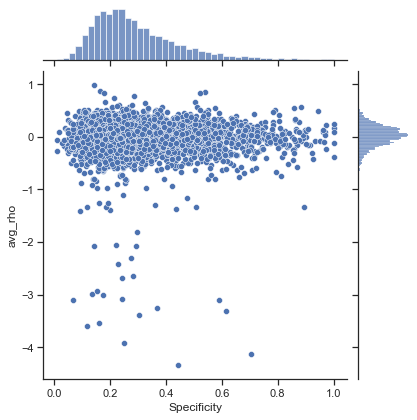

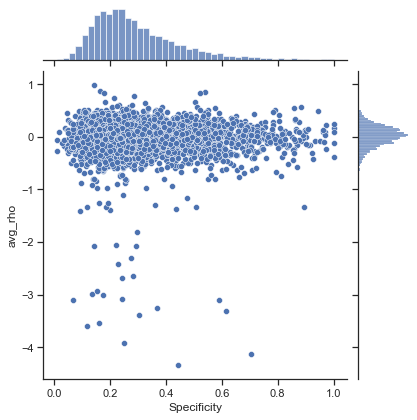

In [33]:
##### Correlate GS score with avg rho CRISPRi
rho_df = pd.read_csv('/Users/davidy/misc_resources/guide_libraries/AllBassikSafesRhos.csv', usecols=['grna','avg_rho'])
safe_reference_df = pd.read_csv('/Users/davidy/misc_resources/guide_libraries/alignments/hg38_pam_align_crisprI_human_20160604_ref_safes_GuideScanCoords.csv', usecols=['chrom','GS_start','GS_end','old_name','PerturbationTargetID','guideSpacerSeq'])
safe_reference_df['Region-name'] = safe_reference_df['chrom'] + ':' + safe_reference_df['GS_start'].astype(str) + '-' + safe_reference_df['GS_end'].astype(str)

merged_df = rho_df.merge(safe_reference_df, how='left', left_on='grna',right_on='old_name')[['old_name','avg_rho','Region-name','guideSpacerSeq','PerturbationTargetID']]

# Now merge again with GS annotations
merged_df = merged_df.merge(results, how = 'left',on='Region-name')

g1 = sns.jointplot(data=merged_df,x='Specificity',y='avg_rho')

# Remove NaNs in Specificity column
merged_df = merged_df.dropna(subset=['Specificity'])


# Plot
g2 = sns.jointplot(data=merged_df,x='Specificity',y='avg_rho')

strong_safes = merged_df.loc[merged_df['avg_rho']<=-1]
lowcfd_strong = strong_safes.loc[strong_safes['Specificity']<=0.2]
highcfd_strong = strong_safes.loc[strong_safes['Specificity']>0.2]
lowcfd = merged_df.loc[merged_df['Specificity']<=0.2]
highcfd = merged_df.loc[merged_df['Specificity']>0.2]

print(len(lowcfd_strong), len(lowcfd))
print(len(highcfd_strong), len(highcfd))



In [14]:
##### Formatting supplementary table of negative control guides used in screen
folder = '/Users/davidy/jamboree20crispr/ontarget_analysis/all_series/'
files = ['CD164_LS_R2_ENCFF628VNJ.tsv', 'CD164_LS_R1_ENCFF839NUC.tsv', 'CD164_HS_R2_ENCFF005BXE.tsv', 'CD164_HS_R1_ENCFF426QLL.tsv']
multi_dfs = []
for i in files:
    ifile = folder+i
    adf = pd.read_csv(ifile, sep = '\t', header=None, usecols=[0,1,2,3,5,6,14,15,16], names=['chr','start','end','name','strand','coordinates','synthesized_spacer','negative_control','type'])
    adf = adf.loc[adf['negative_control']=='negative_control']
    multi_dfs.append(adf)

concat_multi_dfs = pd.concat(multi_dfs)

concat_multi_dfs.drop_duplicates(subset=['synthesized_spacer'],inplace=True)


concat_multi_dfs['start'] = concat_multi_dfs['start'].astype('Int64')
concat_multi_dfs['end'] = concat_multi_dfs['end'].astype('Int64')
concat_multi_dfs['strand'] = "'"+concat_multi_dfs['strand']
display(concat_multi_dfs)

concat_multi_dfs.to_csv('CD164_all_negative_controls_names.csv',sep=',',header=True,index=False)
    

,chr,start,end,name,strand,coordinates,synthesized_spacer,negative_control,type
0,chr10,107843639,107843642,NA|chr10:107843620-107843639:+,'+,chr10:107843620-107843639:+,GGAATGATCACAGTCTAAAC,negative_control,ST
1,chr10,107843669,107843672,NA|chr10:107843650-107843669:+,'+,chr10:107843650-107843669:+,GACAAACACTTGGTTCAAAT,negative_control,ST
2,chr10,123598204,123598207,NA|chr10:123598185-123598204:+,'+,chr10:123598185-123598204:+,GCTACCGGCCCAAGAGCGTG,negative_control,ST
3,chr10,123598301,123598304,NA|chr10:123598305-123598324:-,'-,chr10:123598305-123598324:-,GAGTGAGCAGGCAGCCCCCT,negative_control,ST
4,chr10,128283961,128283964,NA|chr10:128283965-128283984:-,'-,chr10:128283965-128283984:-,GAGGCCATTCCTATGGGAGG,negative_control,ST
...,...,...,...,...,...,...,...,...,...
59996,NaN,<NA>,<NA>,NA|nt_997,NaN,nt_997,GGTACGCACGCCGATTTAAT,negative_control,NT
59997,NaN,<NA>,<NA>,NA|nt_998,NaN,nt_998,GGTATCACATAGCCCGGATT,negative_control,NT
59998,NaN,<NA>,<NA>,NA|nt_999,NaN,nt_999,GGTCAAGATACTCCGTCATG,negative_control,NT
59999,NaN,<NA>,<NA>,NA|nt_99,NaN,nt_99,GACAGGGTTGTCATTCAGACC,negative_control,NT
